# **Strategic Mobility Analytics: Transforming UK Transportation Networks for Net-Zero Achievement**

Understanding the user behavior of private and public means of transportation and the externalities (weather, congestion) that impact their usage is crucial for supporting the implementation of strategic decisions to mitigate $CO_2$ emmitted from transportation modes. Believing in the previously mentioned, we aspire to answer the following question in this report: **Can understanding transportation user behaviour in the UK help in formulating policies to encourage the UK's Net-Zero goals?** 

We conducted a thorough analysis on the usage of vehicles on the road (e.g., cars, buses, cycles) and the tube and rail stations in the UK. After detailed exploratory analyses of datasets on transportation modes, weather, tube congestion, and $CO_2$ emmissions, we found that cars and taxis yield the largest portion of $CO_2$ emmissions across all regions in the UK, pedal cycles are used more on weekdays than weekends and the least in winter in London, and that congestion has no impact on the usage of tube and rail services given their critical role in England's tube/rail transport network, and possibly their accessibility. We found that the transport network is interconnected across all modes of transportation, with most stations of similar modes having similar transportation patterns. 

Recommendations on nudging Londoners to use cycles on weekends and during the winter can aid in decreasing $CO_2$ emmissions. Enhancing service planning, resource distribution, and infrastructure development to take in an increasing passenger demand and end possible future congestion in tube stations will aid in maintaining tube/rail performance if not better it. 

In the following sections below, we implement data collection, cleaning, manipulating, visualization, dimentionality reduction and clustering analsysis, regression analysis, and network analysis. We also further interpret our findings and give further recommendations accordingly.

# **Section 1. Traffic Data EDA**

To investigate transportation patterns in the United Kingdom, we investigate vehicle usage across different regions using comprehensive road traffic data. Our analysis draws from the Department for Transport's official statistics database: https://roadtraffic.dft.gov.uk/downloads, which provides detailed annual traffic measurements. The dataset captures regional traffic volumes, measured in vehicle miles, categorized by vehicle type and region from 1993 to 2023 – a 30-year period that encompasses major shifts in transportation trends.
This longitudinal dataset includes measurements for diverse vehicle categories, including cars, light commercial vehicles (LCVs), heavy goods vehicles (HGVs), motorcycles, and buses. The regional granularity of the data allows us to examine both national trends and geographical variations in vehicle usage patterns.

**Abbreviations**:

| **Variable**                          | **Description**                                                                 |
|---------------------------------------|---------------------------------------------------------------------------------|
| **pedal_cycles**| Pedal_cycles                              |
| **two_wheeled_motor_vehicles**                              | Two-wheeled motor vehicles (e.g. motorcycles etc)                              |
| **cars_and_taxis**                | Cars and taxis, including passenger vehicles with nine or fewer seats, three-wheeled cars and four wheel-drive ‘sports utility vehicles’ (SUV). Cars towing caravans or trailers are counted as one vehicle.                               |
| **buses_and_coaches**                | Buses and coaches, including all public service vehicles and works buses which have a gross weight greater than 3.5 tonnes.                               |
| **LGVs**                | Light goods vans (Goods vehicles not exceeding 3.5 tonnes gross vehicle weight) Includes all car-based vans and those of the next largest carrying capacity such as transit vans. Also included are ambulances, pickups and milk floats.                               |
| **all_HGVs**                              | Heavy goods vehicle total, including all goods vehicles over 3.5 tonnes gross vehicle weight.                                                     |
| **all_motor_vehicles**                | All vehicles except pedal cycles                                                   |


## **I. Loading Libraries and Modules**

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.cluster.hierarchy import linkage, dendrogram
import ipywidgets as widgets
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import os
import json
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
from io import StringIO
from meteostat import Point,Daily
import numpy as np
import datetime as dt
import statsmodels.formula.api as smf
import networkx as nx



# Set the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

# Set the display colors for plots for different regions
distinct_colors = [
    '#FFC0CB',  # Pink for South West
    '#00FF00',  # Green for East Midlands
    '#0000FF',  # Blue for Scotland
    '#FFA500',  # Orange for Wales
    '#800080',  # Purple for North West
    '#FF0000',  # Red for London
    '#008080',  # Teal for East of England
    '#FFD700',  # Gold for Yorkshire and The Humber
    '#A52A2A',  # Brown for South East
    '#00FFFF',  # Cyan for West Midlands
    '#FF00FF'   # Magenta for North East
]

## **II. Import, Clean and Prepare the Data**

### Total Traffic Data

This dataset provides regional transportation statistics across different areas of the UK for the year 1993. For each region, it records several key transportation metrics. These include the road network extent (measured in both kilometers and miles as link_length), and traffic volumes for different modes of transport: pedal cycles, two-wheeled motor vehicles (likely motorcycles and scooters), cars and taxis, and buses and coaches. The values for vehicle usage appear to be measured in **"vehicle miles"**. Each metric is precisely recorded with detailed figures, allowing for comprehensive regional comparisons of transportation infrastructure and usage patterns.

In [89]:
# Load the data
df = pd.read_csv('data/region_traffic_by_vehicle_type.csv').copy()

# Remove redundant columns - 'region_id' and 'region_ons_code'
df = df.drop(['region_id', 'region_ons_code'], axis=1)

display(df.head())

year    region_name  link_length_km  link_length_miles  pedal_cycles  \
0  1993     South West        48751.55           30292.81  228000000.00   
1  1993  East Midlands        30681.75           19064.76  199700000.00   
2  1993       Scotland        58532.65           36370.50  147300000.00   
3  1993          Wales        32543.50           20221.59   81700000.00   
4  1993     North West        35952.60           22339.91  251400000.00   

   two_wheeled_motor_vehicles  cars_and_taxis  buses_and_coaches  \
0                289900000.00  19674300000.00       245000000.00   
1                172800000.00  16200200000.00       190100000.00   
2                126400000.00  17677600000.00       334300000.00   
3                104600000.00  11278800000.00       156300000.00   
4                199200000.00  23730000000.00       339800000.00   

           LGVs      all_HGVs  all_motor_vehicles  
0 2351700000.00 1295600000.00      23856600000.00  
1 2082200000.00 1647100000.00      20292400000.00  
2 2231000000.00 1339900000.00      21709300000.00  
3 1452700000.00  735200000.00      13727600000.00  
4 2801800000.00 1834400000.00      28905200000.00

### Total Traffic Data with Sum of Each Year

Based on the original data, we create a new dataset that captures total annual traffic volume per region, aggregating across all transportation modes.

In [90]:
# Add a new column of the total traffic for each year
df_with_sum = df.copy()

# Sum values from column "pedal_cycles" to "all_motor_vehicles" for each row
df_with_sum['total_traffic'] = df_with_sum['pedal_cycles'] + df_with_sum['all_motor_vehicles']

display(df_with_sum.head())

year    region_name  link_length_km  link_length_miles  pedal_cycles  \
0  1993     South West        48751.55           30292.81  228000000.00   
1  1993  East Midlands        30681.75           19064.76  199700000.00   
2  1993       Scotland        58532.65           36370.50  147300000.00   
3  1993          Wales        32543.50           20221.59   81700000.00   
4  1993     North West        35952.60           22339.91  251400000.00   

   two_wheeled_motor_vehicles  cars_and_taxis  buses_and_coaches  \
0                289900000.00  19674300000.00       245000000.00   
1                172800000.00  16200200000.00       190100000.00   
2                126400000.00  17677600000.00       334300000.00   
3                104600000.00  11278800000.00       156300000.00   
4                199200000.00  23730000000.00       339800000.00   

           LGVs      all_HGVs  all_motor_vehicles  total_traffic  
0 2351700000.00 1295600000.00      23856600000.00 24084600000.00  
1 2082200000.00 1647100000.00      20292400000.00 20492100000.00  
2 2231000000.00 1339900000.00      21709300000.00 21856600000.00  
3 1452700000.00  735200000.00      13727600000.00 13809300000.00  
4 2801800000.00 1834400000.00      28905200000.00 29156600000.00

### Data Grouped by Year

From the original dataset, we derived a time series of national traffic volumes by summing the traffic data across all regions for each year in the study period.

In [91]:
# Sum the figures of different vehicle types for each year
df_grouped = df_with_sum.groupby('year').sum().reset_index()
df_grouped = df_grouped.drop('region_name', axis=1)

# Display the first 10 years of the grouped data
display(df_grouped.head(10))

year  link_length_km  link_length_miles  pedal_cycles  \
0  1993       384838.87          239127.79 2490100000.00   
1  1994       385557.08          239574.08 2495600000.00   
2  1995       386400.62          240098.21 2573600000.00   
3  1996       386983.35          240460.31 2531800000.00   
4  1997       387892.68          241025.33 2536100000.00   
5  1998       388640.64          241490.11 2456900000.00   
6  1999       389514.78          242033.25 2534700000.00   
7  2000       390235.78          242481.27 2585800000.00   
8  2001       390968.58          242936.59 2632100000.00   
9  2002       391663.48          243368.41 2743700000.00   

   two_wheeled_motor_vehicles  cars_and_taxis  buses_and_coaches  \
0               2340100000.00 210084900000.00      2871000000.00   
1               2346000000.00 214388600000.00      2876400000.00   
2               2329800000.00 218175800000.00      3043800000.00   
3               2336100000.00 223645600000.00      3114000000.00   
4               2461600000.00 227296400000.00      3202800000.00   
5               2553200000.00 230279200000.00      3261100000.00   
6               2793200000.00 234532900000.00      3295000000.00   
7               2834500000.00 233546700000.00      3194000000.00   
8               2977300000.00 236669200000.00      3182100000.00   
9               3131900000.00 242357500000.00      3201700000.00   

            LGVs       all_HGVs  all_motor_vehicles   total_traffic  
0 25846400000.00 15071400000.00     256213900000.00 258704000000.00  
1 26927400000.00 15394500000.00     261932800000.00 264428400000.00  
2 27657400000.00 15810100000.00     267016800000.00 269590400000.00  
3 28703800000.00 16301400000.00     274101200000.00 276633000000.00  
4 30170800000.00 16687000000.00     279818500000.00 282354600000.00  
5 31563500000.00 17235800000.00     284893200000.00 287350100000.00  
6 32055500000.00 17478600000.00     290155400000.00 292690100000.00  
7 32435600000.00 17539700000.00     289550700000.00 292136500000.00  
8 33202600000.00 17428100000.00     293459300000.00 296091400000.00  
9 33962200000.00 17583200000.00     300236700000.00 302980400000.00

### Data Filtered by a Specific Region

We developed a custom function that allows for targeted analysis of traffic patterns by filtering the dataset for any specific region of interest.

**All Regions**:
* South West
* East Midlands
* Scotland
* Wales
* North West
* London
* East of England
* Yorkshire and the Humber
* South East
* West Midlands
* North East

In [92]:
# Filter data for a specific region
def filter_data_by_region(region_name):
    """
    Filter the data for a specific region
    """
    # Filter the data
    df_filtered = df_with_sum[df_with_sum['region_name'] == region_name].copy()

    return df_filtered

display(filter_data_by_region('London').head())

year region_name  link_length_km  link_length_miles  pedal_cycles  \
5   1993      London        14350.45            8916.96  272100000.00   
16  1994      London        14384.46            8938.09  278400000.00   
27  1995      London        14417.87            8958.85  283300000.00   
38  1996      London        14447.85            8977.48  290100000.00   
49  1997      London        14488.18            9002.54  289100000.00   

    two_wheeled_motor_vehicles  cars_and_taxis  buses_and_coaches  \
5                 358200000.00  15882500000.00       273400000.00   
16                369400000.00  16062800000.00       281800000.00   
27                359900000.00  16003100000.00       303700000.00   
38                375000000.00  16161500000.00       309600000.00   
49                398600000.00  16229400000.00       315000000.00   

            LGVs     all_HGVs  all_motor_vehicles  total_traffic  
5  1928600000.00 640900000.00      19083500000.00 19355600000.00  
16 2010900000.00 623700000.00      19348500000.00 19626900000.00  
27 2087000000.00 608700000.00      19362500000.00 19645800000.00  
38 2055500000.00 647200000.00      19548900000.00 19839000000.00  
49 2105300000.00 646100000.00      19694300000.00 19983400000.00

## **III. Data Overview and Visualization**

### **Graph 1. Traffic Trend over the Years**

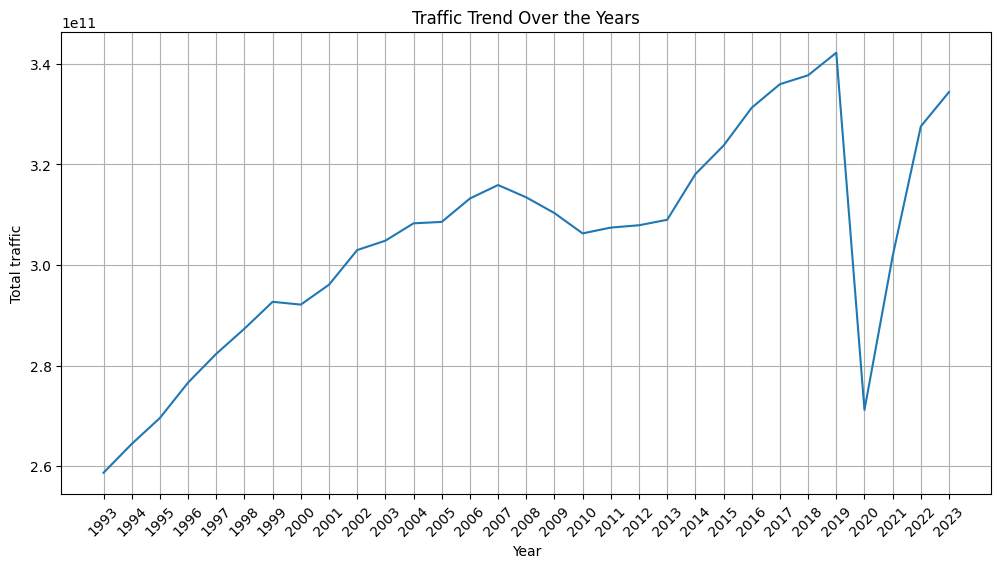

In [93]:
# Plot the overall traffic over years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='total_traffic', data=df_grouped)
plt.title('Traffic Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Total traffic')

# Set the x-ticks to show every year
years = df_grouped['year'].unique()
plt.xticks(ticks=years, labels=years, rotation=45)

plt.grid(True)
plt.show()

#### Key Inference
* There was a steady increase in traffic volume from 1993 (starting around 2.6 × 10^11) to 2019 (reaching about 3.4 × 10^11)
* There's a sharp drop in 2020 to approximately 2.7 × 10^11, likely due to COVID-19 lockdowns and restrictions
* Post-2020 shows a rapid recovery. By 2023, traffic volumes have largely rebounded, though not quite reaching the pre-pandemic peak

### **Graph 2. Time Series Plot across Regions**

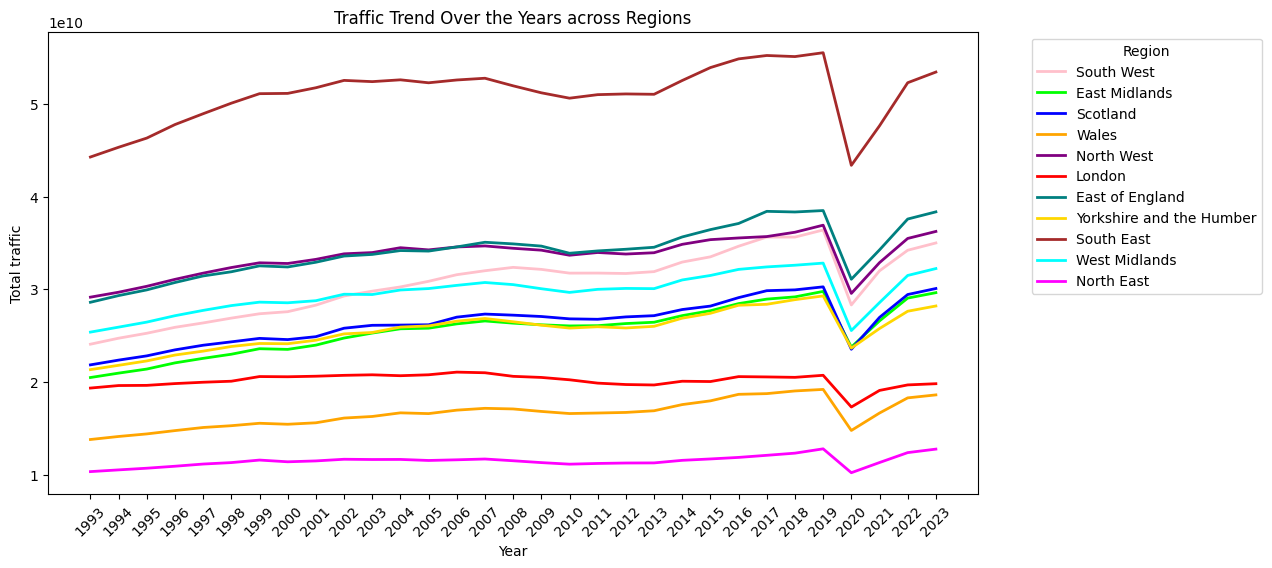

In [94]:
# Create time series plots across regions
def plot_traffic_trend_by_region():
    """
    Plot the traffic trend over the years for each region
    """
    # Get the unique region names
    region_names = df['region_name'].unique()

    # Plot the traffic trend for each region
    plt.figure(figsize=(12, 6))
    for idx, region_name in enumerate(region_names):
        df_filtered = filter_data_by_region(region_name)
        plt.plot(df_filtered['year'], df_filtered['total_traffic'], 
                label=region_name, 
                color=distinct_colors[idx],
                linewidth=2)
    
    colors = sns.color_palette("deep")
    plt.title('Traffic Trend Over the Years across Regions')
    plt.xlabel('Year')
    plt.ylabel('Total traffic')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(ticks=years, labels=years, rotation=45)
    plt.show()

plot_traffic_trend_by_region()

#### Key Inference
* **High Traffic:** South East (shown in brown) consistently has the highest traffic volume, around 5 × 10^10 units
* **Mid-High Traffic:** East of England, North West, South West, and West Midlands show similar volumes and patterns
* **Mid Traffic:** Regions including Scotland, East Midlands, and Yorkshire and the Humber cluster together
* **Lower Traffic:** London, Wales, and the North East show relatively lower traffic volumes compared to other regions




### **Graph 3. Time Series Plot across Regions by Different Vehicle Types**

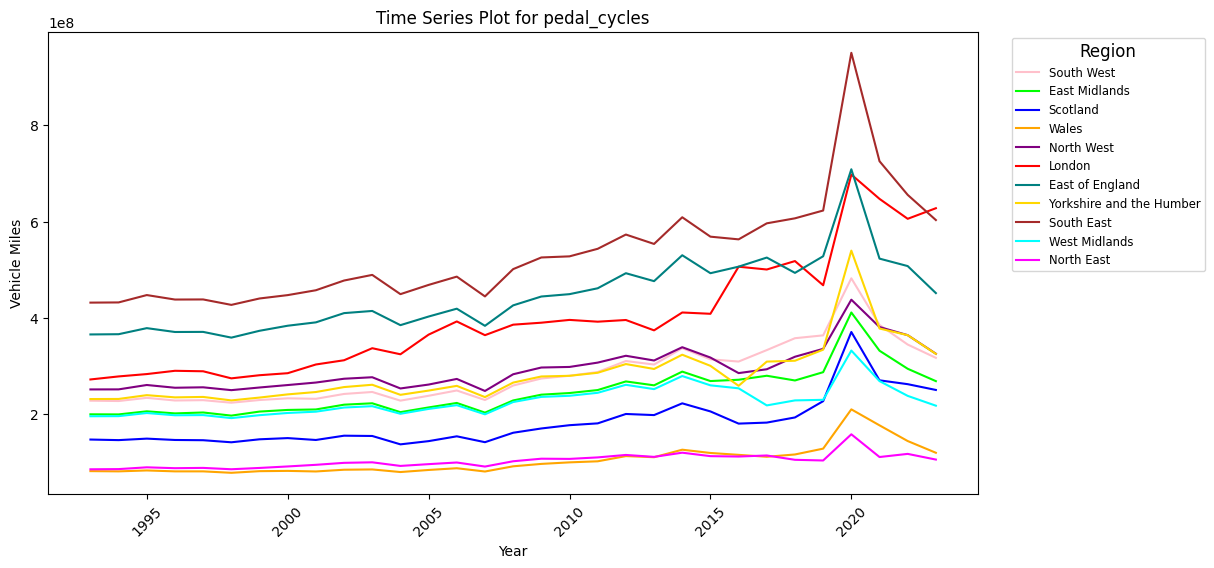

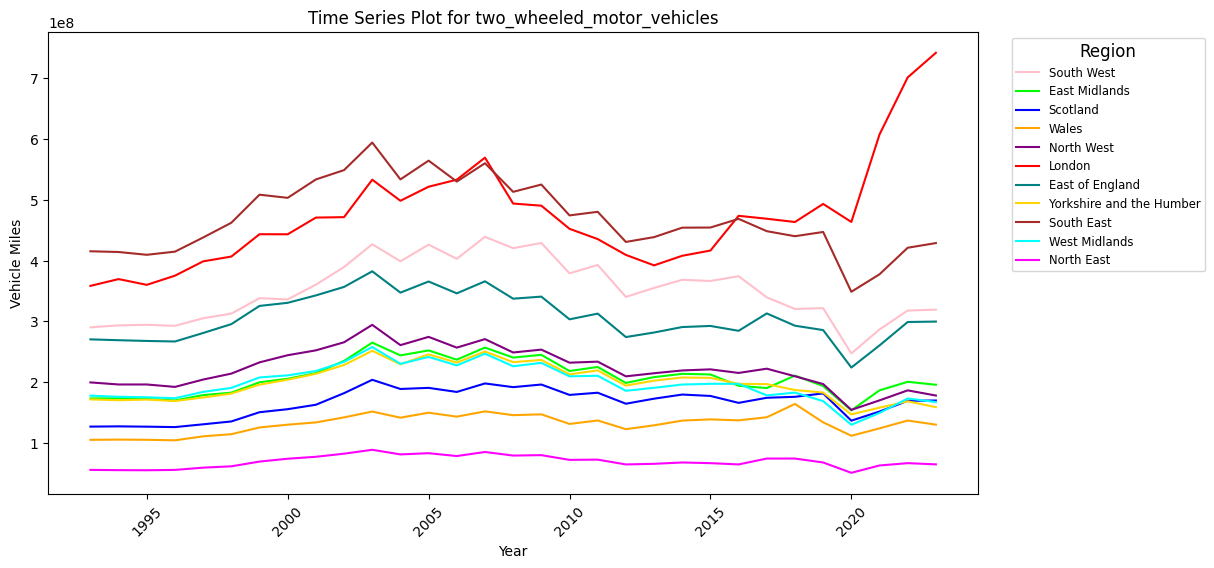

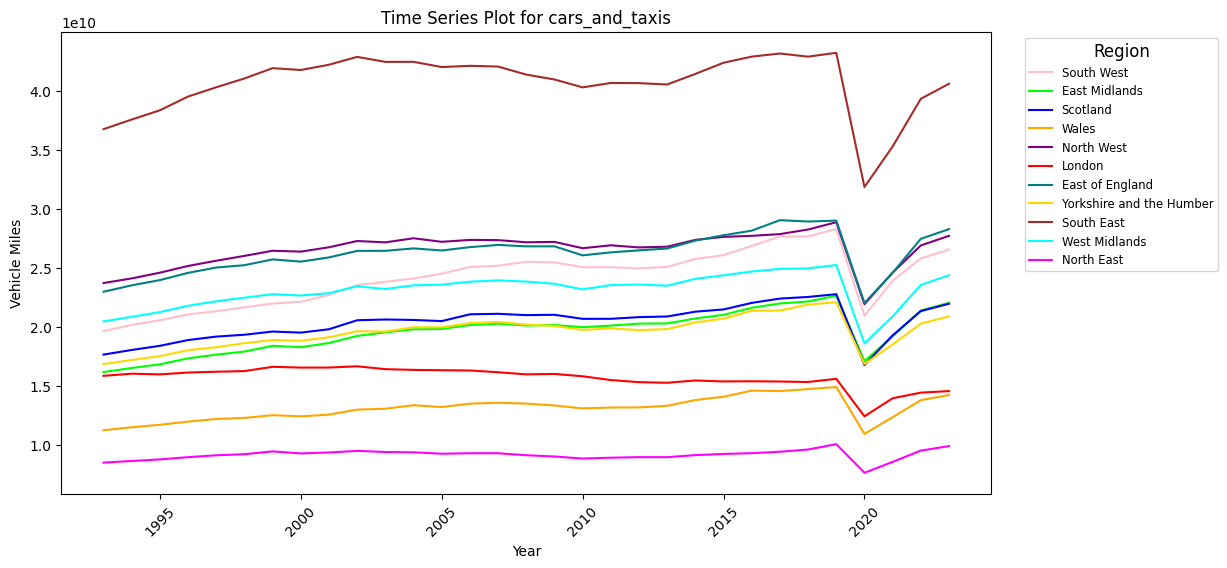

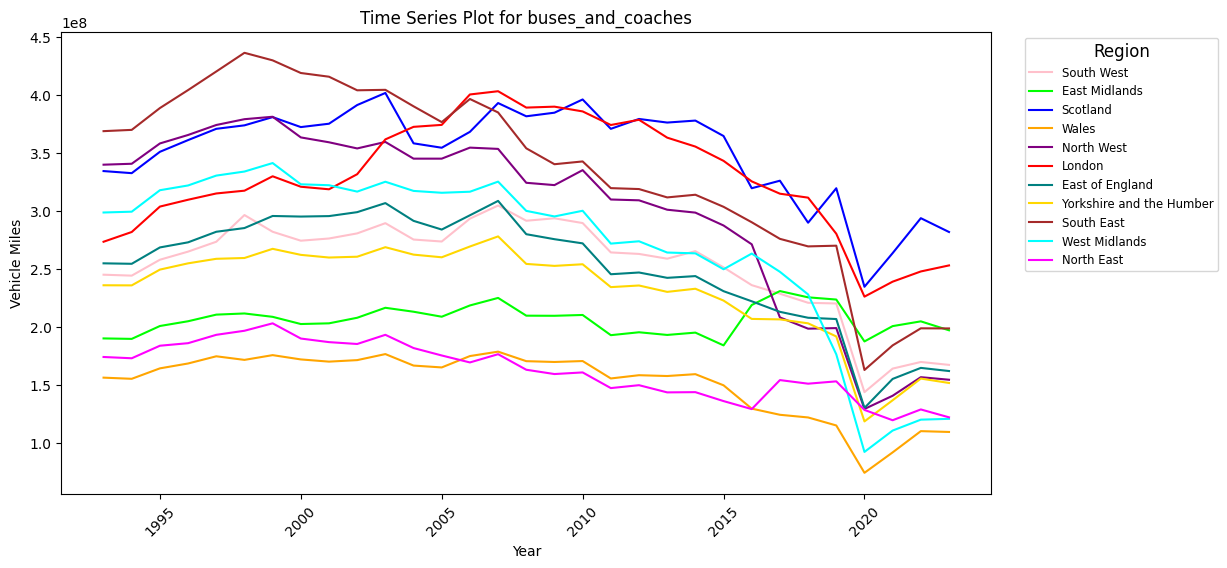

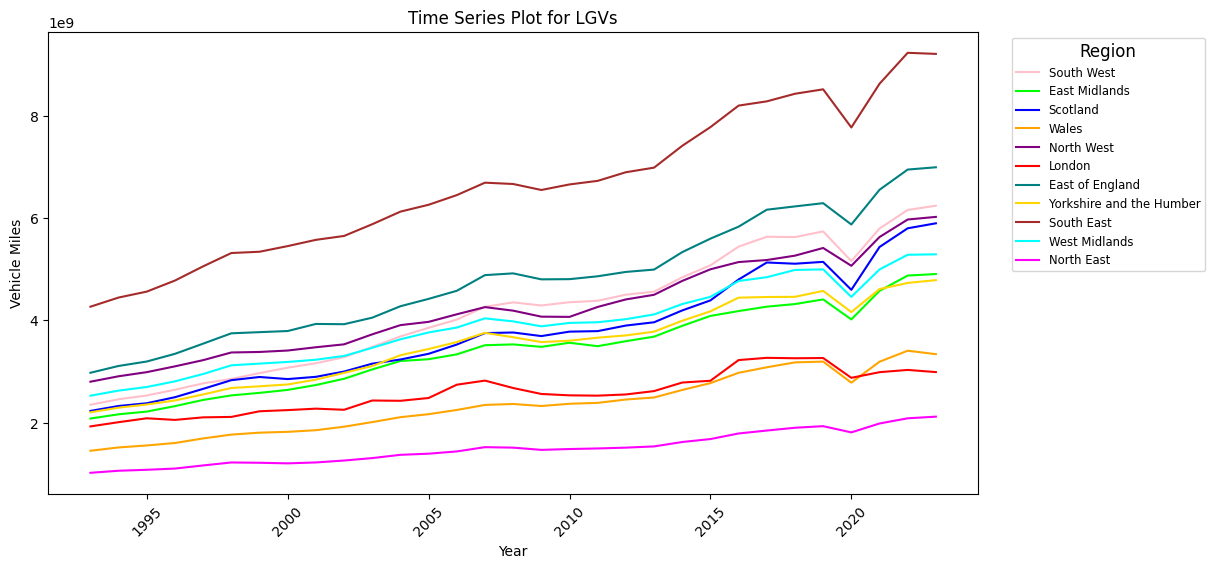

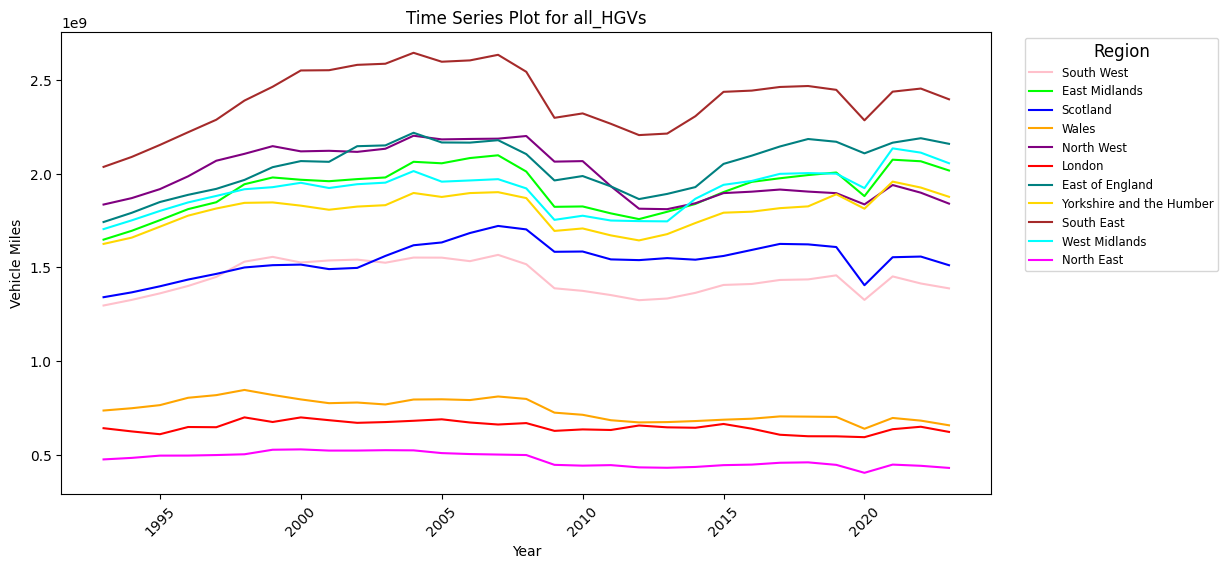

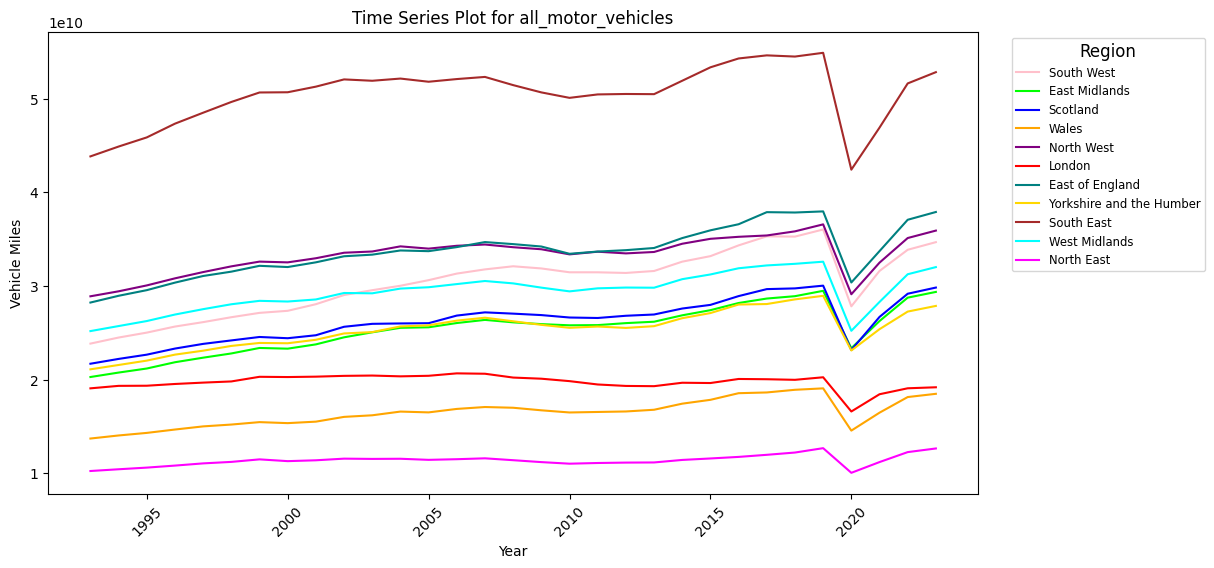

In [95]:
# Create time series plots for different regions of a specific vehicle type
def plot_time_series(vehicle_type):
    """
    Create time series plots for different regions of a specific vehicle type
    """
    # Create a new DataFrame for the vehicle type
    df_vehicle_type = df[['region_name', 'year', vehicle_type]].copy()

    # Pivot the DataFrame while keeping the order of regions
    region_order = df['region_name'].unique()
    df_vehicle_type['region_name'] = pd.Categorical(df_vehicle_type['region_name'], categories=region_order, ordered=True)
    df_vehicle_type = df_vehicle_type.pivot(index='year', columns='region_name', values=vehicle_type)

    # Plot the time series
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_vehicle_type, dashes=False, palette=distinct_colors)
    plt.title(f'Time Series Plot for {vehicle_type}')
    plt.legend(title='Region', bbox_to_anchor=(1.25, 1), loc='upper right', fontsize='small', title_fontsize='12')
    plt.xlabel('Year')
    plt.ylabel('Vehicle Miles')
    plt.xticks(rotation=45)
    plt.show()

# Plot 7 time series plots for different vehicle types
vehicle_types = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'all_HGVs', 'all_motor_vehicles']

for vehicle_type in vehicle_types:
    plot_time_series(vehicle_type)

#### Key Inference

1. Pedal Cycles
    * Most regions show gradual growth over the 30-year period.
    * A dramatic spike appears around 2020, likely corresponding to the COVID-19 pandemic.
    * Following the COVID-19 pandemic, London has the highest pedal cycle traffic volumes, which represents a tendency to eco-friendly transportation modes.

2. Two-Wheeled Motor Vehicles
    * London shows consistently higher usage of two-wheeled motor vehicles throughout the period, with a dramatic increase after 2020, suggesting a significant shift toward motorcycle and scooter use in the post-pandemic period.
    * Most regions demonstrate relatively stable patterns from 1993 to 2020, with slight increases during 2000-2005, followed by gradual declines, indicating consistent but modest use of motorcycles and scooters.
    * This could possibly be related to delivery services and commuters seeking alternatives to public transport.

3. Cars and Taxis
    * South East consistently maintains the highest volume of car and taxi traffic, showing significantly higher levels than other regions and experiencing steady growth until the 2020 disruption.
    * Most regions show relatively stable patterns with gradual increases from 1993 to 2019, suggesting steady growth in car usage across the UK.
    * COVID-19 Impact: The pandemic in 2020 caused a dramatic decline in car and taxi usage across all regions, followed by a recovery period where most regions trend back toward their pre-pandemic levels, though not fully reaching them by the end of the observation period.

4. Buses and Coaches
    * Unlike other vehicle types, bus and coach usage shows a general declining trend across most regions from 2000 onwards, with London and Scotland frequently alternating for the highest usage levels throughout the period.
    * There's considerable volatility in the data, with frequent crossovers between regions and more irregular patterns compared to other vehicle types, suggesting that bus and coach services are more sensitive to policy changes and local factors.
    * COVID-19 Impact: The pandemic in 2020 caused a severe drop in bus and coach usage across all regions, with the recovery being notably weaker than other vehicle types, indicating a potentially lasting shift away from public transport usage in the post-pandemic period.

5. Light Good Vehicles (LGV)
    * Unlike other vehicle types, LGV usage shows a consistent upward trend across all regions from 1993 to 2023, with the South East maintaining the highest volume throughout the period and showing particularly strong growth.
    * The growth patterns show clear regional hierarchies with South East leading, followed by Eastern regions, while Wales and the North East consistently maintain lower LGV traffic volumes, suggesting persistent regional differences in commercial and delivery activities.
    * Small COVID-19 Impact: The COVID-19 pandemic in 2020 had a relatively minor impact on LGV traffic compared to other vehicle types, showing only a slight dip followed by quick recovery, likely due to increased home deliveries and essential services.

6. High Good Vehicles (HGV)
    * The South East consistently leads in HGV traffic volume throughout the period, showing significant growth until 2008-2009, followed by a notable decline during the financial crisis, and then maintaining relatively stable levels with some fluctuations.
    * Most regions show three distinct phases: growth until 2008, a decline during the financial crisis (2008-2010), and a period of relative stability or modest recovery afterward, though not returning to pre-2008 peaks.
    * COVID-19 Impact: The COVID-19 pandemic in 2020 caused a relatively modest and brief downturn in HGV traffic compared to other vehicle types, suggesting the resilience of freight transport during the crisis, with most regions quickly returning to pre-pandemic levels.

7. All Motor Vehicles
    * The South East consistently maintains the highest total motor vehicle traffic throughout the entire period (1993-2023), showing significant growth until 2019 and remaining well above other regions even after the pandemic impact.
    * Most regions show a gradual upward trend from 1993 to 2019, with relatively stable hierarchical positions maintained between regions (North East and Wales consistently showing lower volumes compared to other regions).
    * COVID-19 Impact: The COVID-19 pandemic in 2020 caused a dramatic decline in motor vehicle traffic across all regions, followed by a recovery period where most regions trend back toward their pre-pandemic levels, though not fully reaching them by the end of the observation period.


### **Graph 4. Pie Chart of Traffic Distribution for a Specific Year**

In [96]:
# Plot a pie chart for the traffic distribution of a specific year
def plot_pie_chart(year):
    """
    Plot a pie chart for the traffic distribution of a specific year
    """
    # Filter the data for the specific year
    df_year = df[df['year'] == year].copy().drop(['year', 'link_length_km', 'link_length_miles', 'all_motor_vehicles'], axis=1)

    # Sum the traffic for each vehicle type
    traffic_by_vehicle_type = df_year.select_dtypes(include='number').sum()

    # Rename the labels
    label_mapping = {
        'pedal_cycles': 'Pedal Cycles',
        'two_wheeled_motor_vehicles': 'Two-Wheeled Motor Vehicles',
        'cars_and_taxis': 'Cars & Taxis',
        'buses_and_coaches': 'Buses & Coaches',
        'LGVs': 'Light Goods Vehicles (LGVs)',
        'all_HGVs': 'Heavy Goods Vehicles (HGVs)',
        'all_motor_vehicles': 'All Motor Vehicles'
    }
    renamed_labels = [label_mapping.get(label, label) for label in traffic_by_vehicle_type.index]
    traffic_by_vehicle_type.index = renamed_labels


    # Reorder the data (example: descending order)
    reordered_indices = traffic_by_vehicle_type.sort_values(ascending=False).index
    traffic_by_vehicle_type = traffic_by_vehicle_type[reordered_indices]
    renamed_labels = [label_mapping.get(label, label) for label in reordered_indices]

    # Plot the pie chart
    plt.figure(figsize=(15, 12))
    ptaches, l_text, p_text = plt.pie(traffic_by_vehicle_type, labels=traffic_by_vehicle_type.index, autopct='%1.1f%%')
    
    for t in p_text and l_text:
        t.set_size(10)
    
    plt.title(f'Traffic Distribution for the Year {year}', fontsize=16)
    plt.axis('equal')
    plt.legend(title='Vehicle Type', loc='upper right', fontsize='large', title_fontsize='12')
    plt.tight_layout()
    plt.show()

In [97]:
# Create an interactive plot to let user choose a specific year to display the traffic distribution
def plot_interactive_pie_chart():
    """
    Create an interactive plot to let user choose a specific year to display the traffic distribution
    """
    # Create a dropdown widget for the years
    years = df['year'].unique()
    years.sort()
    dropdown_year = widgets.Dropdown(
        options=years,
        value=years[0],
        description='Year:',
        disabled=False,
    )

    # Create an output widget to display the pie chart
    output = widgets.Output()

    # Define a function to update the pie chart
    def update_pie_chart(year):
        """
        Update the pie chart based on the selected year
        """
        with output:
            output.clear_output()
            plot_pie_chart(year)

    # Connect the dropdown widget to the update function
    widgets.interactive(update_pie_chart, year=dropdown_year)

    # Display the widgets
    display(dropdown_year, output)

plot_interactive_pie_chart()

Dropdown(description='Year:', options=(1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,…

Output()

## **IV. Data Analysis**

### **Graph 5. Time Series Plot for A Specific Region**

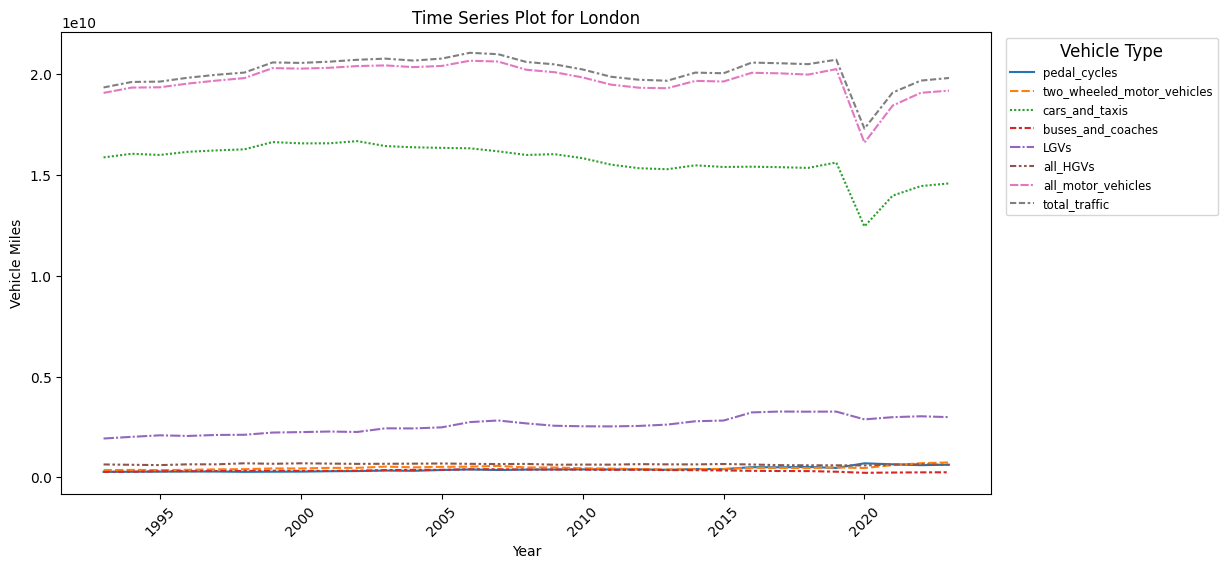

In [98]:
# Create time series Plots for a specific region
def plot_time_series_region(region_name):
    """
    Create time series Plots for a specific region
    """
    # Filter the data for the specific region
    df_region = filter_data_by_region(region_name).copy().drop(['region_name', 'link_length_km', 'link_length_miles'], axis=1)
    df_region = df_region.set_index('year')

    # Plot the time series
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_region)
    plt.title(f'Time Series Plot for {region_name}')
    plt.xlabel('Year')
    plt.ylabel('Vehicle Miles')
    plt.xticks(rotation=45)
    plt.legend(title='Vehicle Type', bbox_to_anchor=(1.25, 1), loc='upper right', fontsize='small', title_fontsize='12')
    plt.show()

plot_time_series_region('London')

#### Key Inference
* Highest Vehicle Categories: all_motor_vehicles & cars_and_taxis
* Lowest Vehicle Categories: buses_and_coaches & pedal_cycles
* Stability with Slight Decline: Most vehicle categories show remarkable stability over the 25+ year period, with a slight declining trend visible in cars/taxis and total traffic from 2000 onwards, suggesting successful policies to reduce motor vehicle dependency in London
* COVID-19 Impact: The 2020 pandemic caused a significant dip across almost all vehicle types, with the most pronounced drops in total traffic and motor vehicles. However, the data shows a recovery trend post-2020, though not necessarily returning to pre-pandemic levels for all categories

### **Graph 6. Grouped Bar Chart for Traffic Distribution for A Specific Year**

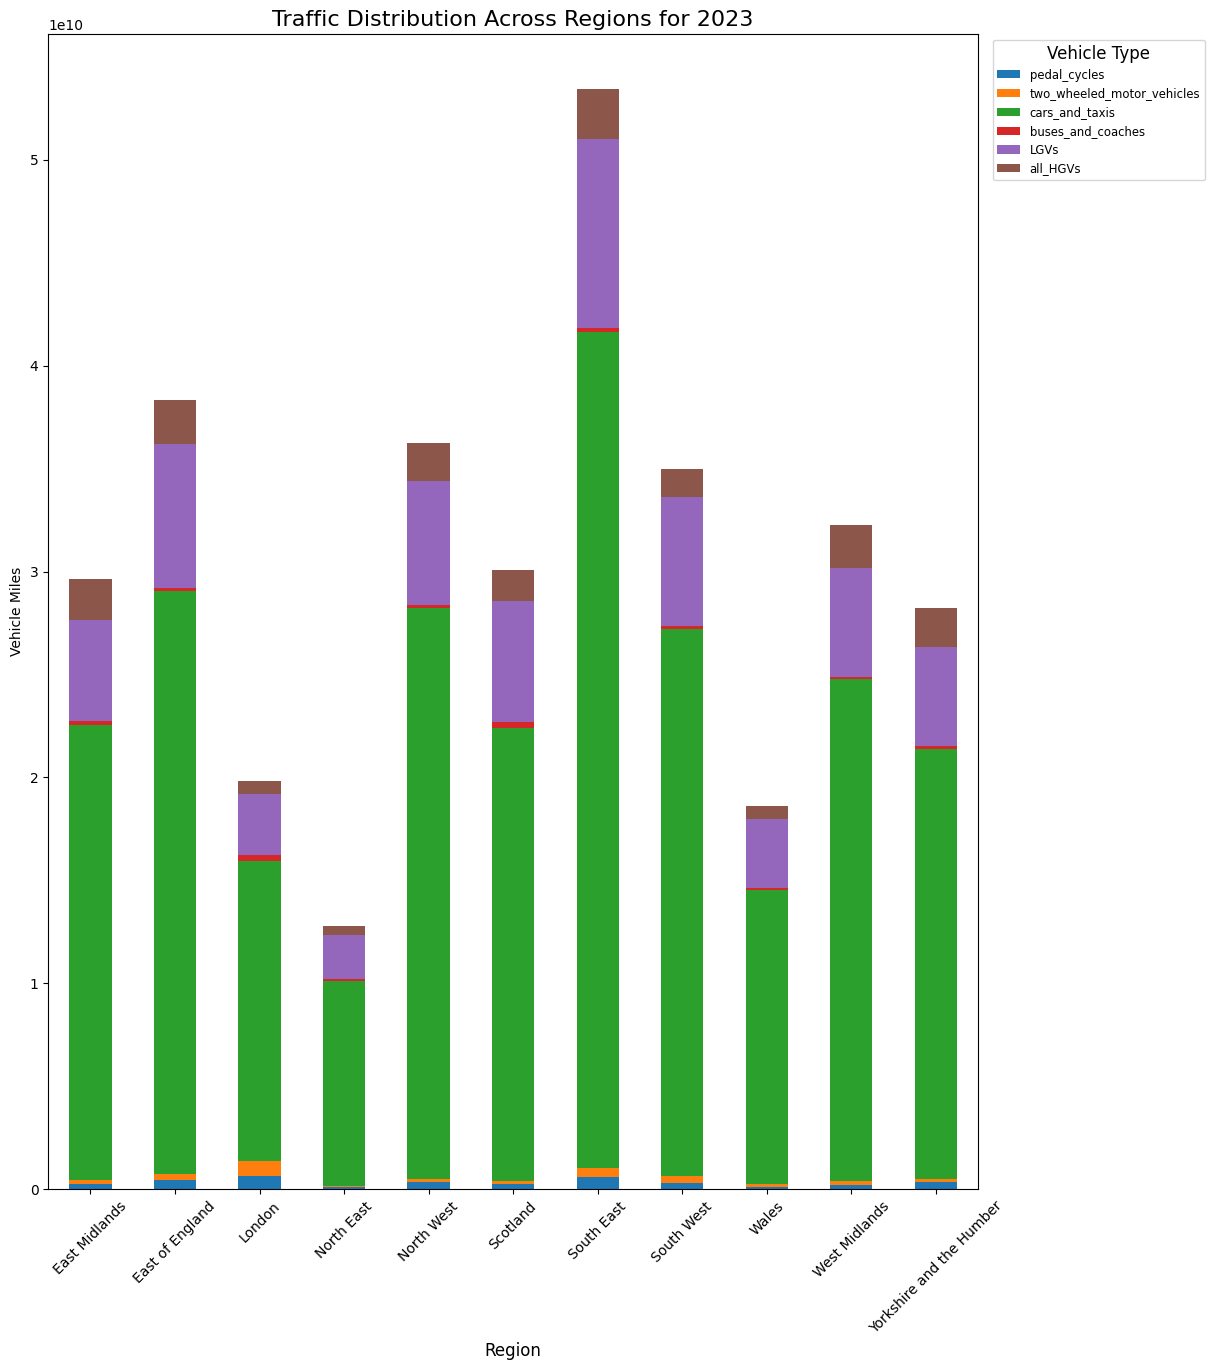

In [99]:
# Create a grouped bar plot for the traffic distribution across regions
def plot_grouped_bar_plot(year):
    """
    Create a grouped bar plot for the traffic distribution across regions
    """
    # Filter the data for the specific year
    df_year = df[df['year'] == year].copy().drop(['year', 'link_length_km', 'link_length_miles', 'all_motor_vehicles'], axis=1)

    # Sum the traffic for each region
    traffic_by_region = df_year.groupby('region_name').sum()

    # Plot the grouped bar plot
    traffic_by_region.plot(kind='bar', stacked=True, figsize=(12, 15))
    plt.title(f'Traffic Distribution Across Regions for {year}', fontsize=16)
    plt.xlabel('Region', fontsize=12)
    plt.ylabel('Vehicle Miles')
    plt.xticks(rotation=45)
    plt.legend(title='Vehicle Type', bbox_to_anchor=(1.25, 1), loc='upper right', fontsize='small', title_fontsize='12')
    plt.show()

plot_grouped_bar_plot(2023)

#### Key Inference
* Regional Distribution
    * South East shows the highest total traffic volume
    * London shows relatively modest total traffic despite being the capital city
    * Cars and taxis (green) dominate the vehicle mix across all regions

* Pedal Cycles
    * The pedal cycle proportion is so small it's barely visible at the bottom of each bar
    * Even in London, where cycling is heavily promoted, it represents a tiny fraction of total vehicle miles
        * This small visibility doesn't necessarily reflect low importance, but rather the nature of cycles covering shorter distances compared to motorized vehicles

* London
    * Shows a more balanced distribution between vehicle types
    * This aligns with London's public transport focus and policies to reduce car dependency



### **Graph 7. Pairplot by Regions**

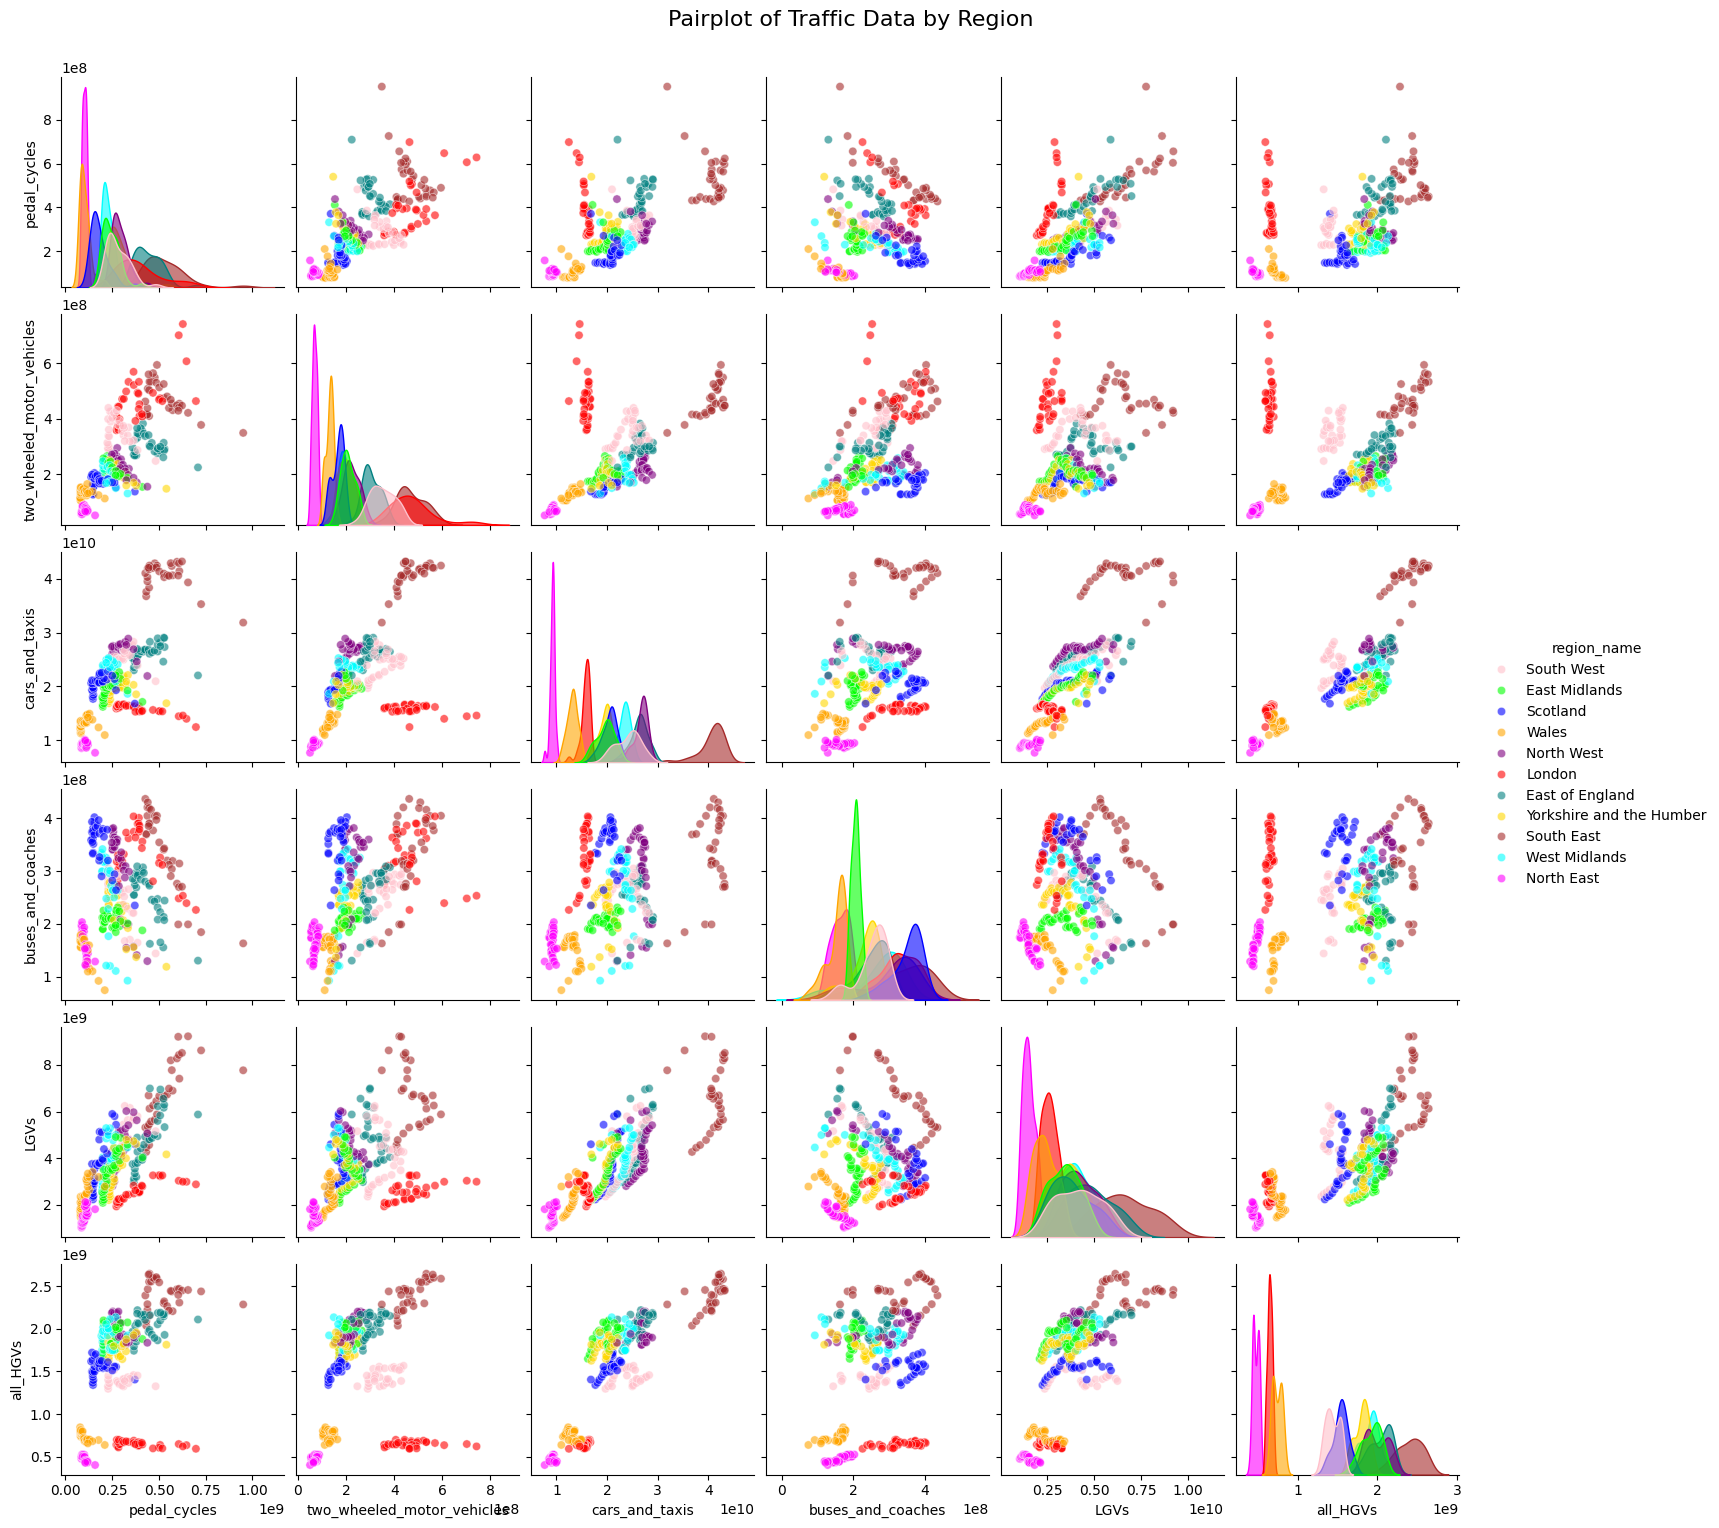

In [100]:
# Create a new DataFrame for the region and vehicle types
df_region_and_unique_vehicle = df.copy().drop(['year', 'link_length_km', 'link_length_miles', 'all_motor_vehicles'], axis=1)

# Create a pairplot using seaborn
sns.pairplot(df_region_and_unique_vehicle, hue='region_name', diag_kind='kde', palette=distinct_colors, plot_kws={'alpha': 0.6}, diag_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Traffic Data by Region', y=1.02, fontsize=16)
plt.show()


#### Key Inference
* Distribution Plots
    * Pedal cycles: Most regions have fewer miles driven, but some (likely London) show higher peaks on the lower end
    * Cars and taxis: Shows multiple peaks, indicating different scales of usage across regions
    * Buses and coaches: More skewed distribution, with most regions having lower numbers

* Scatter Plots
    * London (red dots):
        * Often appears as a separate cluster
        * Usually shows higher values
        * Forms distinct patterns separate from other regions
    * South East (brown dots):
        * Generally forms its own cluster
        * Shows consistently high values across vehicle types
        * Clear separation from other regions
    * Other Regions:
        * Tend to cluster together more
        * Show more gradual transitions between patterns
        * Have lower values compared to London and South East

* Notable Relationships
    * Strong positive correlations between:
        * Cars/taxis and LGVs (clear diagonal pattern)
        * LGVs and HGVs
        * Most motorized vehicle types show positive relationships

### **Graph 8. Clustermap for pedal cycles and all motor vehicles**

For time series hierarchical clustering, we use Dynamic Time Warping (DTW) distance instead of Euclidean due to the following reasons:
* Handles temporal shifts - Can match similar patterns even if they occur at different times or speeds
* Accounts for warping - Allows non-linear alignment of sequences, capturing similar shapes despite stretching or compression in time
* Reduces sensitivity to noise - More robust to local variations and outliers compared to point-by-point Euclidean distance
* Better pattern recognition - Can identify similar behavioral patterns in the data even when they're not perfectly aligned in time

<Figure size 2000x1000 with 0 Axes>

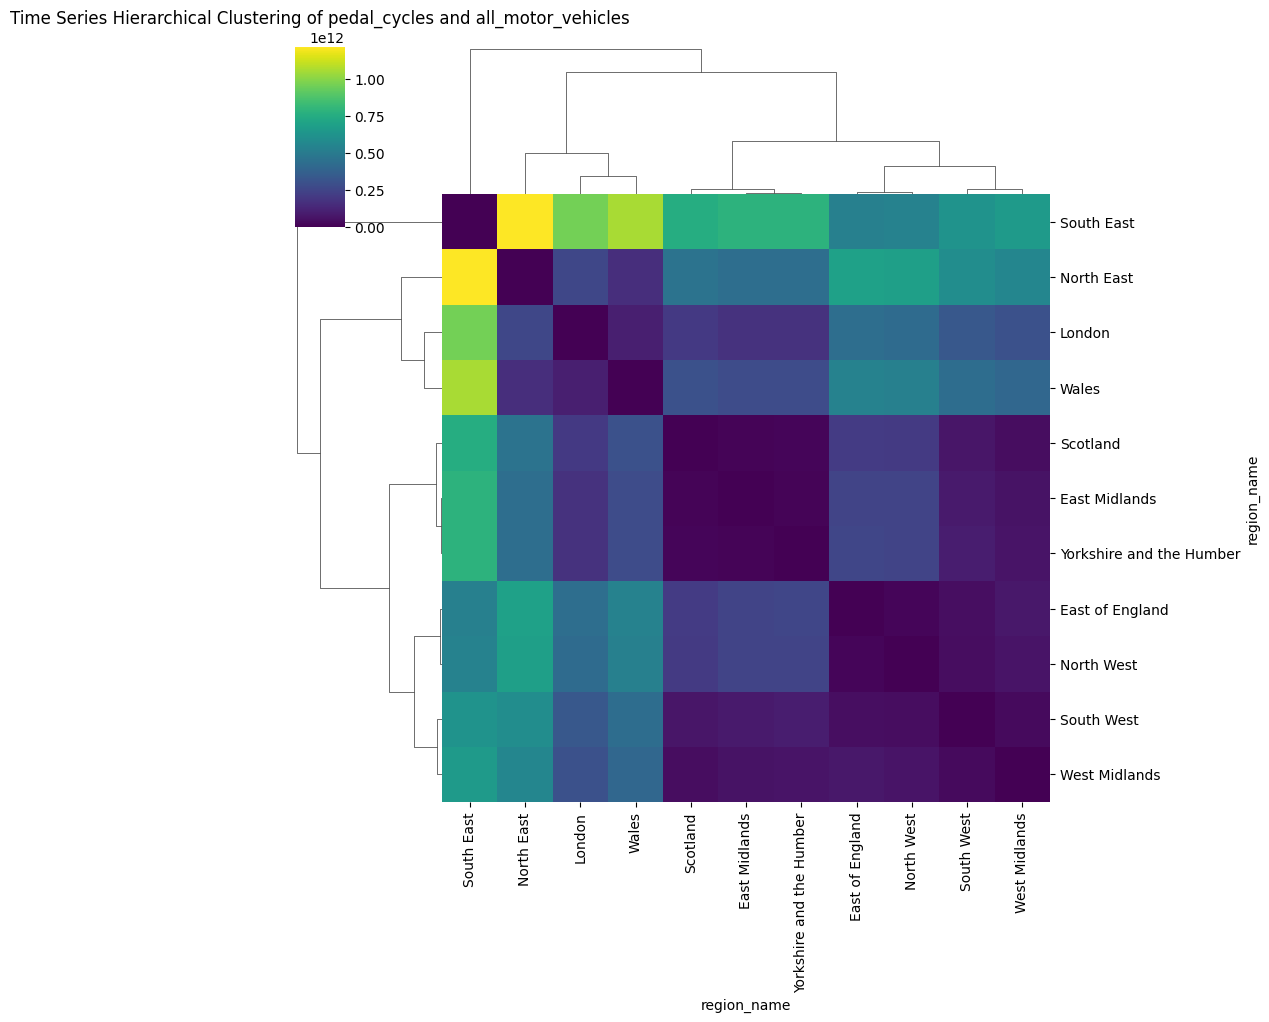

In [101]:
def plot_dendrogram_dtw(first_attribute, second_attribute):
    """
    Plot a dendrogram using DTW distance for time series data
    """
    # Pivot data to create time series for each region
    pivot_df1 = df.pivot(index='year', columns='region_name', values=first_attribute)
    pivot_df2 = df.pivot(index='year', columns='region_name', values=second_attribute)
    
    # Combine features into 3D array [n_regions, n_timepoints, n_features]
    n_regions = len(pivot_df1.columns)
    timeseries = np.zeros((n_regions, len(pivot_df1.index), 2))
    
    for i, region in enumerate(pivot_df1.columns):
        timeseries[i, :, 0] = pivot_df1[region].values
        timeseries[i, :, 1] = pivot_df2[region].values
    
    # Calculate DTW distance matrix
    distance_matrix = np.zeros((n_regions, n_regions))
    for i in range(n_regions):
        for j in range(i + 1, n_regions):
            distance, _ = fastdtw(timeseries[i], timeseries[j], dist=euclidean)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    
    # Create matrix with region labels
    new_matrix = pd.DataFrame(distance_matrix, 
                              columns=pivot_df1.columns,
                              index=pivot_df1.columns)

    # Create clustermap
    plt.figure(figsize=(20, 10))
    sns.clustermap(new_matrix, cmap='viridis', method='ward')
    plt.title(f'Time Series Hierarchical Clustering of {first_attribute} and {second_attribute}')
    plt.show()

plot_dendrogram_dtw('pedal_cycles', 'all_motor_vehicles')


#### Key Inference
The dendrogram and heatmap reveal several clusters of regions based on their 30-year patterns in pedal cycles and motor vehicle usage:
* North East, London, and Wales form one cluster, characterized by higher values and similar temporal patterns (shown by darker colors between them)
* Scotland, East Midlands, and Yorkshire and the Humber form another distinct cluster, showing similar traffic patterns over time
* East of England, North West, South West, and West Midlands cluster together, indicating similar transportation behavior

## **V. Dimensionality Reduction and Clustering**

### **Process and standardize the data**

To prevent scale-based bias in our analysis, we standardized the traffic volumes across vehicle categories. This transformation normalizes the data to account for the inherent volume disparities between different modes of transport, ensuring that our comparative analysis captures relative patterns rather than absolute differences in fleet sizes.

In [102]:
# Create a new dataframe with the selected features
vehicle_features = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis',
                    'buses_and_coaches', 'LGVs', 'all_HGVs']
data = df[vehicle_features].copy()

# Convert the dataframe to a numpy array
data = data.to_numpy()

# Standardize the data with StandardScaler()
data = StandardScaler().fit_transform(data)

# Convert nan values to zeros
data = np.nan_to_num(data)

### **Graph 9. Dimensionality Reduction - PCA**

We employed Principal Component Analysis (PCA) to reduce the complexity of our six-dimensional vehicle type data (pedal cycles, two-wheeled motor vehicles, cars/taxis, buses/coaches, LGVs, and HGVs) while preserving its essential patterns. By projecting the data onto two principal components, we can visualize and analyze complex regional transportation patterns in a more interpretable two-dimensional space. PCA is particularly valuable here as it reveals the underlying structure of our data by identifying the directions of maximum variance, allowing us to see how different regions cluster based on their vehicle type compositions and how these patterns evolve over time. This reduction helps highlight the most significant relationships between different vehicle types and regions.

PCA Loadings (correlations between variables and principal components):
                            PC1   PC2
pedal_cycles               0.43 -0.03
two_wheeled_motor_vehicles 0.38  0.48
cars_and_taxis             0.49 -0.10
buses_and_coaches          0.27  0.70
LGVs                       0.44 -0.40
all_HGVs                   0.41 -0.32

Explained Variance Ratio:
     Explained Variance Ratio
PC1                      0.63
PC2                      0.17


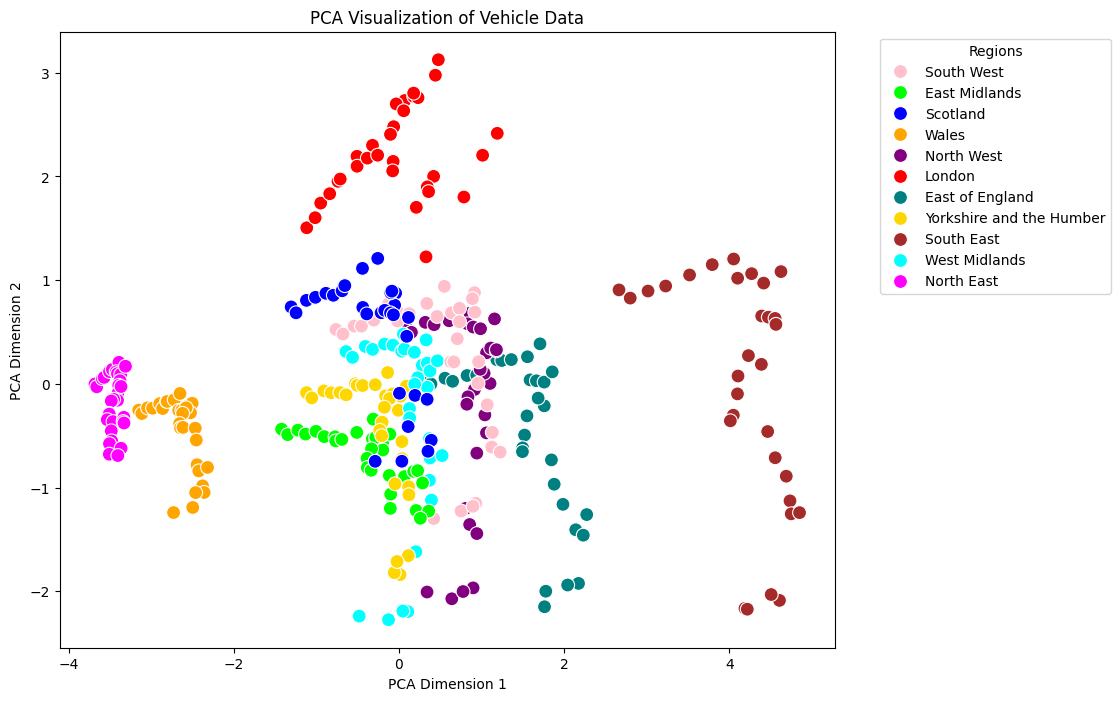

In [103]:
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data)

# Get the loadings (weights) of the principal components
# Loadings are the correlations between variables and principal components
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=vehicle_features
)

# Calculate the explained variance ratio
# This tells us how much of the total variance is explained by each PC
explained_variance = pd.DataFrame(
    {'Explained Variance Ratio': pca.explained_variance_ratio_},
    index=['PC1', 'PC2']
)

# Print the results
print("PCA Loadings (correlations between variables and principal components):")
print(loadings)
print("\nExplained Variance Ratio:")
print(explained_variance)

# Extract the region names from the original dataframe
regions = df['region_name']

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=regions, palette=distinct_colors, s=100)
plt.legend(title='Regions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA Visualization of Vehicle Data')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()


#### Key Inference
* Regional Clustering
    * Most regions form relatively coherent clusters, suggesting regional similarities in vehicle characteristics
    * South East is notably separated on the right side of the plot
    * Wales and North East cluster on the left side
    * London's data points form a distinct, elongated cluster that extends upward significantly (high values on PCA Dimension 2)
    * Other regions have more overlapping patterns in the center

* PCA Loadings
    1. Principal Component 1 (PC1):
        All values are positive and relatively similar (ranging from 0.27 to 0.49). This tells us that PC1 represents overall traffic volume across all vehicle types. The highest contributors are:

        * cars_and_taxis (0.49)
        * LGVs (0.44)
        * pedal_cycles (0.43)

        This makes intuitive sense because these are typically the most common vehicles on the road.

        <span style="color:red">**When a region scores high on PC1, it means it has high overall traffic volumes across all vehicle types.**



    2. Principal Component 2 (PC2):
        This component shows a more interesting pattern of contrast between different types of transport:

        * Strong positive values for:
            * buses_and_coaches (0.7)
            * two_wheeled_motor_vehicles (0.48)


        * Negative values for:
            * LGVs (-0.40)
            * all_HGVs (-0.32)

        This suggests that PC2 is capturing a contrast between public/personal transport (buses, motorcycles) versus commercial transport (LGVs, HGVs). 
        
        <span style="color:red">**When a region scores high on PC2, it tends to have more buses and two-wheeled vehicles relative to commercial vehicles.**

* Explained Variance Ratio

    The Explained Variance Ratio tells us how much of the total variation in the data each component explains:

    * PC1 explains 63% of the total variation
    * PC2 explains 17% of the total variation

    Together, these two components capture 80% of all the variation in the data
    (which is quite good for a dimensional reduction from 7 variables to 2)

    To put this in practical terms, imagine looking at the original scatter plot:

    * Moving from left to right (PC1) shows regions with increasing overall traffic volume
    * Moving from bottom to top (PC2) shows regions shifting from commercial-heavy traffic patterns to more public transport and two-wheeled vehicle usage


<span style="color: yellow">**PCA Dimension 1 (PC1) explains 63% of the total variance in the data, while PC2 only explains 17%, making PC1 more important for understanding the key patterns in the vehicle traffic data. The difference in overall traffic volume between regions (PC1) is mathematically more significant than the variation in vehicle type composition (PC2)**


### **Graph 10. Dimensionality Reduction - t-SNE**
* t-SNE also reduces the 7-dimensional data (7 vehicle types) to 2 dimensions while trying to preserve the relationships between data points
* Unlike PCA, t-SNE focuses on maintaining local structure and similarities between points
* In t-SNE, the dimensions are created through a complex optimization process and don't have clear interpretations. They're just a way to visualize high-dimensional similarities in a 2D space.

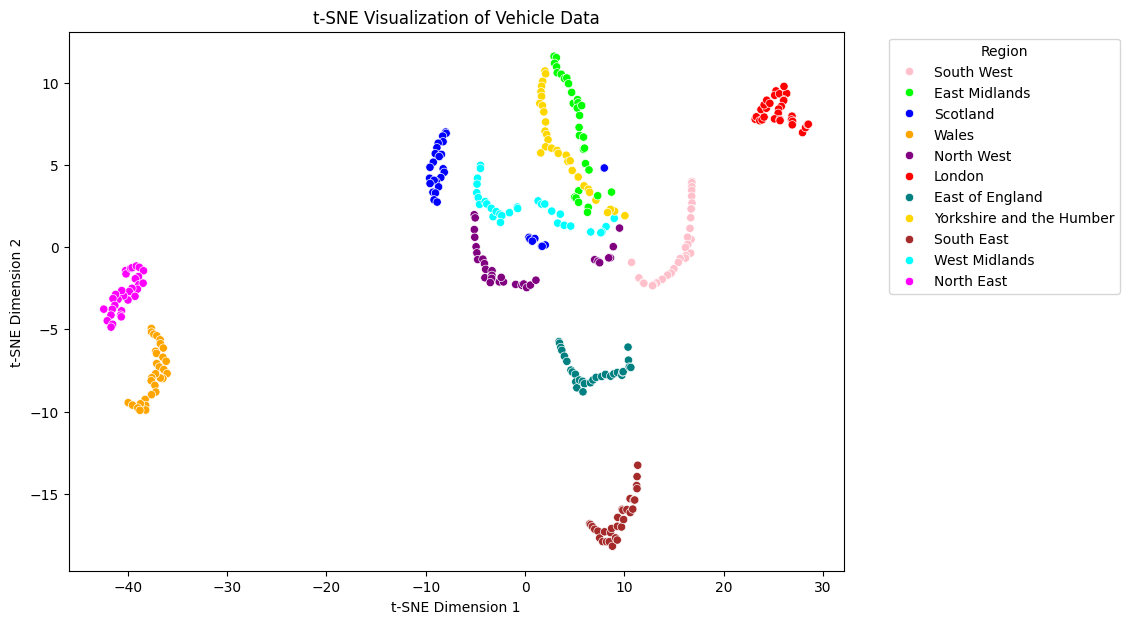

In [104]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(data)

# Add the t-SNE results to the DataFrame
tsne_data = df.copy()
tsne_data['tsne_1'] = tsne_results[:, 0]
tsne_data['tsne_2'] = tsne_results[:, 1]

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='region_name', data=tsne_data, palette=distinct_colors)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('t-SNE Visualization of Vehicle Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

#### Key Inference
* Regional Separation
    * t-SNE has created much clearer separation between regions compared to PCA
    * Each region forms its own distinct cluster with minimal overlap
    * Distinct regional patterns:
        * London (red, top right): Tight cluster showing consistent traffic patterns
        * South East (brown, bottom): Distinct cluster showing unique patterns
        * Wales and North East (orange and pink, left): Similar patterns, possibly due to similar infrastructure
        * Central regions (multiple colors, middle): Show some overlap in traffic patterns

* Focusing on London
    1. Consistency over time: The tight clustering means London's traffic patterns have remained very stable across different years. This suggests London has maintained a consistent transportation profile, likely due to:

        * Well-established public transport infrastructure (Underground, buses)
        * Consistent urban planning policies
        * Stable traffic management systems (like the Congestion Charge zone)


    2. Distinctiveness: The distance from other regions on both dimensions is substantial. This suggests London's traffic patterns are:

        * Quantitatively larger in volume
        * Qualitatively different in composition
        * Uniquely urban in character
        * Operating under distinct constraints


### **Graph 11. K-means Clustering**
We applied K-means clustering to identify natural groupings in regional transportation patterns, specifically focusing on the relationship between pedal cycles and motor vehicles. This pairing is particularly interesting as it represents the contrast between non-motorized and motorized transport, potentially revealing how different regions balance sustainable and traditional transportation modes. 

K-means clustering helps us discover distinct patterns in this relationship, grouping regions with similar characteristics together. This clustering approach helps policymakers identify regions with similar transportation profiles and potentially transfer successful strategies between regions within the same cluster.

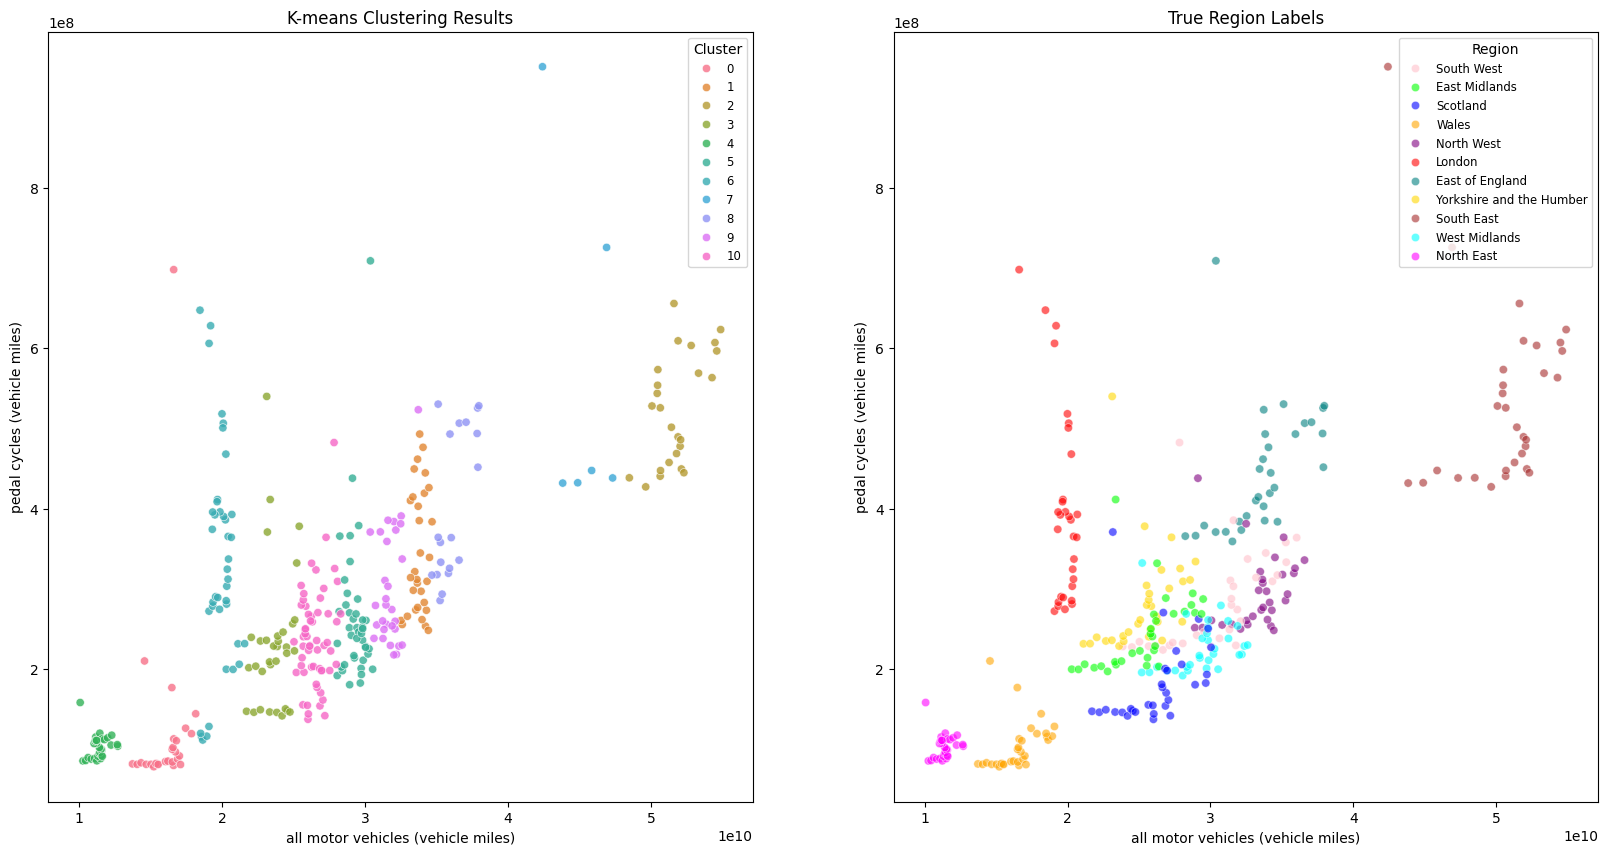

In [105]:
# Create new dataframe with regions and all vehicle types (including all_motor_vehicles)
df_region_and_vehicles = df.copy().drop(['year', 'link_length_km', 'link_length_miles'], axis=1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=11, random_state=50)
df_region_and_vehicles['cluster'] = kmeans.fit_predict(df_region_and_vehicles.iloc[:, 1:])


plt.figure(figsize=(20, 10))

# Plot 1: Scatter plot for pedal_cycles against all_motor_vehicles colored by cluster assignment
plt.subplot(1, 2, 1)
custom_palette = sns.color_palette("husl", n_colors=11) # Create a custom color palette for all 11 clusters
cluster_colors = {i: custom_palette[i] for i in range(11)} # Force showing all clusters by creating a categorical color mapping
sns.scatterplot(data=df_region_and_vehicles, x='all_motor_vehicles', y='pedal_cycles', hue='cluster', hue_order=range(11), palette=cluster_colors, alpha=0.8)
plt.title('K-means Clustering Results')
plt.xlabel('all motor vehicles (vehicle miles)')
plt.ylabel('pedal cycles (vehicle miles)')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper right', fontsize='small')

# Plot 2: Scatter plot for petal width against petal length colored by true labels
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_region_and_vehicles, x='all_motor_vehicles', y='pedal_cycles', hue='region_name', palette=distinct_colors, alpha=0.6)
plt.title('True Region Labels')
plt.xlabel('all motor vehicles (vehicle miles)')
plt.ylabel('pedal cycles (vehicle miles)')
plt.legend(title='Region', bbox_to_anchor=(1, 1), loc='upper right', fontsize='small')

plt.show()



#### Key Inference
* Strong Matches
    * London's data points (red in true labels) seem to be mostly captured in a single cluster in the K-means plot (appears as light turquoise points around x=2)
    * South East (brown in true labels) is fairly well captured as cluster 2 (gold in K-means) in the upper right region

* Partial Matches
    * The lower left clusters (North East and Wales in true labels) are somewhat preserved in the K-means clustering, but with some mixing
    * The central regions show the most mixing between clusters, suggesting K-means is picking up on traffic pattern similarities that cross regional boundaries

* Notable Observations
    * Some regions are split across multiple clusters, suggesting within-region variations in traffic patterns
    * Some clusters contain data points from multiple regions, indicating similar traffic patterns across different regions

* Focusing on London
    * Tight Horizontal Clustering: stable motor vehicle traffic volumes with significant variation in cycling volumes over time
    * Lower motor vehicle numbers compared to most regions
    * Much higher cycling volumes compared to most regions

## **VI. Carbon Emission Calculation**

### **Convert the Unit**

For emissions analysis, we standardized the measurement units by converting "vehicle miles" to "vehicle kilometers" (multiplying by 1.60934). This conversion aligns our dataset with international emissions calculation protocols and enables direct application of standard carbon emission factors, which are typically expressed in metric units.

In [106]:
# Convert the unit from miles to km in df (for column 'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'all_HGVs', 'all_motor_vehicles')
carbon_emission_data = df.copy().drop(['link_length_km', 'link_length_miles', 'all_motor_vehicles'], axis=1)
for col in carbon_emission_data.columns:
    if col not in ['region_name', 'year']:
        carbon_emission_data[col] = carbon_emission_data[col] * 1.609344

carbon_emission_data.head()

year    region_name  pedal_cycles  two_wheeled_motor_vehicles  \
0  1993     South West  366930432.00                466548825.60   
1  1993  East Midlands  321385996.80                278094643.20   
2  1993       Scotland  237056371.20                203421081.60   
3  1993          Wales  131483404.80                168337382.40   
4  1993     North West  404589081.60                320581324.80   

   cars_and_taxis  buses_and_coaches          LGVs      all_HGVs  
0  31662716659.20       394289280.00 3784694284.80 2085066086.40  
1  26071694668.80       305936294.40 3350976076.80 2650750502.40  
2  28449339494.40       538003699.20 3590446464.00 2156360025.60  
3  18151469107.20       251540467.20 2337894028.80 1183189708.80  
4  38189733120.00       546855091.20 4509060019.20 2952180633.60

###  **Carbon Emission Factors for Each Vehicle Type**

The conversion factors are extracted from the two files at https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2024
1. Conversion factors 2024: condensed set (for most users)
2. Conversion factors 2024: methodology


**Conversion Factors**:

| **Variable**                          | **Conversion Factors**                                                                 | **Description**
|---------------------------------------|---------------------------------------------------------------------------------|-----------------------------|
| **pedal_cycles**| 0                              | all pedal cycles|
| **two_wheeled_motor_vehicles**                              | 0.10761                       | an average of small, medium, large, and average size of two-wheeled motor vehicles
| **cars_and_taxis**                | 0.16234   | an average of diesel and petrol cars
| **buses_and_coaches**                | 0.8751844                               | an average of buses and coaches|
| **LGVs**                | 0.23172  |an average of diesel and petrol cars                            |
| **all_HGVs**                              | 0.94762 |an average of average-laden HGVs and average-laden refrigerated HGVs                                                  |




In [107]:
# Calculate the carbon emissions for each vehicle type by multiplying conversion factors
# Conversion factors are in kg CO2 per km
conversion_factors = {
    'pedal_cycles': 0,
    'two_wheeled_motor_vehicles': 0.10761,
    'cars_and_taxis': 0.16234,
    'buses_and_coaches': 0.8751844,
    'LGVs': 0.23172,
    'all_HGVs': 0.94762
}

# Calculate the carbon emissions for each vehicle type
for col in carbon_emission_data.columns:
    if col not in ['region_name', 'year']:
        carbon_emission_data[col] = carbon_emission_data[col] * conversion_factors[col]

carbon_emission_data['all_motor_vehicles'] = carbon_emission_data['two_wheeled_motor_vehicles'] + carbon_emission_data['cars_and_taxis'] + carbon_emission_data['buses_and_coaches'] + carbon_emission_data['LGVs'] + carbon_emission_data['all_HGVs']

carbon_emission_data.head(10)

year               region_name  pedal_cycles  two_wheeled_motor_vehicles  \
0  1993                South West          0.00                 50205319.12   
1  1993             East Midlands          0.00                 29925764.55   
2  1993                  Scotland          0.00                 21890142.59   
3  1993                     Wales          0.00                 18114785.72   
4  1993                North West          0.00                 34497756.36   
5  1993                    London          0.00                 62033616.11   
6  1993           East of England          0.00                 46776325.27   
7  1993  Yorkshire and the Humber          0.00                 29648674.14   
8  1993                South East          0.00                 71904962.06   
9  1993             West Midlands          0.00                 30722399.49   

   cars_and_taxis  buses_and_coaches          LGVs      all_HGVs  \
0   5140125422.45       345075826.94  876989359.67 1975850324.79   
1   4232478912.53       267750672.25  776488176.52 2511904191.08   
2   4618465773.52       470852444.68  831978254.64 2043409887.46   
3   2946709494.86       220144292.86  541736804.35 1121214231.85   
4   6199721274.70       478599044.88 1044839387.65 2797545412.01   
5   4149476323.03       385076453.41  719208095.87  977402341.12   
6   6007981896.55       358878860.02 1109950729.32 2655258567.84   
7   4409039032.10       332258724.80  822021365.62 2477133129.49   
8   9600894113.74       519303907.73 1591274948.62 3103927266.17   
9   5351720629.38       420569967.04  942995702.60 2597611807.83   

   all_motor_vehicles  
0       8388246252.99  
1       7818547716.94  
2       7986596502.89  
3       4847919609.65  
4      10555202875.60  
5       6293196829.55  
6      10178846379.00  
7       8070100926.15  
8      14887305198.32  
9       9343620506.34

### **Carbon Emission Data Analysis**

#### **Graph 12. Carbon Emission Time Series Plot**

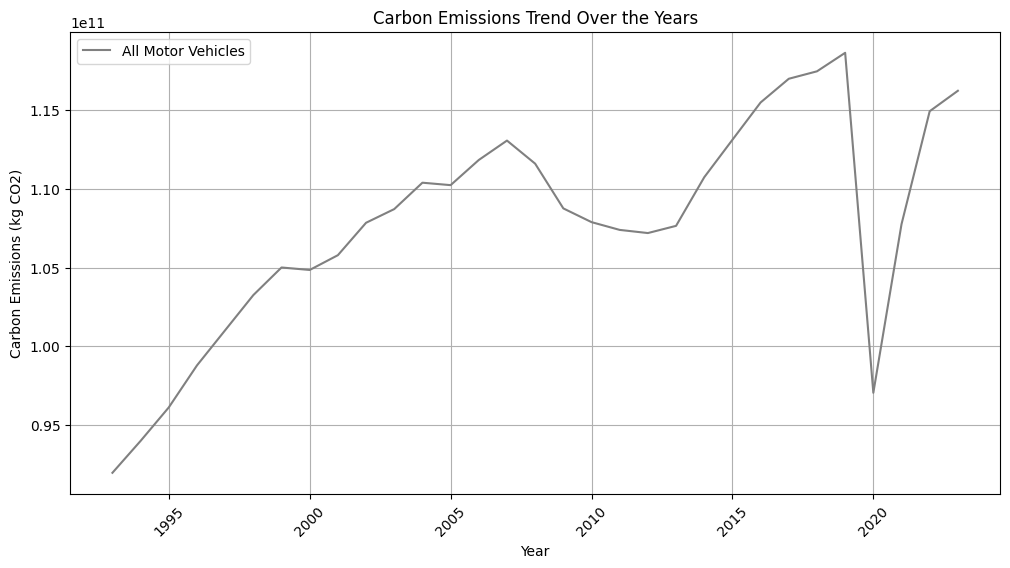

In [108]:
# Create a new DataFrame for the total carbon emissions by year (sum of all regions)
df_carbon_year = carbon_emission_data.groupby('year').sum().reset_index()
df_carbon_year = df_carbon_year.drop('region_name', axis=1)

# Time series plot for carbon emissions
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='all_motor_vehicles', data=df_carbon_year, label='All Motor Vehicles', color='grey')
plt.title('Carbon Emissions Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Carbon Emissions (kg CO2)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Key Inference
* Overall Trend: There's a generally increasing trend in carbon emissions from around 0.92 kg $CO_2$ in 1993 to approximately 1.16 kg $CO_2$ by 2022, though with significant variations.

* Notable Features: 
    * The sharpest decline occurs in 2020, dropping to around 0.97 kg $CO_2$
    * The highest peak appears just before 2020, reaching about 1.18 kg $CO_2$
    * There are several smaller plateaus and minor decreases throughout the timeline
    * The recovery after 2020 shows a V-shaped pattern, indicating a quick return to previous emission levels

* Rate of Change:
    * The steepest increase occurs between 2015-2019 (Sharp increase to the highest levels in the series)
    * The most dramatic change is the 2020 decline and subsequent recovery (likely due to COVID-19 pandemic)
    * The early years (1993-2000) show a consistent upward slope (slower growth rate)

#### **Graph 13. Carbon Emissions Bar Plot across Regions**

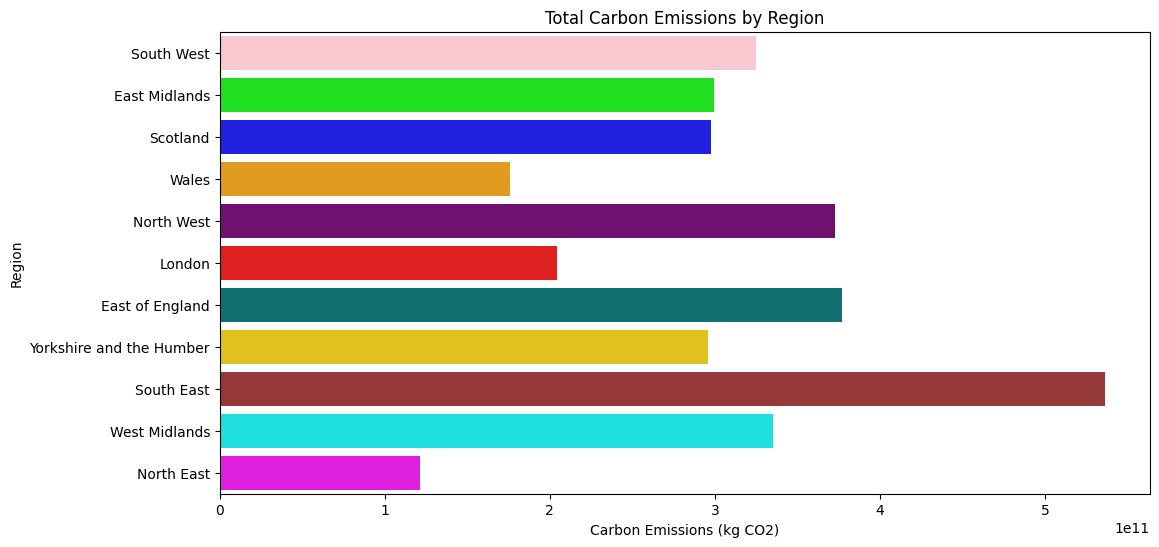

In [109]:
# Create a new DataFrame for the total carbon emissions by region (sum of all years)
region_order = df['region_name'].unique()
df_carbon_region = carbon_emission_data.groupby('region_name').sum().reindex(region_order)
df_carbon_region = df_carbon_region.drop('year', axis=1)
df_carbon_region

# Create bar plots for carbon emissions by regions
plt.figure(figsize=(12, 6))
sns.barplot(x='all_motor_vehicles', y='region_name', data=df_carbon_region, hue='region_name', palette=distinct_colors)
plt.title('Total Carbon Emissions by Region')
plt.xlabel('Carbon Emissions (kg CO2)')
plt.ylabel('Region')
plt.show()


#### Key Inference
* South East has the highest emissions at approximately 5.0 × 10¹¹ kg $CO_2$
* North East has the lowest emissions at around 1.0 × 10¹¹ kg $CO_2$
* Most regions fall between 2.0-4.0 × 10¹¹ kg $CO_2$

#### **Graph 14. Carbon Emission Grouped Bar Chart**

<Figure size 1200x800 with 0 Axes>

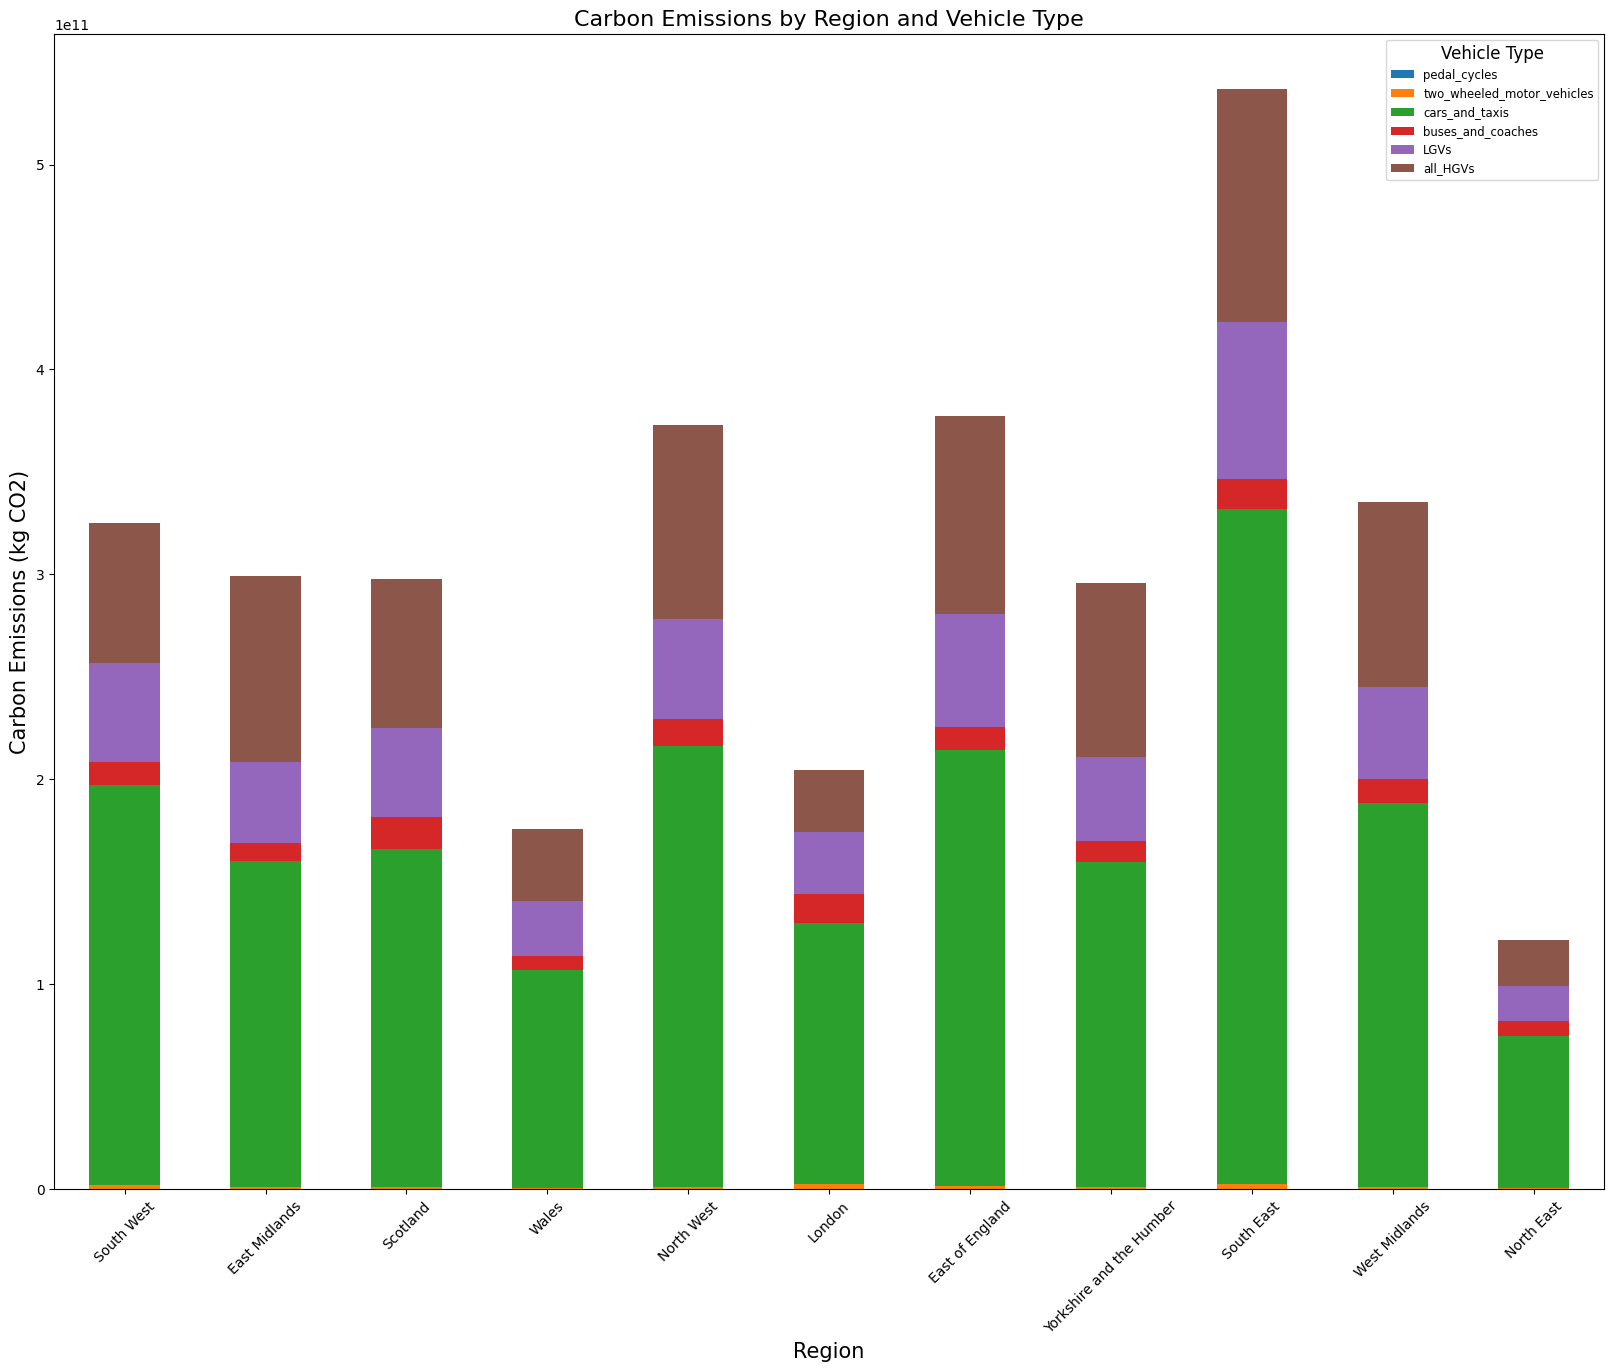

In [110]:
def plot_grouped_bar_chart_carbon(data):
    """
    Create a grouped bar chart for carbon emissions by region and vehicle type
    """
    # Create a new DataFrame for the carbon emissions
    data = data.drop(['all_motor_vehicles'], axis=1)

    # Create grouped bar chart for carbon emissions by region and vehicle type
    plt.figure(figsize=(12, 8))
    data.plot(kind='bar', stacked=True, figsize=(20, 15))
    plt.title('Carbon Emissions by Region and Vehicle Type', fontsize=16)
    plt.xlabel('Region', fontsize=15)
    plt.ylabel('Carbon Emissions (kg CO2)', fontsize=15)
    plt.xticks(rotation=45)
    plt.legend(title='Vehicle Type', bbox_to_anchor=(1, 1), loc='upper right', fontsize='small', title_fontsize='12')
    plt.show()

plot_grouped_bar_chart_carbon(df_carbon_region)




#### Key Inference
* Vehicle Type Distribution:
    * Cars and taxis (green bars) contribute the largest portion of emissions across all regions
    * HGVs (brown bars) and LGVs (purple bars) are typically the second and third largest contributors
    * Buses and coaches (red bars) have relatively small contributions
    * Two-wheeled motor vehicles (orange bars) and pedal cycles (blue bars) have minimal impact

* Regional Comparisons:
    * South East shows the highest total emissions, with notably high contributions from cars/taxis and HGVs
    * North East has the lowest total emissions across all vehicle types
    * London shows a unique pattern with:
        * Lower car emissions relative to its population
        * Higher proportion of bus emissions
        * Significant LGV contributions

* Notable Patterns:
    * Urban vs. Rural differences:

        * Urban areas (London, West Midlands) show higher bus emissions
        * Rural areas show higher proportions of car emissions


    * HGV emissions are particularly high in:

        * South East
        * East of England
        * North West

* Vehicle Type Trends:
    * Cars and taxis dominate emissions in every region
    * HGV emissions vary significantly between regions
    * Bus emissions are most prominent in urban areas
    * Two-wheeled vehicles and cycles have consistently low emissions across all regions

#### **Graph 15. Carbon Emission Clustermap across Regions**

<Figure size 2000x1000 with 0 Axes>

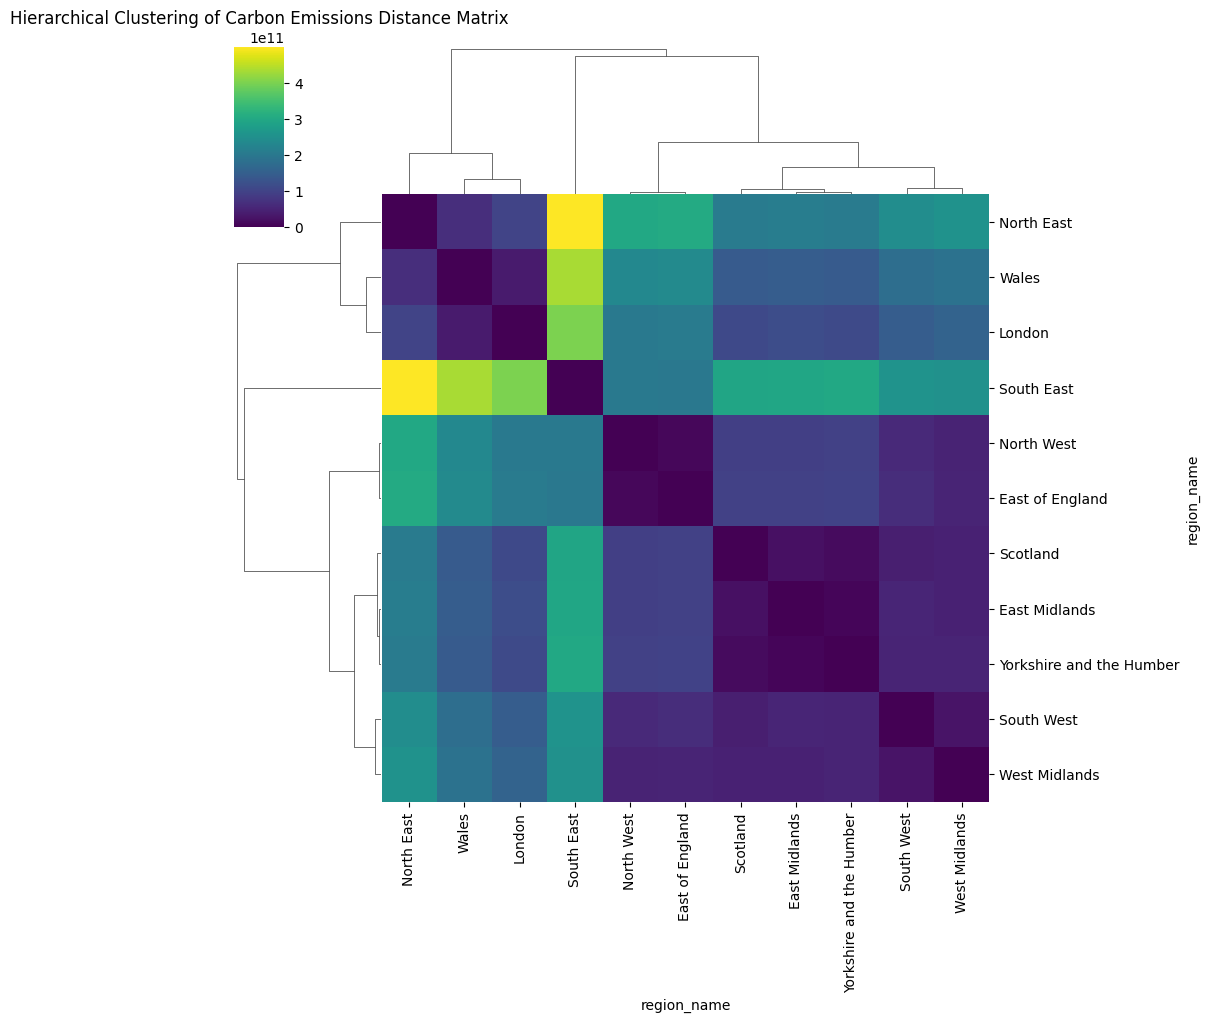

In [111]:
# Create a distance matrix for the df_carbon_region DataFrame
distance_matrix = pdist(df_carbon_region, metric='euclidean')
distance_matrix = squareform(distance_matrix)

# Add the region names to the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, columns=df_carbon_region.index, index=df_carbon_region.index)

# Create a clustermap for the distance matrix
plt.figure(figsize=(20, 10))
sns.clustermap(distance_matrix, cmap='viridis', method='ward')
plt.title('Hierarchical Clustering of Carbon Emissions Distance Matrix')
plt.show()


#### Key Inference
* Cluster Formation:
	* London, Wales, and North East cluster together but are distinct from other regions.
	* North west, East of England, Scotland, and others form another cluster.
	* South east is independent from the clusters.

* Distinct Regions:
	* London, Wales, and North East stand out due to their unique emissions profile, being part of a separate cluster.
	* They are clearly distinct from regions like South East.

* Dissimilarity:
	* Regions with yellow or green cells (e.g., London vs. West Midlands) are more dissimilar, indicating different emissions patterns.
	* This suggests significant differences in factors like urbanization, vehicle usage, or industrial activity.

* Policy Targets:
	* Regions like South East, which cluster alone and are distinct from other regions, may require policies tailored to high urban emissions.
	* Regions like North East, Wales and London could benefit from shared strategies due to their similarities

#### **Graph 16. Carbon Emission Clustering for Vehicle Emissions Patterns**

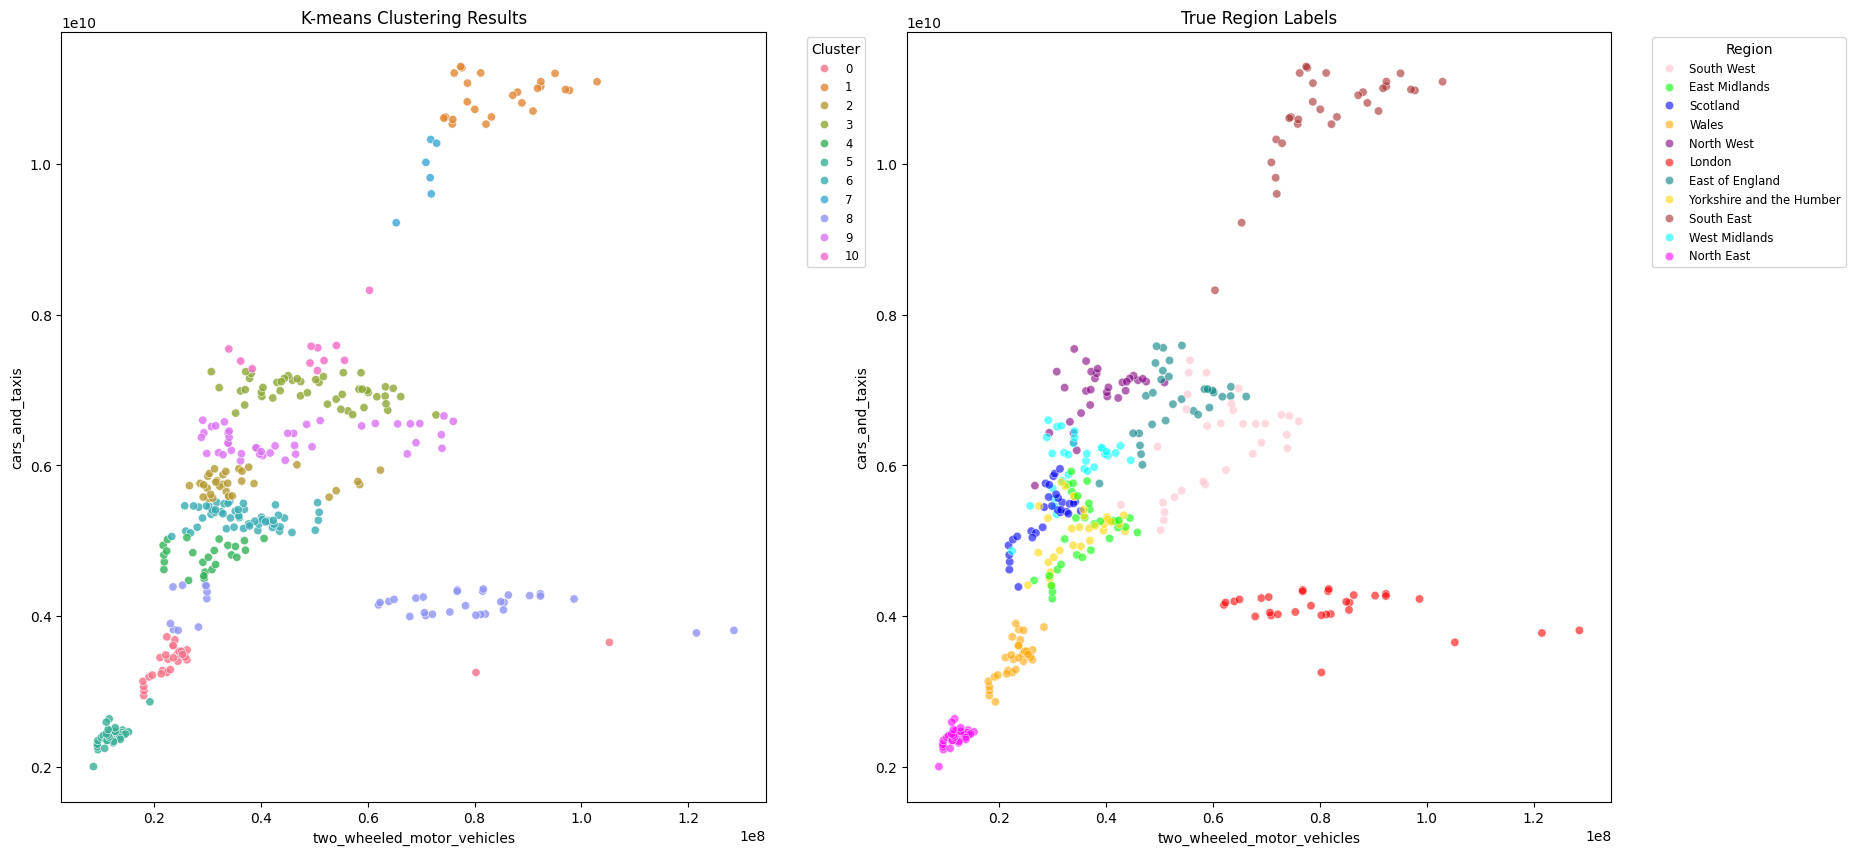

In [112]:
# Function to perform K-means clustering with attribute1 as x and attribute 2 as y, and plot the results 
def plot_carbon_emission_clustering(attribute1, attribute2):
    """
    Perform K-means clustering with attribute1 as x and attribute2 as y, and plot the results
    """
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=11, random_state=50)
    new_carbon_emission_data = carbon_emission_data.copy()
    new_carbon_emission_data['cluster'] = kmeans.fit_predict(new_carbon_emission_data[[attribute1, attribute2]])
    
    # Plot the clustering results
    plt.figure(figsize=(20, 10))

    # Plot 1: Scatter plot for attribute1 against attribute2 colored by cluster assignment
    plt.subplot(1, 2, 1)
    custom_palette = sns.color_palette("husl", n_colors=11) # Create a custom color palette for all 11 clusters
    cluster_colors = {i: custom_palette[i] for i in range(11)} # Force showing all clusters by creating a categorical color mapping
    sns.scatterplot(data=new_carbon_emission_data, x=attribute1, y=attribute2, hue='cluster', hue_order=range(11), palette=cluster_colors, alpha=0.8)
    plt.title('K-means Clustering Results')
    plt.xlabel(attribute1)
    plt.ylabel(attribute2)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # Plot 2: Scatter plot for attribute1 against attribute2 colored by true labels
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=new_carbon_emission_data, x=attribute1, y=attribute2, hue='region_name', palette=distinct_colors, alpha=0.6)
    plt.title('True Region Labels')
    plt.xlabel(attribute1)
    plt.ylabel(attribute2)
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.show()

plot_carbon_emission_clustering('two_wheeled_motor_vehicles', 'cars_and_taxis')


#### Key Inference
* The clustering algorithm generally picks up the natural groupings well, though there are some differences from the true regional boundaries
* London appears as an outlier in both plots, with significantly higher values for both metrics
    * The data points are more spread out compared to other regions, suggesting higher variability in two-wheeled motor vehicles

* There's a clear positive correlation between two-wheeled vehicles and cars/taxis across regions
* The regions form distinct clusters with minimal overlap, suggesting significant differences in vehicle usage patterns between UK regions 
* <span style="color:red"> **Regions with consistent emissions trends (e.g., North East) can benefit from uniform policies**
* <span style="color:red"> **Diverse regions (e.g., South West) may require targeted strategies for specific sub-regions based on their emission characteristics**


#### **Graph 17. Carbon Emission Clustering across Regions**

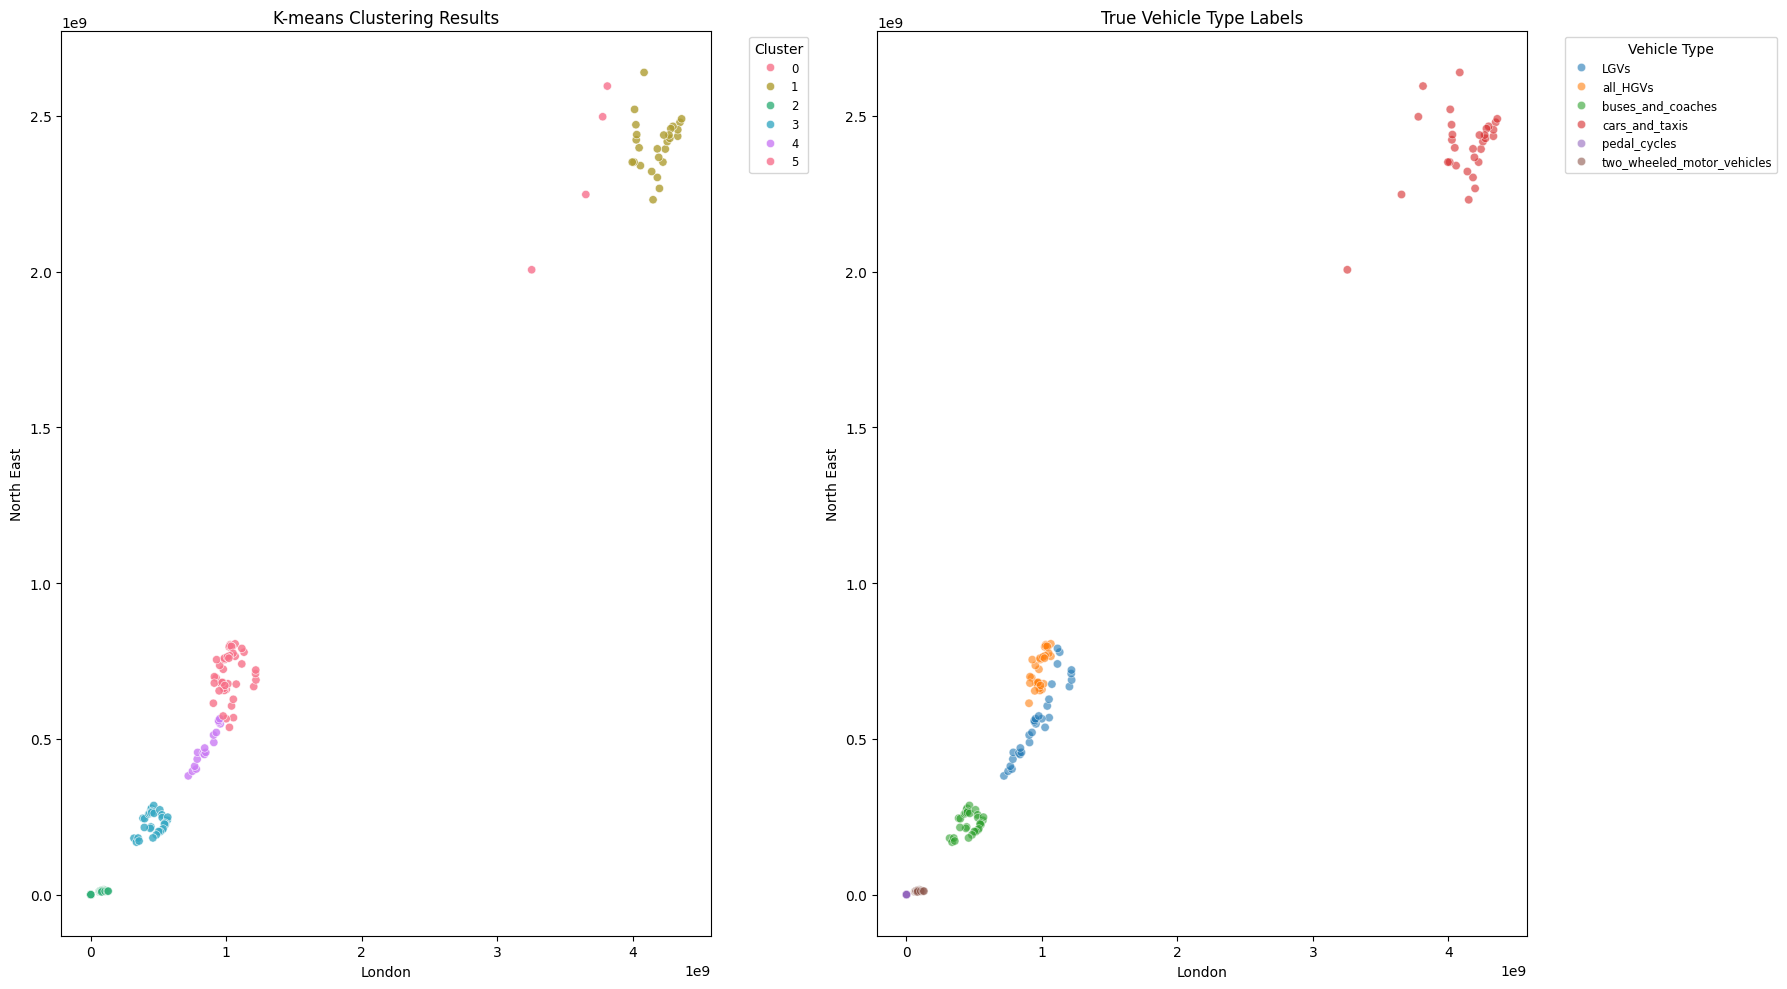

In [113]:
# Function to perform K-means clustering by vehicle types
def plot_carbon_emission_clustering_by_vehicle(region1, region2):
    """
    Perform K-means clustering by vehicle types and plot the results
    """

    # Create a new dataframe to melt carbon_emission_data
    melted_carbon_emission_data = carbon_emission_data.copy().melt(id_vars=['region_name', 'year'], var_name='vehicle_type', value_name='carbon_emission')
    
    # Drop the 'all_motor_vehicles' column
    melted_carbon_emission_data = melted_carbon_emission_data[melted_carbon_emission_data['vehicle_type'] != 'all_motor_vehicles']
    
    # Create a new dataframe to make 'vehicle_type' as indices and 'region_name' as columns while maintaining the year as a column
    pivoted_carbon_emission_data = melted_carbon_emission_data.pivot_table(index=['year', 'vehicle_type'], columns='region_name', values='carbon_emission').reset_index()
    pivoted_carbon_emission_data.columns.name = None  # Remove the column name ('vehicle_type')
    pivoted_carbon_emission_data = pivoted_carbon_emission_data.rename_axis(None, axis=1)  # Reset column axis name

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=6, random_state=50)
    pivoted_carbon_emission_data['cluster'] = kmeans.fit_predict(pivoted_carbon_emission_data[[region1, region2]])

    # Plot the results
    plt.figure(figsize=(20, 10))

    # Plot 1: Scatter plot for region1 against region2 colored by cluster assignment
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=pivoted_carbon_emission_data, x=region1, y=region2, hue='cluster', palette='husl', alpha=0.8)
    plt.title('K-means Clustering Results')
    plt.xlabel(region1)
    plt.ylabel(region2)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Move legend outside the plot

    # Plot 2: Scatter plot for region1 against region2 colored by true labels
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=pivoted_carbon_emission_data, x=region1, y=region2, hue='vehicle_type', alpha=0.6)
    plt.title('True Vehicle Type Labels')
    plt.xlabel(region1)
    plt.ylabel(region2)
    plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Move legend outside the plot

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the legends outside the plots

    plt.show()


plot_carbon_emission_clustering_by_vehicle('London', 'North East')

#### Key Inference
* Cars and taxis (shown in red on right) have the highest numbers in both London and North East
* Due to the difference of the scales on x-axis and y-axis, emissions in London (x-axis) tend to be higher across all vehicle types compared to the North East (y-axis)
* Clusters of vehicle types like buses and coaches and cars and taxis align with higher emissions, while two-wheeled motor vehicles and pedal cycles are concentrated near lower emissions values
* While London requires urban-centric policies addressing high congestion and vehicle use, the North East may benefit from more regional infrastructure development to maintain lower emission levels

# **Section 2. Cycle Data Analysis**

## **Cycling in London**
To study cycling activity in London and decide ways to increase it, as it is more environmentally friendly than other modes of transportation (e.g. cars etc.), we collected public Transport for London (TfL) cycling data using web scraping. These data are collected as part of the "Active Counts Programme", which has started from 2014 onwards. This site contains full documentation of the data collection methodology: https://cycling.data.tfl.gov.uk/. Basically, TfL counts cycles on a constant panel of 1451 locations, which were drawn randomly in the beginning of the programme and are considered representative of the cyclable network in London. The counting is performed mainly through the use of video recording, which are then manually reviewed.

In addition to that, we complemented the scraped data with weather data (from 2014 onwards) which we collected through the "Meteostat" API. This will facilitate us to examine if weather condtions influence cycling activity and how. 



## **I. Weather data collection**

We use meteostat's API to collect historical weather data for the whole period under consideration (2014-2024), granulated at the daily level. The variables are average temperature (tavg), maximum and minimum temperature (tmax and tmin), precipitation total in mm (prcp), snow depth in mm (snow), average wind direction in degrees (wdir), average wind speed in km/h (wspd), peak wind gust in km/h (wpgt), average sea-level air pressure in hPa (pres) and daily sunshine total in minutes (tsun). 

**Abbreviations**:

- **tavg**: Average Temperature  
- **tmax**: Maximum Average Temperature  
- **tmin**: Minimum Average Temperature  
- **prcp**: Precipitation Total in mm  
- **snow**: Snow Depth in mm  
- **wdir**: Average Wind Direction in Degrees  
- **wspd**: Average Wind Speed in km/h  
- **wpgt**: Peak Wind Gust in km/h  
- **pres**: Average Sea-Level Air Pressure in hPa  
- **tsun**: Daily Sunshine Total in Minutes 



In [114]:
# Define location and time range
london = Point(51.509865, -0.118092)
start = datetime(2014, 1, 1)
end = datetime(2024, 12, 31)

# Get data
data = Daily(london, start, end)
data = data.fetch()


display(data)

tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2014-01-01  9.80  7.00 12.00  5.30   NaN 188.00 25.00   NaN  992.50   NaN
2014-01-02  9.70  7.00 11.00 13.70   NaN 219.00 19.40   NaN  993.10   NaN
2014-01-03  9.70  8.00 11.00  2.50   NaN 218.00 27.10   NaN  994.10   NaN
2014-01-04  8.70  5.00 10.00  7.60   NaN 210.00 20.80   NaN  993.50   NaN
2014-01-05  7.00  4.00 12.00  9.90   NaN 210.00 16.80   NaN  999.80   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-12-27  5.90  5.40  7.00  0.00   NaN 118.00  4.40 13.00 1033.20   NaN
2024-12-28  4.50  3.90  5.10  0.00   NaN 237.00  6.60 18.50 1029.50   NaN
2024-12-29  5.30  4.30  6.50  0.00   NaN 247.00 10.20 24.10 1029.80   NaN
2024-12-30  6.30  5.20  7.80  0.00   NaN 231.00 14.60 31.50 1027.90   NaN
2024-12-31  8.60  6.80 10.30  0.00   NaN 220.00 23.10 51.80 1020.50   NaN

[4018 rows x 10 columns]

## **II. Cycling data collection**

We used web scraping to collect all the available Tfl cycle count data that are available in this site as .csv files: https://cycling.data.tfl.gov.uk/. This specific site is implemented with JavaScript, which dynamically loads the data into the HTML table, after fetching them from an S3 bucket (a type of cloud storage provided by AWS). So, using scraping on this site will return empty lists since the HTML table does not directly contain the data. For that reason, we decided to scrape the data directly from the S3 bucket URL directly (https://s3-eu-west-1.amazonaws.com/cycling.data.tfl.gov.uk/). This bucket serves an XML file that lists all the files and folders available for download, and so it is easier and more straightforward to collect the data. The two cells of code below implement scraping and then combine all the collected data into a single dataframe.

Below we include a table with all the necessary descriptions of the variables included in the Tfl datasets that we scraped (although we are not going to use all of them in the analyses below).

| **Field Name** | **Format**           | **Description**                                                                                                                                                                                                                      |
|-----------------|----------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Year**       | YYYY QQ [season] (Mmm-Mmm) | Indicates the wave (quarter or season) that the counts represent. This may differ from the date that the counts took place if adjustment factors have been applied. This is the only ‘date’ filter that can be applied to the data.   |
|                 |                      | - **YYYY**: Year, e.g., 2018.                                                                                                                                                                                                       |
|                 |                      | - **QQ**: Calendar quarter, e.g., Q2.                                                                                                                                                                                               |
|                 |                      | - **[season]**: ‘spring’ for Q2, ‘autumn’ for Q4, blank otherwise.                                                                                                                                                                  |
|                 |                      | - **(Mmm-Mmm)**: Months in the quarter, e.g., (Apr-Jun).                                                                                                                                                                            |
| **UnqID**       | ML0000               | Unique ID identifying the count location. ML stands for ‘monitoring location’. Numbers are continuous from 0001 onwards.                                                                                                            |
|                 |                      | Revised IDs were first published in the early 2024 release. The ‘Count locations’ file includes old IDs for reference.                                                                                                              |
| **Date**        | DD-MM-YYYY           | Date the counts took place. May not correspond to the wave if adjustment factors were applied. Provided for reference only; should not be used to filter the dataset.                                                                 |
| **Weather**     | Text                 | Description of the weather at the time and location of the count.                                                                                                                                                                   |
| **Time**        | HH:MM:SS             | Start time of the quarter-hour represented by the count.                                                                                                                                                                            |
|                 |                      | - **HH**: Hour (24-hour format).                                                                                                                                                                                                    |
|                 |                      | - **MM**: Minute (00, 15, 30, 45).                                                                                                                                                                                                  |
|                 |                      | - **SS**: Seconds (always 00).                                                                                                                                                                                                      |
|                 |                      | Example: 13:45:00 represents flows between 13:45 and 14:00.                                                                                                                                                                         |
| **Day**         | Weekday/Weekend      | Indicates whether the count was done on a weekday or weekend.                                                                                                                                                                       |
| **Round**       | Character            | Character indicating the iteration (‘round’) of the count location-wave combination.                                                                                                                                                |
|                 |                      | - A to I: Weekdays.                                                                                                                                                                                                                 |
|                 |                      | - T to Y: Weekends.                                                                                                                                                                                                                 |
| **Dir**         | Northbound/ Southbound/ Eastbound/ Westbound | Direction of travel of the flows counted.                                                                                                                                                                                            |
| **Path**        | Text                 | Part of the road where the counts took place.                                                                                                                                                                                       |
|                 |                      | When a direction is indicated, it refers to the side of the road (expected travel direction if it’s a bidirectional ‘drive on the left’ road), not the travel direction of vehicles on that path (given by the ‘Dir’ field).         |
| **Mode**        | Text                 | Road user class being counted.                                                                                                                                                                                                      |
| **Count**       | Integer              | Total flow corresponding to the above parameters.                                                                                                                                                                                   |


In [115]:

# S3 bucket URL
s3_url = "https://s3-eu-west-1.amazonaws.com/cycling.data.tfl.gov.uk/"

# Fetch the bucket listing
response = requests.get(s3_url)

# Parse the XML response
soup = BeautifulSoup(response.content, "xml")

# Find all file keys and construct URLs
files = soup.find_all("Key")

urls = []
for file in files:
    if 'ActiveTravelCountsProgramme' in file.text.strip():
        encoded_path = quote(file.text.strip())
        urls.append(s3_url + encoded_path)
    else:
        continue
    
urls = urls[5:]

dataframes = {}
for url in urls:
    response = requests.get(url)
    dataframes[url] = pd.read_csv(StringIO(response.text), low_memory=False)

In [116]:
# Combining all the datasets into a single dataset

all_datasets = pd.DataFrame()
for i in dataframes:
    all_datasets = pd.concat([all_datasets, dataframes[i]], axis=0)

all_datasets.head(100)

Wave  SiteID        Date Weather      Time      Day Round  \
0   2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  06:00:00  Weekday     A   
1   2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  06:15:00  Weekday     A   
2   2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  06:30:00  Weekday     A   
3   2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  06:45:00  Weekday     A   
4   2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  07:00:00  Weekday     A   
..                ...     ...         ...     ...       ...      ...   ...   
95  2014 Q1 (Jan-Mar)  ML0001  24/01/2014     Dry  13:45:00  Weekday     A   
96  2014 Q1 (Jan-Mar)  ML0001  22/01/2014     Dry  14:00:00  Weekday     A   
97  2014 Q1 (Jan-Mar)  ML0001  22/01/2014     Dry  14:15:00  Weekday     A   
98  2014 Q1 (Jan-Mar)  ML0001  22/01/2014     Dry  14:30:00  Weekday     A   
99  2014 Q1 (Jan-Mar)  ML0001  22/01/2014     Dry  14:45:00  Weekday     A   

     Direction Path            Mode  Count  
0   Northbound  NaN  Private cycles   0.00  
1   Northbound  NaN  Private cycles  15.00  
2   Northbound  NaN  Private cycles  35.00  
3   Northbound  NaN  Private cycles  59.00  
4   Northbound  NaN  Private cycles  73.00  
..         ...  ...             ...    ...  
95  Southbound  NaN  Private cycles   3.00  
96  Southbound  NaN  Private cycles   8.00  
97  Southbound  NaN  Private cycles   8.00  
98  Southbound  NaN  Private cycles   5.00  
99  Southbound  NaN  Private cycles   7.00  

[100 rows x 11 columns]

In [117]:
# Converting the Data variable to datetime

all_datasets['Date'] = pd.to_datetime(all_datasets['Date'],dayfirst=True)


## **III. Final notes on the dataset**
After collecting and merging the data, we combine them in the two code cells below with the previously collected weather data and then export this finalised dataset as a csv file. The dataset consists of 13.712.100 rows and 20 columns. Due to its large size we did not upload it on Github since payment is required for uploading such large files.

In [118]:
all_datasets.set_index('Date',inplace=True)
all_datasets = all_datasets.merge(data, how='left', left_index=True,right_index=True)
all_datasets

Wave  SiteID Weather      Time      Day Round  \
Date                                                                     
2014-01-24  2014 Q1 (Jan-Mar)  ML0001     Dry  06:00:00  Weekday     A   
2014-01-24  2014 Q1 (Jan-Mar)  ML0001     Dry  06:15:00  Weekday     A   
2014-01-24  2014 Q1 (Jan-Mar)  ML0001     Dry  06:30:00  Weekday     A   
2014-01-24  2014 Q1 (Jan-Mar)  ML0001     Dry  06:45:00  Weekday     A   
2014-01-24  2014 Q1 (Jan-Mar)  ML0001     Dry  07:00:00  Weekday     A   
...                       ...     ...     ...       ...      ...   ...   
2024-04-18     2024 W1 spring  ML1451     Wet  20:45:00  Weekday     A   
2024-04-18     2024 W1 spring  ML1451     Wet  21:00:00  Weekday     A   
2024-04-18     2024 W1 spring  ML1451     Wet  21:15:00  Weekday     A   
2024-04-18     2024 W1 spring  ML1451     Wet  21:30:00  Weekday     A   
2024-04-18     2024 W1 spring  ML1451     Wet  21:45:00  Weekday     A   

             Direction         Path            Mode  Count  tavg  tmin  tmax  \
Date                                                                           
2014-01-24  Northbound          NaN  Private cycles   0.00  6.20  4.00  8.00   
2014-01-24  Northbound          NaN  Private cycles  15.00  6.20  4.00  8.00   
2014-01-24  Northbound          NaN  Private cycles  35.00  6.20  4.00  8.00   
2014-01-24  Northbound          NaN  Private cycles  59.00  6.20  4.00  8.00   
2014-01-24  Northbound          NaN  Private cycles  73.00  6.20  4.00  8.00   
...                ...          ...             ...    ...   ...   ...   ...   
2024-04-18  Southbound  Shared path     Pedestrians   1.00  8.00  3.40 12.30   
2024-04-18  Southbound  Shared path     Pedestrians   0.00  8.00  3.40 12.30   
2024-04-18  Southbound  Shared path     Pedestrians   3.00  8.00  3.40 12.30   
2024-04-18  Southbound  Shared path     Pedestrians   1.00  8.00  3.40 12.30   
2024-04-18  Southbound  Shared path     Pedestrians   0.00  8.00  3.40 12.30   

            prcp  snow   wdir  wspd  wpgt    pres  tsun  
Date                                                     
2014-01-24  1.50   NaN 164.00 11.80   NaN 1013.80   NaN  
2014-01-24  1.50   NaN 164.00 11.80   NaN 1013.80   NaN  
2014-01-24  1.50   NaN 164.00 11.80   NaN 1013.80   NaN  
2014-01-24  1.50   NaN 164.00 11.80   NaN 1013.80   NaN  
2014-01-24  1.50   NaN 164.00 11.80   NaN 1013.80   NaN  
...          ...   ...    ...   ...   ...     ...   ...  
2024-04-18  0.30   NaN 310.00 14.80 31.50 1021.40   NaN  
2024-04-18  0.30   NaN 310.00 14.80 31.50 1021.40   NaN  
2024-04-18  0.30   NaN 310.00 14.80 31.50 1021.40   NaN  
2024-04-18  0.30   NaN 310.00 14.80 31.50 1021.40   NaN  
2024-04-18  0.30   NaN 310.00 14.80 31.50 1021.40   NaN  

[13712100 rows x 20 columns]

## **IV. Data Analysis**

Below we analyze the collected cycle counts data for some trends and also try to make some inferences about the factors the explain cycling. We finalize this part with some recommendations based on our findings.

In [119]:
cycle_data = all_datasets

### **Graph 18. Private cycles vs cycle hire bikes**

In the graph below we visualize the usage of cycle hire bikes and private cycles (as a percentage) from 2014 until the end of 2021. The reason that we exclude 2022-2024 is because from 2022 onwards TfL does not distinguish between these two categories but combines them both under one category. In addition, the reason why both the percentages of both modes do not add up to 100 is because TfL also counts other modes as well and includes them in the data like cars, buses etc.

It is obvious from the graph below that, although with some yearly variations, that private cycles are used consitently and significantly more than cycle hire bikes.  

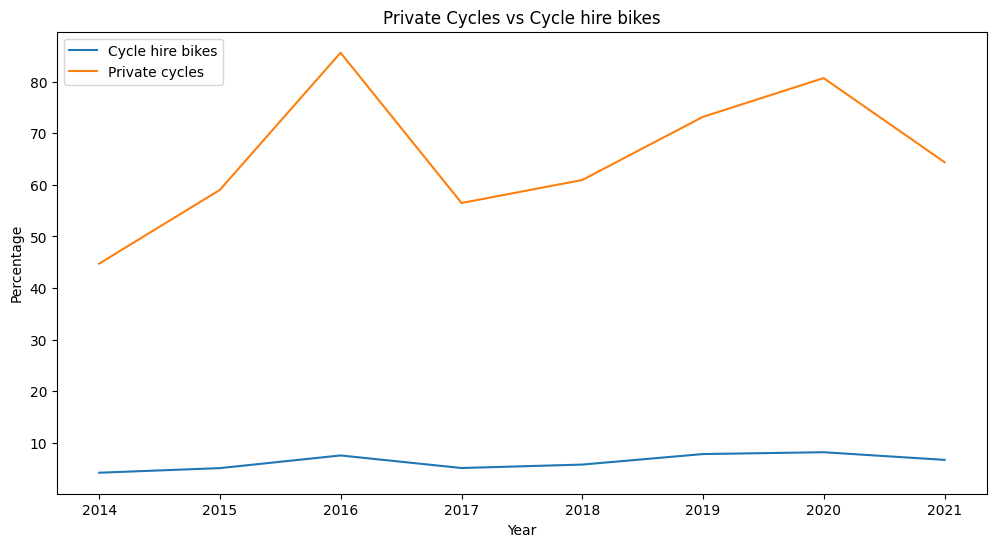

In [120]:
pro_2022_sub = cycle_data[cycle_data.index<'2022-01-01'].copy()

# Converting to year in order to calculate yearly percentages
pro_2022_sub.index = pd.to_datetime(pro_2022_sub.index)
pro_2022_sub.index = pro_2022_sub.index.to_period('Y')


# Calculating percentages
pro_2022_sub['Total_Count_Mode'] = pro_2022_sub.groupby(['Mode', 'Date'])['Count'].transform('sum')
pro_2022_sub['Total_Count_Overall'] = pro_2022_sub.groupby(['Date'])['Count'].transform('sum')
pro_2022_sub['Percentage'] = (pro_2022_sub['Total_Count_Mode'] / pro_2022_sub['Total_Count_Overall']) * 100


# filtering out hires and private
hires = pro_2022_sub.loc[pro_2022_sub['Mode'].isin(['Cycle hire bikes'])]
private = pro_2022_sub.loc[pro_2022_sub['Mode'].isin(['Private cycles'])]


# Convert the Period index to datetime format
hires.index = hires.index.to_timestamp()
private.index = private.index.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(hires.index, hires['Percentage'], label='Cycle hire bikes')
plt.plot(private.index, private['Percentage'], label='Private cycles')
plt.title('Private Cycles vs Cycle hire bikes')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend()

### **Graph 19. Weather and cycle counts correlations by season**

In the graph below we visualise the correlation of the weather variables and the cycle counts. We do this for every season of the year to take into account the seasonality element, since we assume that weather is going to affect differentely bike usage depending on the season. In addition we transformed the count variable on the log scale to facilitate visualisation, since there are very large values as well as outliers.

From the plots below we see that during autumn the variable that correlates the most (and positively) with bicycle counts is temperature (average, minimum and maximum). During winter, wind direction seems to present the highest, and negative, correlation. During spring, again temperature correlates highly and positively with bicycle counts and finally during summer the strongest correlation with bicycle coutns appears to be the wind peak gust, with higher peak leading to lower bicycle counts.


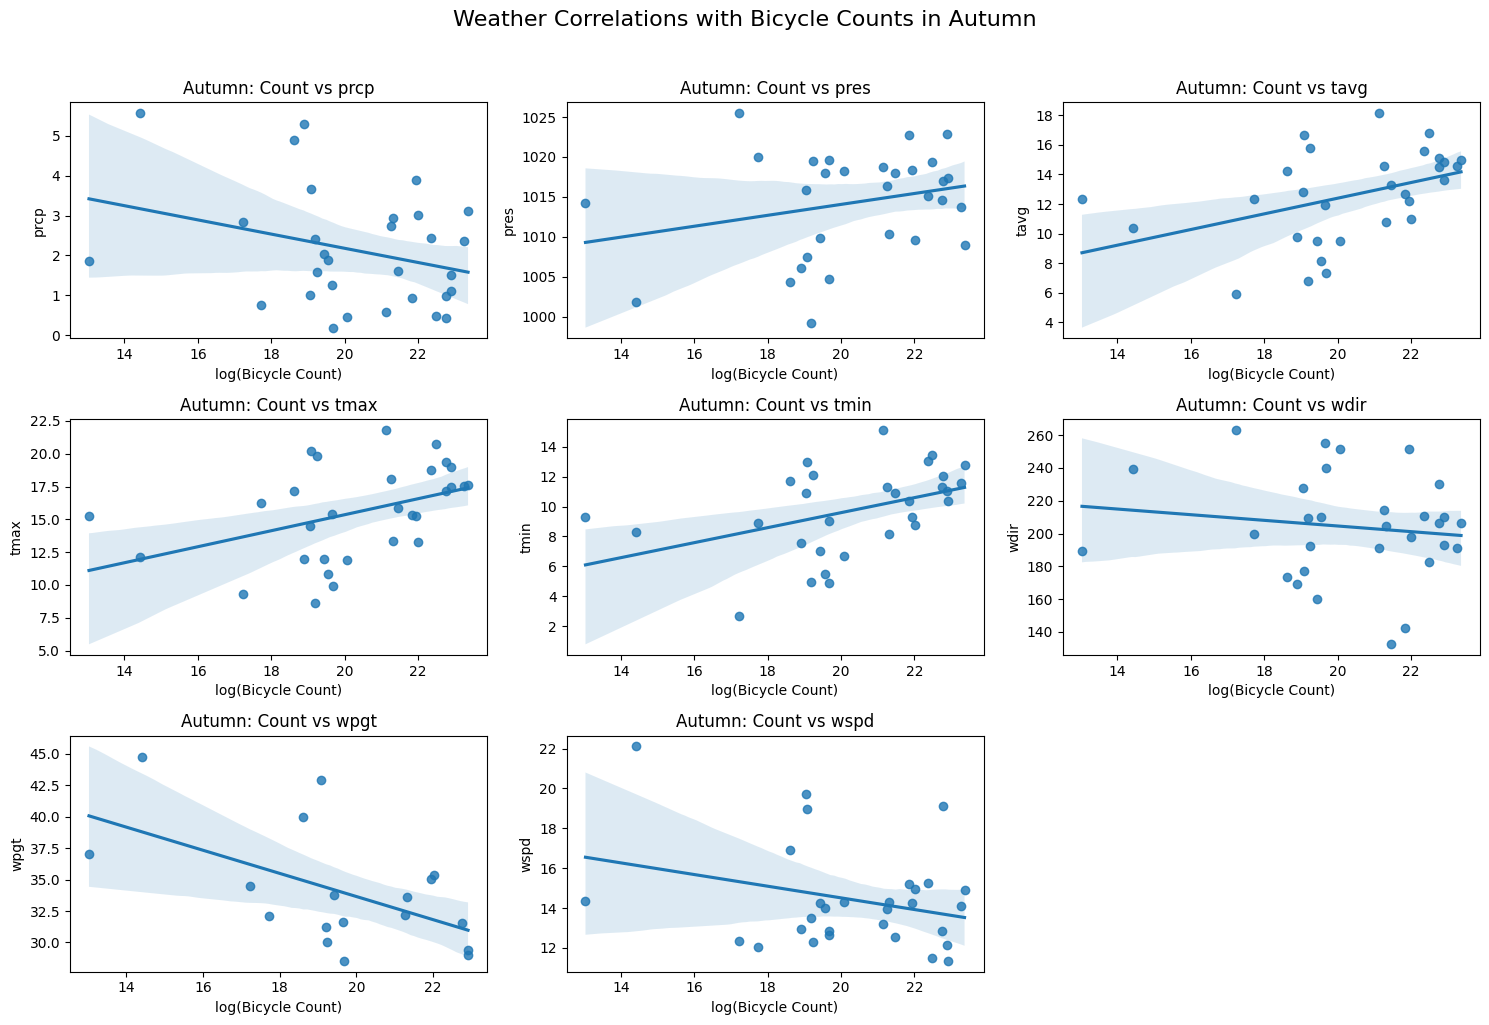

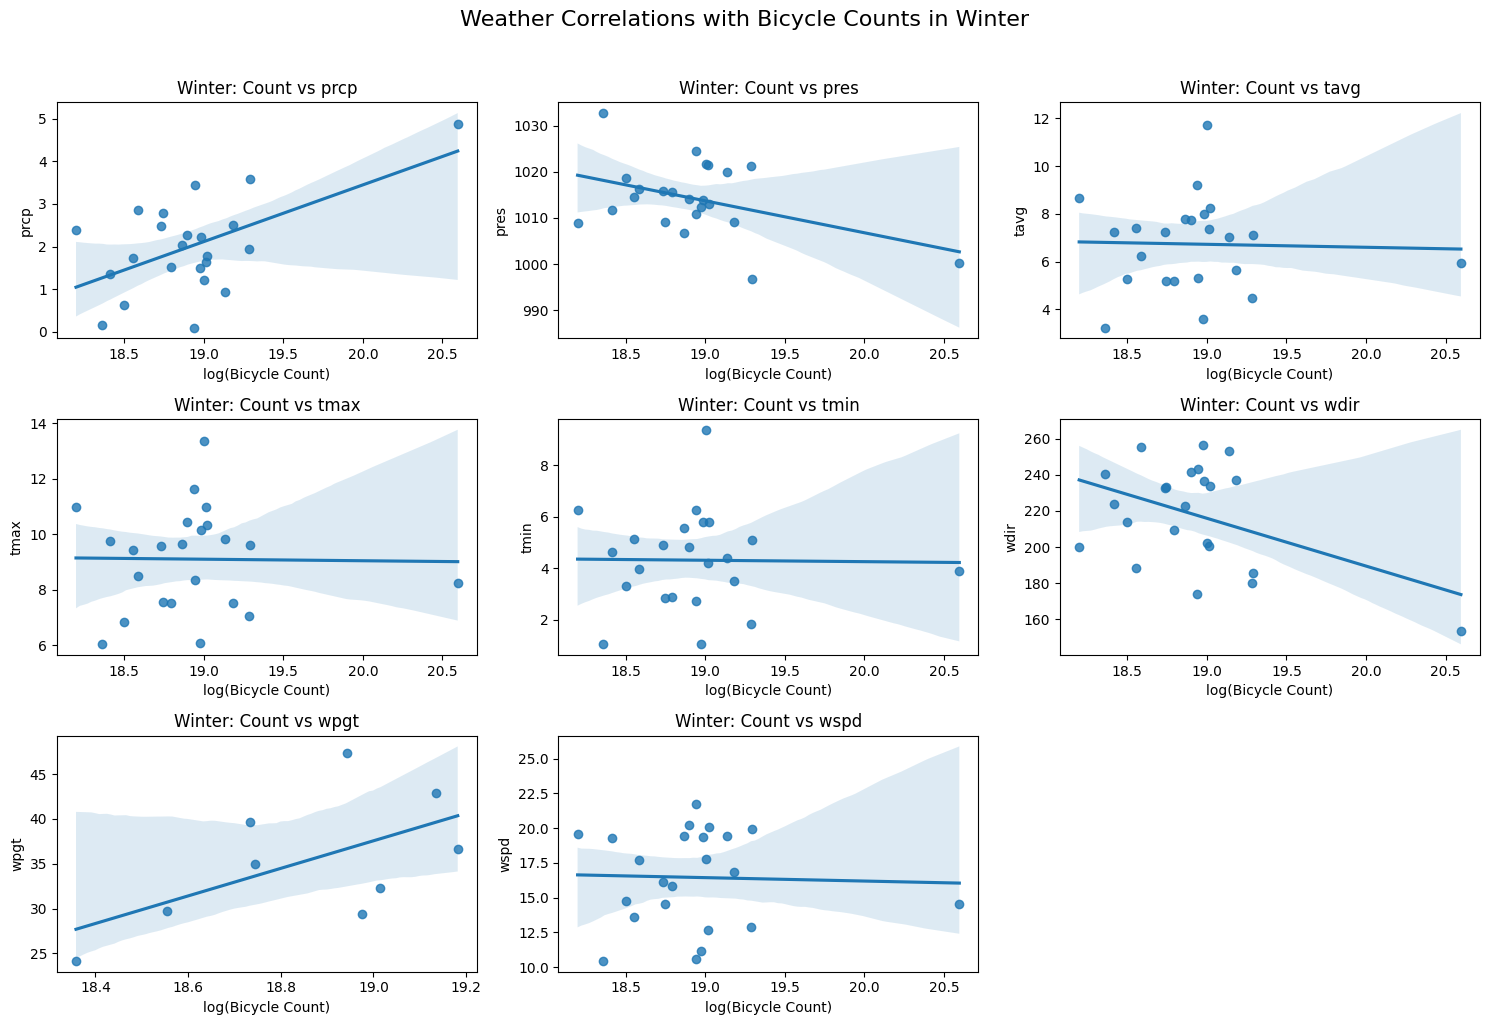

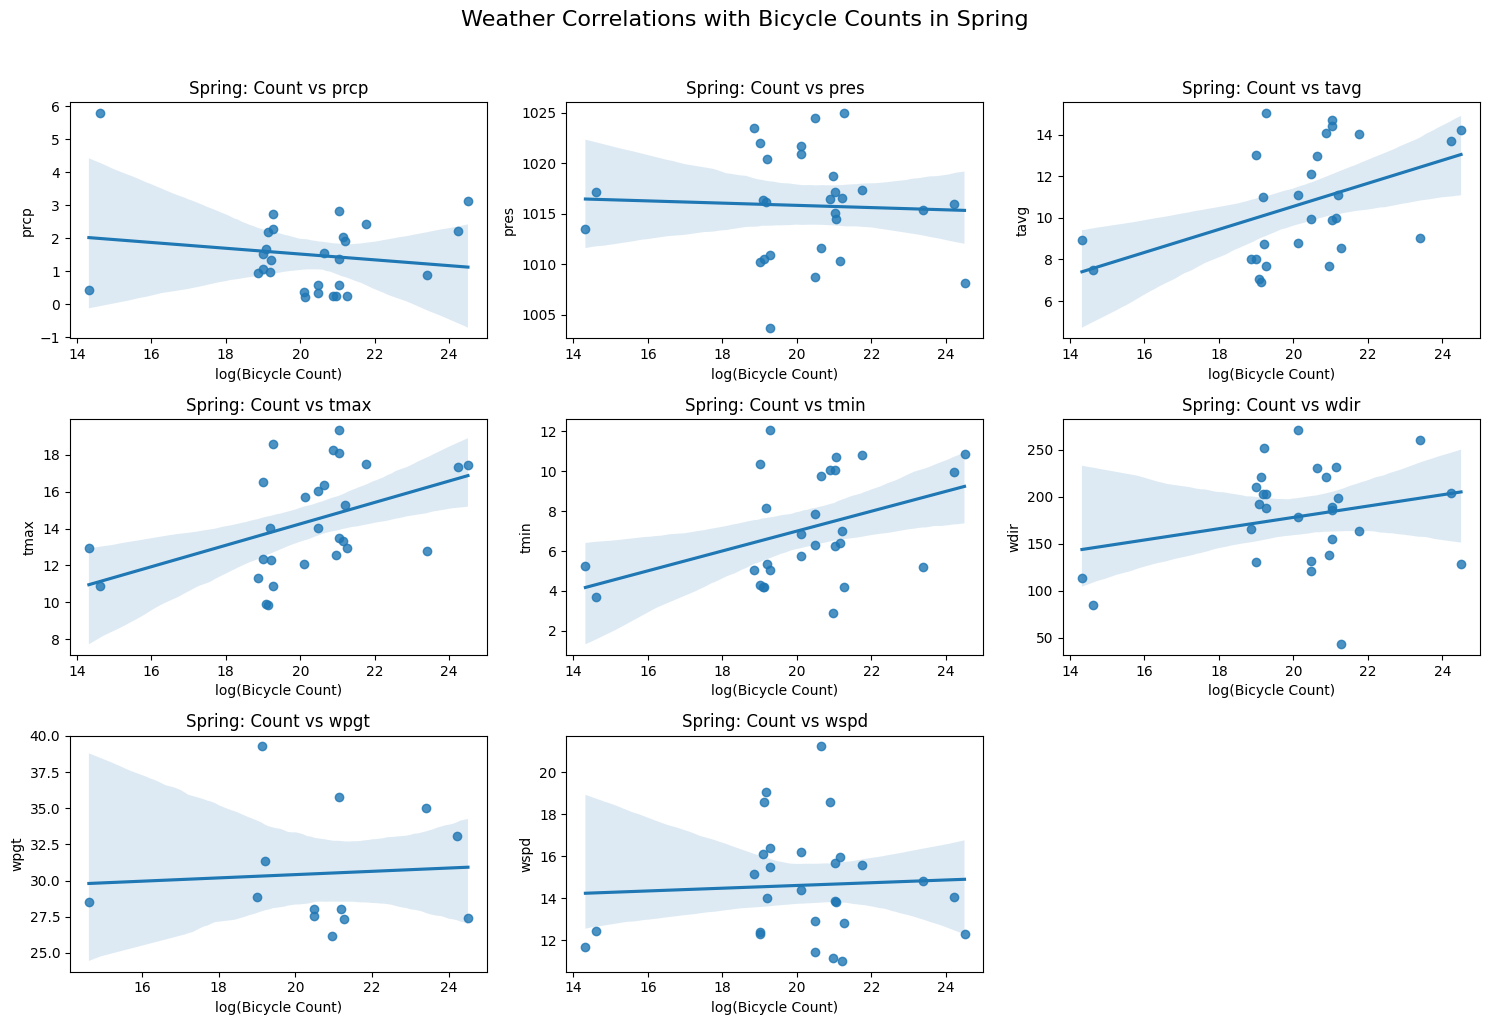

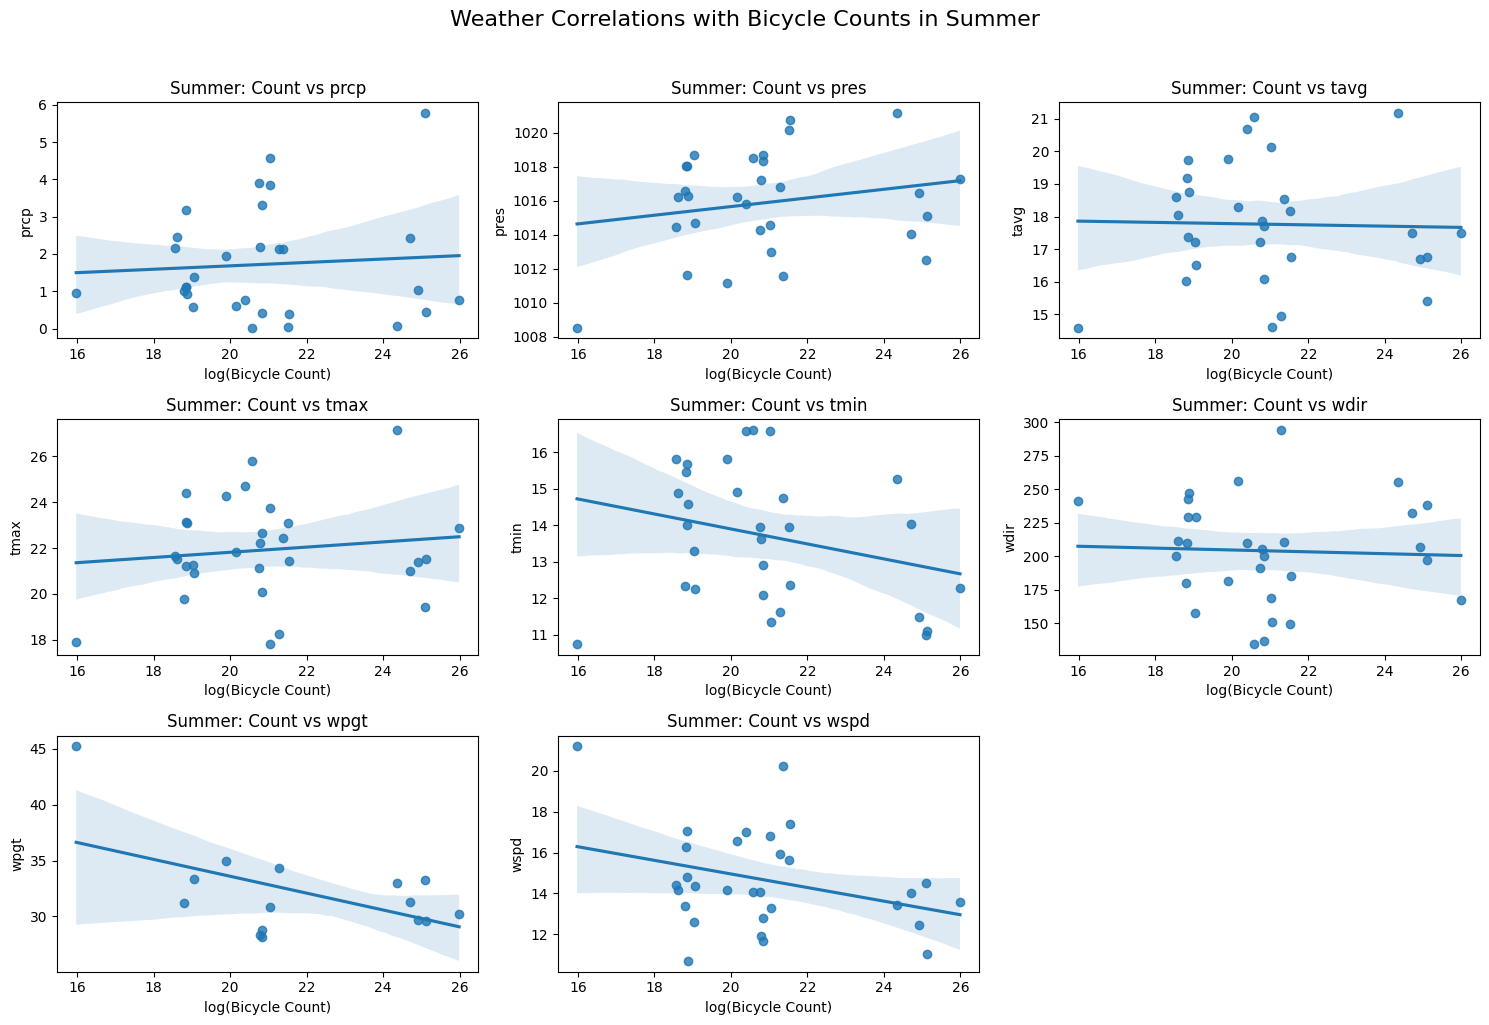

In [121]:
cycle_data_copy_1 = cycle_data.copy()
cycle_data_copy_1.index = pd.to_datetime(cycle_data_copy_1.index)

# Summing counts on the daily level
cycle_data_copy_1['Count'] = cycle_data_copy_1.groupby(cycle_data_copy_1.index)['Count'].transform('sum')


# Filtering specific cycle categories
filtered = cycle_data_copy_1[cycle_data_copy_1['Mode'].isin(['Private cycles', 'Cycle hire bikes','Cycles','Conventional cycles'])]


# Averaging on the monthly level
filtered.index = filtered.index.to_period('M')

# Keeping weather variables and calculating the monthly mean of them
filtered_new =  filtered.iloc[:,10:19].drop(columns='snow').groupby(level=0).mean()

# Monthly sum of count variable
filtered_new['Count'] = filtered.iloc[:,9].groupby(level=0).sum()


# Log scale 
filtered_new['Count'] = np.log(filtered_new['Count'])



# Creating season variable
filtered_new['Season'] = filtered_new.index.month.map(lambda x: 'Autumn' if x in [9, 10, 11] else
                                              'Winter' if x in [12,1,2] else
                                              'Spring' if x in [3,4,5] else
                                              'Summer' if x in [6,7,8] else 'Unknown')


# Create regplots for each season
def plot_season_correlations(filtered_new, season_name):
    # Filter data for the specific season
    filtered_season = filtered_new[filtered_new['Season'] == season_name]
    
    # Weather variable names
    variables = filtered_new.columns.difference(['Count', 'Season'])  # Exclude 'Count' and 'Season'

    # Create a grid of regplots
    plt.figure(figsize=(15, 10))
    for i, var in enumerate(variables, start=1):
        plt.suptitle(f"Weather Correlations with Bicycle Counts in {season_name}", fontsize=16, y=1.02)
        plt.subplot(3, 3, i)
        sns.regplot(x='Count', y=var, data=filtered_season)
        plt.title(f"{season_name}: Count vs {var}")
        plt.xlabel('log(Bicycle Count)')
    plt.tight_layout()
    plt.show()
    

# Generate regplots for all seasons
seasons = ['Autumn', 'Winter', 'Spring', 'Summer']
for season in seasons:
     plot_season_correlations(filtered_new, season)

### **Graph 20. Cycle counts by season**

Below we visualise the bicycle log counts per season. By comparing the medians of the boxplots it is obvious that the highest bicycle usage happens during summer and the lowest during winter.

Text(0.5, 1.0, 'Bicycle counts by season')

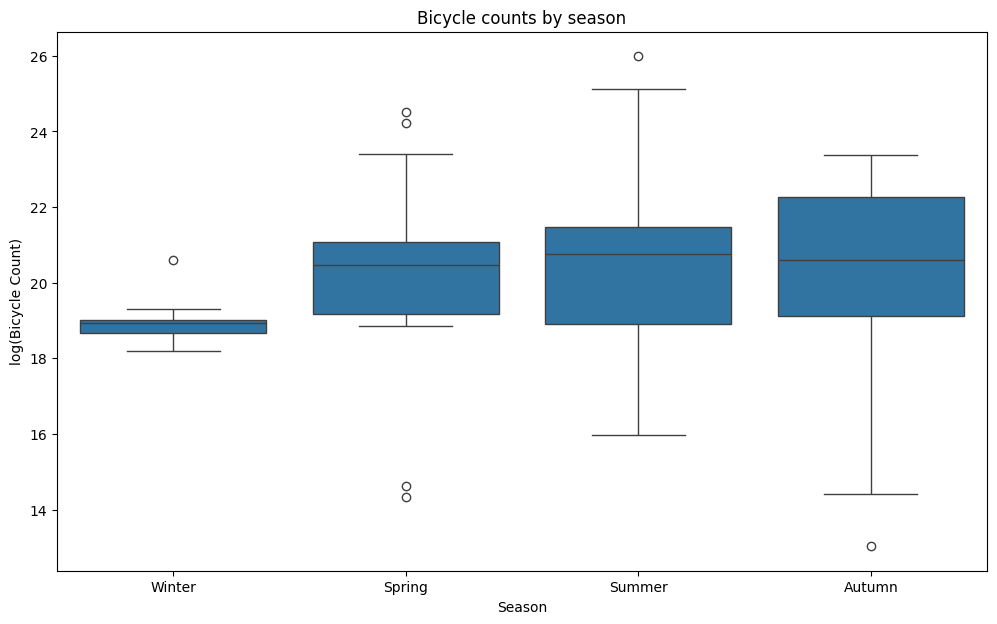

In [122]:
# Boxplots
plt.figure(figsize=(12,7))
sns.boxplot(filtered_new,x='Season',y='Count')
plt.ylabel('log(Bicycle Count)')
plt.title('Bicycle counts by season')


### **Regression**

Below we prepared the data and then implemented a poisson regression with the count variable as a response in order to examine which factors explain more the bicycle usage. Since we are dealing with count data we decided to model the response as belonging to the poisson distribution. The predictors we used are date  (years) as a variable (and this would make our model a fixed effects one which accounts for unobserved heterogeneity due to dates), a subset of the weather variables (wind peak gust, precipitation and average temperature), dummies for seasons, the interactions between seasons and each of the weather variables, dummies for time period of the day and finally a dummy for weekday vs weekend. With respect to the weather variables we decided to only keep the aforementioned three because the other ones correlated highly with these and so by including them would cause multicollinearity issues. Also, in order to decide on which weather variables to include we used a correlation heatmap as it is evident from below. Finally, we estimated clustered standard errors using Date as a grouping variable, since this makes our confidence intervals more robust and capturing heterogeneity attributed to several time points (years in our case).

| **Variable**                          | **Description**                                                                 |
|---------------------------------------|---------------------------------------------------------------------------------|
| **Bicycle Counts (Response variable)**| Counts of bicycles (daily level)                              |
| **wpgt**                              | Peak Wind Gust in km/h (daily level).                              |
| **wpgt:Season_Winter**                | Interaction of peak wind gust with winter season.                               |
| **wpgt:Season_Summer**                | Interaction of peak wind gust with summer season.                               |
| **wpgt:Season_Spring**                | Interaction of peak wind gust with spring season.                               |
| **prcp**                              | Precipitation Total in mm (daily level).                                                     |
| **prcp:Season_Winter**                | Interaction of precipitation total with winter season.                          |
| **prcp:Season_Summer**                | Interaction of precipitation total with summer season.                          |
| **prcp:Season_Spring**                | Interaction of precipitation total with spring season.                          |
| **tavg**                              | Average Temperature (daily level).                              |
| **tavg:Season_Winter**                | Interaction of average temperature with winter season.                          |
| **tavg:Season_Summer**                | Interaction of average temperature with summer season.                          |
| **tavg:Season_Spring**                | Interaction of average temperature with spring season.                          |
| **Date**                              | Date (Years).                 |
| **Season_Winter**                     | Is Winter season (vs Autumn).                     |
| **Season_Summer**                     | Is Summer season (vs Autumn).                     |
| **Season_Spring**                     | Is Spring season (vs Autumn).                     |
| **time_period_Night**                 | Is Night period (vs Afternoon).                                 |
| **time_period_Morning**               | Is morning period (vs Afternoon).                               |
| **time_period_Evening**               | Is evening period (vs Afternoon).                               |
| **Day_Weekday**                       | Is Weekday (vs Weekend).                            |


In [123]:
# Preparing for regression 

# Filtering specific cycle categories
reg_data = cycle_data_copy_1[cycle_data_copy_1['Mode'].isin(['Private cycles', 'Cycle hire bikes','Cycles','Conventional cycles'])].copy()

# Convert the time column to datetime
reg_data['time'] = pd.to_datetime(reg_data['Time'], format='%H:%M:%S').dt.time


# Create a time period column
reg_data['time_period'] = reg_data['time'].apply(lambda x: 'Morning' if '05:00:00' <= x.strftime('%H:%M:%S') < '12:00:00' else
        'Afternoon' if '12:00:00' <= x.strftime('%H:%M:%S') < '17:00:00' else
        'Evening' if '17:00:00' <= x.strftime('%H:%M:%S') < '21:00:00' else
        'Night')


# Creating dummies
dummies = pd.get_dummies(reg_data.iloc[:,[4,6]])
reg_data = pd.concat([reg_data,dummies],axis=1)



#Drop columns
reg_data.drop(columns=['Wave','SiteID','Weather','Time','Day','Direction','Path','Mode','tsun','snow','Round','time'],inplace=True)


# Creating season variable
reg_data['Season'] = reg_data.index.month.map(lambda x: 'Autumn' if x in [9, 10, 11] else
                                              'Winter' if x in [12,1,2] else
                                              'Spring' if x in [3,4,5] else
                                              'Summer' if x in [6,7,8] else 'Unknown')




# Deduplicate
reg_data.drop_duplicates(inplace=True)


### **Graph 21. Correlations between weather variables**

Text(0.5, 1.0, 'Correlations between weather variables')

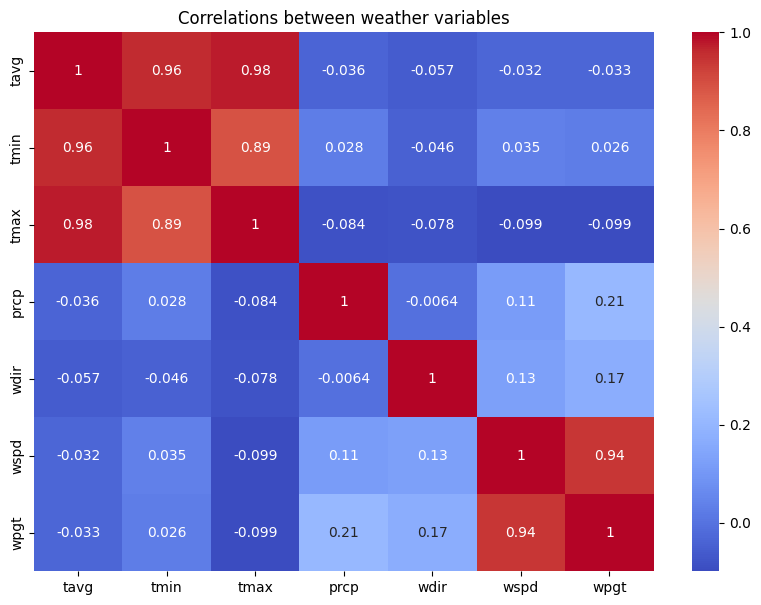

In [124]:
# Which weather variables to include

corrs  =  reg_data.iloc[:,1:8].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corrs,cmap='coolwarm',annot=True)
plt.title('Correlations between weather variables')


In [125]:
# Poisson regression

# Drop NA's
reg_data.dropna(inplace=True)

#Convert target to numeric
reg_data['Count'] = reg_data['Count'].astype(int)

# Get dummies
reg_data = pd.get_dummies(reg_data, columns=['time_period','Season'], drop_first=True)


# Standardize
scaler = StandardScaler()
scaled_columns = reg_data.columns.difference(['Count','time_period_Evening','time_period_Morning','time_period_Night','Day_Weekday','Day_Weekend','Season_Summer','Season_Winter','Season_Spring', 'Direction_Southbound','Direction_Eastbound','Direction_Northbound','Direction_Westbound'])
reg_data[scaled_columns] = scaler.fit_transform(reg_data[scaled_columns])

# Droping day weekend variable because it is the same as day weekday variable
reg_data.drop(columns='Day_Weekend',inplace=True)


reg_data.reset_index(inplace=True)
reg_data['Date'] = pd.to_datetime(reg_data['Date']).dt.year


# List of weather variables and season variables
weather_vars = ['tavg', 'prcp', 'wpgt']
season_vars = ['Season_Spring', 'Season_Summer', 'Season_Winter']

# Create interaction terms
for weather in weather_vars:
    for season in season_vars:
        interaction_term = f"{weather}*{season}"
        reg_data[interaction_term] = reg_data[weather] * reg_data[season]


# Fit
all_columns = "+".join(reg_data.columns.drop(['Count','tmax','pres','wdir','wspd', 'tmin','Direction_Eastbound','Direction_Northbound','Direction_Southbound','Direction_Westbound']))
formula = f"Count ~ {all_columns}" 
poisson_model= smf.poisson(formula=formula, data=reg_data)
poisson_model_results = poisson_model.fit(cov_type='cluster', cov_kwds={'groups': reg_data['Date']})



Optimization terminated successfully.
         Current function value: 27650.252811
         Iterations 10


### **Results**

Below we plot the coefficients (graph 24) and the average marginal effects (graph 25) for each predictor. As it is obvious the predictor with the highest explanatory power, and statistically significant, is Day Weekday, which means that when the day is weekday (and not weekend) the bicycle log counts are increased by a very large number. In other words, we can say that people use bikes mostly to commute to work and thus not during weekends. This is also evident from the graph 26 in this notebook. The second most important predictor is the winter season, and more specifically, when there is winter there is a significant decrease in the number of bicycles compared to other months. Finally, higher average temperature during the spring as well as the summer season itself also lead to an increased bike usage, according to the marginal effects plot, but not in a statistically significant way. Interestingly, precipitation does not appear to be a powerful and statistically significant predictor. 

### **Graph 22. Poisson Regression coefficients with 95% confidence intervals**

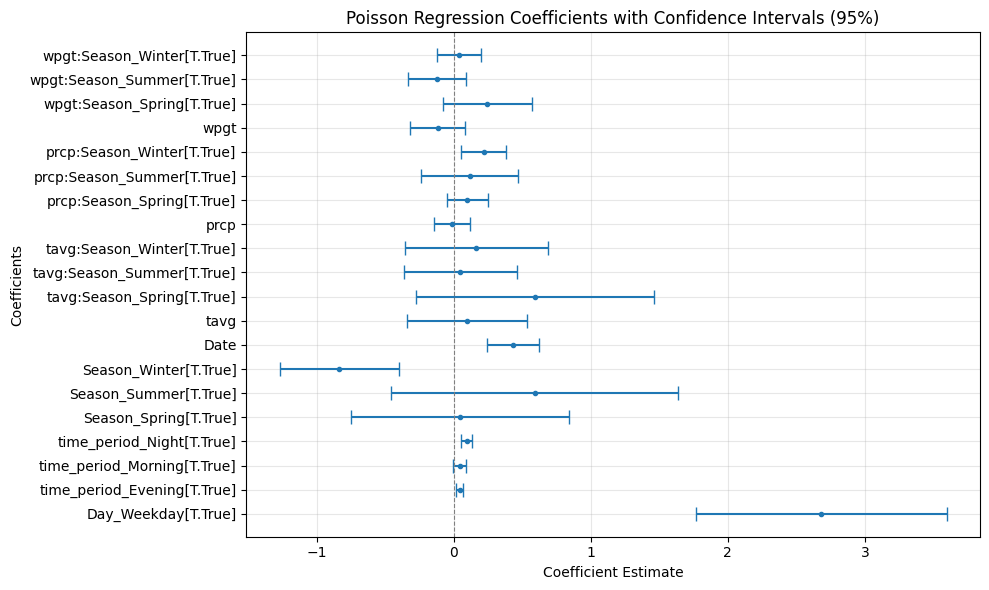

In [126]:
# Extract coefficients and confidence intervals
coef = poisson_model_results.params
conf_int = poisson_model_results.conf_int()



# Prepare a DataFrame for plotting
coef_df = pd.DataFrame({
    'Coefficient': coef.index,
    'Estimate': coef.values,
    'Lower CI': conf_int[0],
    'Upper CI': conf_int[1]
})

coef_df.sort_values('Estimate',ascending=False)

coef_df = coef_df[~coef_df['Coefficient'].isin(['Intercept'])]


# Plot the coefficients with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(
    coef_df['Estimate'],
    coef_df['Coefficient'],
    xerr=[coef_df['Estimate'] - coef_df['Lower CI'], coef_df['Upper CI'] - coef_df['Estimate']],
    fmt='.',
    capsize=5,
    label='Coefficient Estimate'
)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)  # Add a vertical line at x=0
plt.xlabel('Coefficient Estimate')
plt.ylabel('Coefficients')
plt.title('Poisson Regression Coefficients with Confidence Intervals (95%)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **Graph 23. Poisson Regression marginal effects**

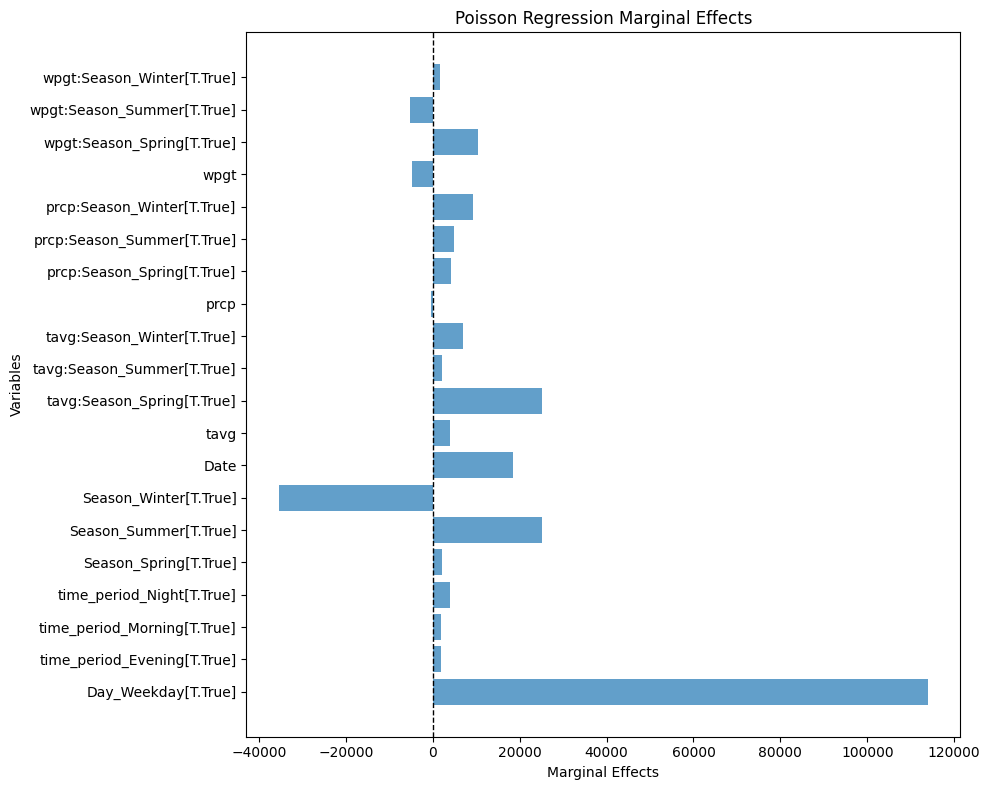

In [127]:
# Compute marginal effects
marginal_effects = poisson_model_results.get_margeff(at='overall', method='dydx')

# Get marginal effects summary as a DataFrame
marginal_effects_summary = marginal_effects.summary_frame()

# Plot marginal effects
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.barh(
    marginal_effects_summary.index, 
    marginal_effects_summary['dy/dx'], 
    capsize=5, 
    alpha=0.7
)
plt.axvline(0, color='black', linestyle='--', linewidth=1)  # Vertical line at zero
plt.title('Poisson Regression Marginal Effects')
plt.xlabel('Marginal Effects')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

### **Graph 24. Bicycle counts by Day**

Text(0.5, 1.0, 'Bicycle Counts by Day')

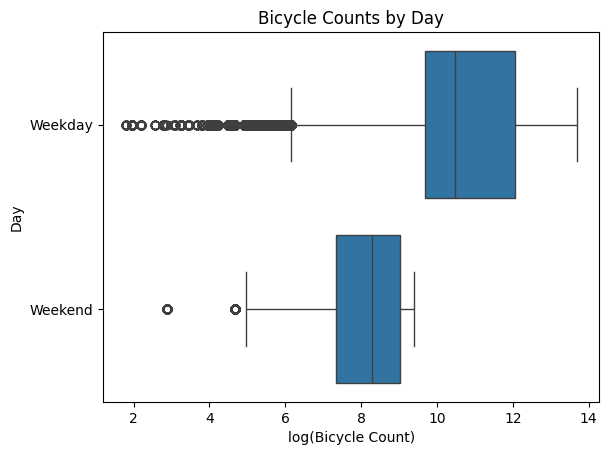

In [128]:
exploration_data = cycle_data_copy_1[cycle_data_copy_1['Mode'].isin(['Private cycles', 'Cycle hire bikes','Cycles','Conventional cycles'])].copy()

exploration_data['Count'] = np.log(exploration_data['Count'])
sns.boxplot(exploration_data, x='Count',y='Day')
plt.xlabel('log(Bicycle Count)')
plt.title('Bicycle Counts by Day')

## **V. Insights and Recommendations**

Overall, only a few of the predictors that we examined seem to be statistically significant in terms of predicting bicycle usage (as counts). However the ones with the highest coefficients and marginal effects are Weekday and the winter season. So because of that, we would recommend two things: first, local and/or government agencies should come up with ways to motivate people to use bicycles more during weekends as well and not only weekdays. Second, they should also consider subsidizing people to buy special equipment for cycling during winter in order to make cycling during this season easier, as well as give them other motives to use cycles during this season.

# **Section 3. Rail/Tube Station Data Analysis**

## **I. Data Collection and Preprocessing**

In this section, the datasets used are from https://crowding.data.tfl.gov.uk/. The station entry / exit counts in these datasets represent the entry / exit or boarding / alighting count at each station on a typical weekday (Monday-Thursday), Friday, Saturday or Sunday, and an annualised count: annual entry / exit total. Some datasets combine the Friday count with other weekdays and therefore record a (Monday-Friday) count at once. We take this into acount in our data cleaning and analysis. Datasets from 2017 to 2023 are used. Processed datasets will be used for congestion and transport network analyses below.

Mode Categories:
- **LU**: London Undergroud
- **LO**: London Overground
- **DLR**: Docklands Light Railway
- **TFLRail** : Transport for London Rail

In [129]:
def get_clean(file):
    """ Reads an Excel file, cleans the data, and returns a DataFrame.
    Takes an object of string type: The name of the Excel file to read.
    Returns a clean DataFrame """
    # Construct a relative file path to the data file
    path = os.path.join('..', '2024-project-sustainability-pathfinders', 'data', file)
    df = pd.read_excel(path)
    df = df[4:]
    df = df.reset_index(drop=True)
    df.columns = df.iloc[0].fillna('') + '_' + df.iloc[1].fillna('') 
    
    df = df[2:].reset_index(drop=True)
    return df

In [130]:
df_2017 = get_clean('AnnualisedEntryExit_2017.xlsx')
df_2018 = get_clean('AnnualisedEntryExit_2018.xlsx')
df_2019 = get_clean('AnnualisedEntryExit_2019.xlsx')
df_2020 = get_clean('AC2020_AnnualisedEntryExit.xlsx')
df_2021 = get_clean('AC2021_AnnualisedEntryExit.xlsx')
df_2022 = get_clean('AC2022_AnnualisedEntryExit.xlsx')
df_2023 = get_clean('AC2023_AnnualisedEntryExit.xlsx')

In [131]:
df_2017.head()

_Mode _NLC  _ASC      _Station             _Coverage _Source  \
0    LU  500  ACTu    Acton Town  Station entry / exit  Relate   
1    LU  502  ALDu       Aldgate  Station entry / exit  Relate   
2    LU  503  ALEu  Aldgate East  Station entry / exit  Relate   
3    LU  505  ALPu      Alperton  Station entry / exit  Relate   
4    LU  506  AMEu      Amersham  Station entry / exit  Relate   

  Weekday (Mon-Fri)_entries    _ Saturday_entries Sunday_entries  \
0                      9531 0.00             6716           4744   
1                     15080 0.00             4397           3261   
2                     22327 0.00            16166          13323   
3                      4495 0.00             3279           2345   
4                      3848 0.00             1876           1232   

  Weekday (Mon-Fri)_exits    _ Saturday_exits Sunday_exits Annualised_en/ex  
0                    9382 0.00           6617         4785       5731527.11  
1                   16023 0.00           5909         4230       8459233.62  
2                   21071 0.00          13893        11347      13262408.27  
3                    5081 0.00           3392         2445       2896391.38  
4                    4025 0.00           1797         1121       2215501.95

In [132]:
def prepare_df(df): 
    """ Takes a DataFrame and returns a DataFrame prepared for merging."""
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()
    # Rename the last column to 'Annualised_en/ex'
    df.rename(columns={df.columns[-1]: 'Annualised_en/ex'}, inplace=True)
    df = df[['_Station', 'Annualised_en/ex']]
    return df

In [133]:
p_df_2017 = prepare_df(df_2017)
df_2018 = prepare_df(df_2018)
df_2019 = prepare_df(df_2019)
df_2020 = prepare_df(df_2020)
df_2021 = prepare_df(df_2021)
df_2022 = prepare_df(df_2022)
df_2023 = prepare_df(df_2023)

In [134]:
p_df_2017.head()

_Station Annualised_en/ex
0    Acton Town       5731527.11
1       Aldgate       8459233.62
2  Aldgate East      13262408.27
3      Alperton       2896391.38
4      Amersham       2215501.95

In [135]:
dfs = [p_df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

# Iterate over each DataFrame in the list `dfs` and removes duplicate rows based on the '_Station' column
for i, df in enumerate(dfs):
    dfs[i] = df.drop_duplicates(subset=['_Station'])

In [136]:
# Merge the DataFrames in the list `dfs` on the '_Station' column.
merged_df = dfs[0]
for i, df in enumerate(dfs[1:], start=2018):
    merged_df = pd.merge(
        merged_df,
        df,
        on=[ '_Station'],
        how='inner',
        suffixes=(f'_{i-1}', f'_{i}')
    )

# Rename the last column to apply the correct suffix
merged_df.columns.values[-1] = 'Annualised_en/ex_2023'

In [137]:
# Drop duplicates in the 2017 dataframe
df_2017 = df_2017.drop_duplicates(subset=['_Station'])

# Perform the merge to add the _Mode column for Network Analysis
merged_df = pd.merge(merged_df, df_2017[['_Mode', '_Station']], on='_Station', how='left')
merged_df.head()

_Station Annualised_en/ex_2017 Annualised_en/ex_2018  \
0    Acton Town            5731527.11            5794684.87   
1       Aldgate            8459233.62            9218140.36   
2  Aldgate East           13262408.27           13707738.23   
3      Alperton            2896391.38            2796159.42   
4      Amersham            2215501.95            2130206.99   

  Annualised_en/ex_2019 Annualised_en/ex_2020 Annualised_en/ex_2021  \
0            6186555.36            3568527.65            2902696.68   
1            9956599.95            2775844.47            3525128.32   
2           14148654.22            3144899.06            5611129.83   
3            2858439.05            2064990.29            1345253.10   
4            2350099.19             863360.66             946577.05   

  Annualised_en/ex_2022 Annualised_en/ex_2023 _Mode  
0            4931971.57               4823835    LU  
1            6902494.47               6897314    LU  
2           10229487.64              10947896    LU  
3            2302973.00               2598605    LU  
4            1657141.47               1729521    LU

### **II. Passenger Demand Analysis By Day and Period**

In this section, the datasets used are from https://crowding.data.tfl.gov.uk/. The station entry / exit counts in these datasets represent the entry / exit or boarding / alighting total count per time period at each LU, LO, DLR, and TFLRail station during a typical weekday (Monday-Friday), Saturday, and Sunday. Datasets from 2017 to 2021 are used. The following datasets record the passenger counts during six time periods per day. Counts on weekends and weekdays are also recorded seperately.

The period categories are specified as follows:

 - **Early** - 5:00 to 7:00
 - **AM Peak** - 7:00 to 10:00
 - **Inter Peak** - 10:00 to 16:00
 - **PM Peak** - 16:00 to 19:00
 - **Evening** - 19:00 to 22:00
 - **Late** - 22:00 to 05:00

In [138]:
def get_ByQhr(file):
    """ Reads an Excel file, cleans the data, and returns a DataFrame."""
    # Construct a relative file path to the data file.
    path = os.path.join('..', '2024-project-sustainability-pathfinders', 'data', file)
    df = pd.read_excel(path, sheet_name='ByQhr', header=6)
    df = df.reset_index(drop=True)
    df = df.iloc[:, :15]
    df.columns = df.columns.str.strip()
    df['day'] = df['day'].replace('MTT', 'MTF')
    return df

In [139]:
ByQhr_2017 = get_ByQhr('ByQhrEntryExit_2017.xlsx')
ByQhr_2018 = get_ByQhr('ByQhrEntryExit_2018.xlsx')
ByQhr_2019 = get_ByQhr('ByQhrEntryExit_2019.xlsx')
ByQhr_2020 = get_ByQhr('AC2020_ByQhrEntryExit.xlsx')
ByQhr_2021 = get_ByQhr('AC2021_ByQhrEntryExit.xlsx')

In [140]:
ByQhr_2017.head()

Mode  NLC   ASC       Station              Coverage  year  day dir  Total  \
0   LU  500  ACTu    Acton Town  Station entry / exit  2017  MTF  IN   9531   
1   LU  502  ALDu       Aldgate  Station entry / exit  2017  MTF  IN  15080   
2   LU  503  ALEu  Aldgate East  Station entry / exit  2017  MTF  IN  22327   
3   LU  505  ALPu      Alperton  Station entry / exit  2017  MTF  IN   4495   
4   LU  506  AMEu      Amersham  Station entry / exit  2017  MTF  IN   3848   

   Early  AM Peak  Inter Peak  PM Peak  Evening  Late  
0    608     3287        2705     2029      655   247  
1    252     2774        3078     6931     1596   449  
2    290     3225        6301     8096     3104  1311  
3    558     1618        1073      831      313   102  
4    538     1952         701      534       92    31

### **Graph 25. Passenger Demand on Weekdays vs Weekends**

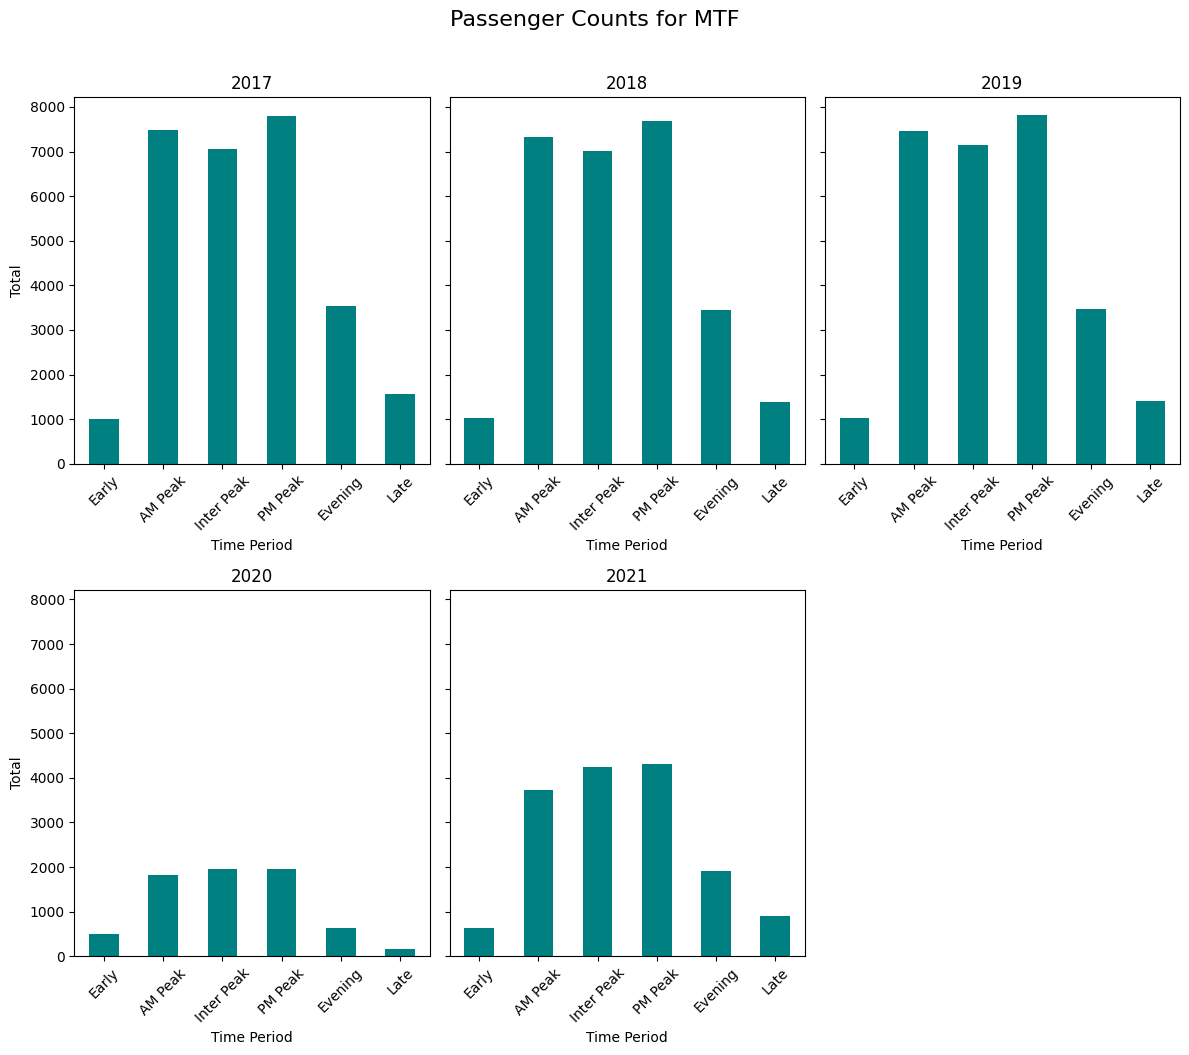

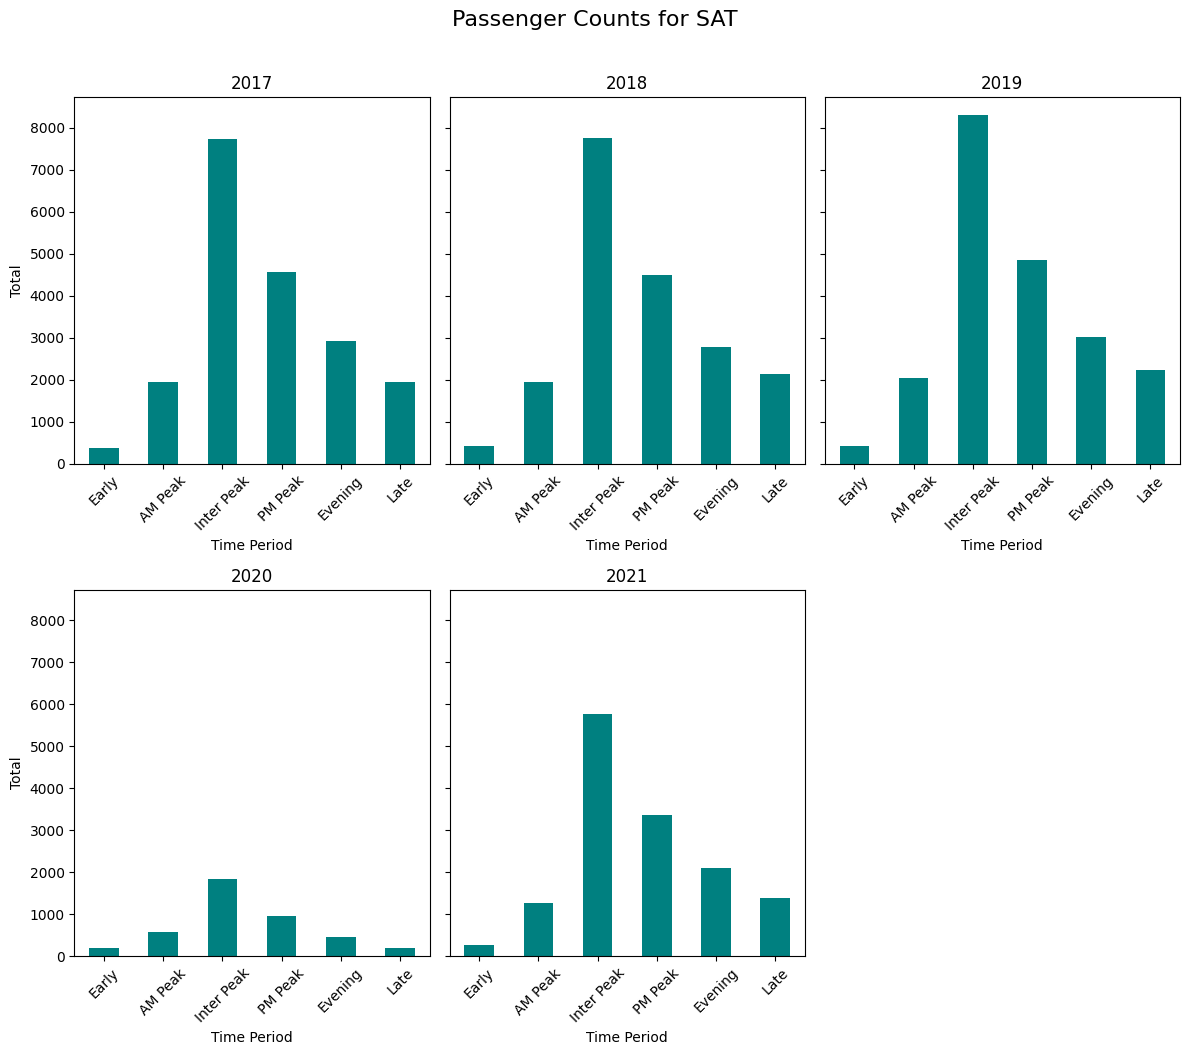

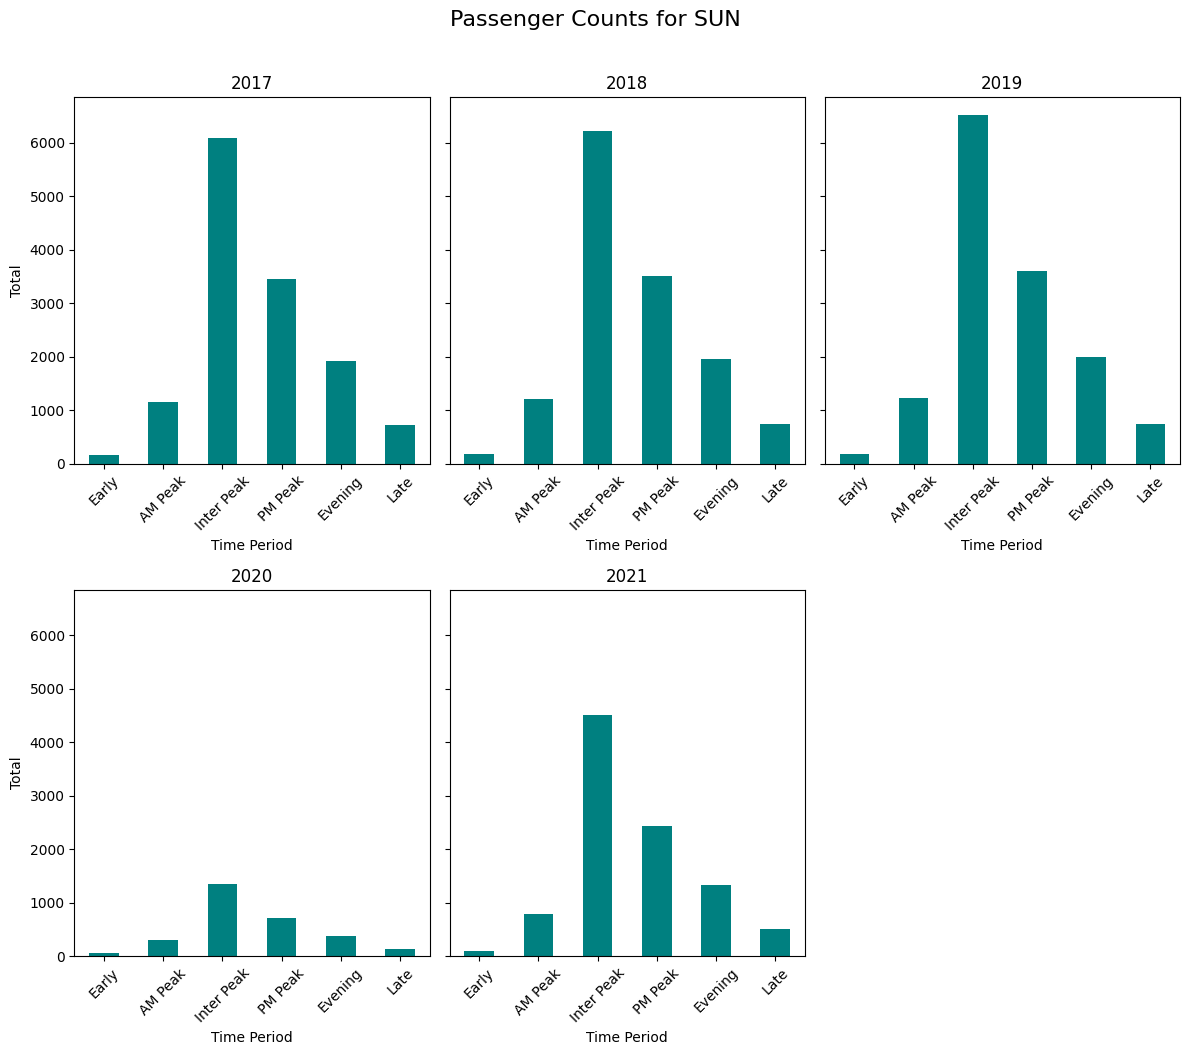

In [141]:
# Define the categories for 'Day'
day_categories = ByQhr_2017['day'].unique()

# Define the time periods
time_periods = ['Early', 'AM Peak', 'Inter Peak', 'PM Peak', 'Evening', 'Late']

# Create subplots for each year and each category of 'Day'
for day in day_categories:
    fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey=True)  
    axes = axes.flatten()  # for easier iteration

    for j, year in enumerate([2017, 2018, 2019, 2020, 2021]):
        df = globals()[f'ByQhr_{year}']
        df_day = df[df['day'] == day]
        df_grouped = df_day.groupby('Station')[time_periods].sum()

        df_grouped.mean().plot(kind='bar', ax=axes[j], color='teal')
        axes[j].set_title(f'{year}')
        axes[j].set_xlabel('Time Period')
        axes[j].set_ylabel('Total')
        axes[j].set_xticklabels(time_periods, rotation=45)

    # Hide the unused subplot 
    if len([2017, 2018, 2019, 2020, 2021]) < 6:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.suptitle(f'Passenger Counts for {day}', y=1.05, fontsize=16)

On weekdays, passenger counts peak during the PM peak period (16:00-19:00), which aligns with typical post-work travel patterns. In contrast, weekends experience the highest passenger volumes during the Inter Peak period (10:00-16:00), as individuals tend to travel for leisure purposes between the previously mentioned hours. The Covid-19 pandemic, not unexpectedly, resulted in a decline in passenger numbers across all time periods and days of the week during 2020 and 2021.

### **Graph 26. Passenger Demand During Different Periods**

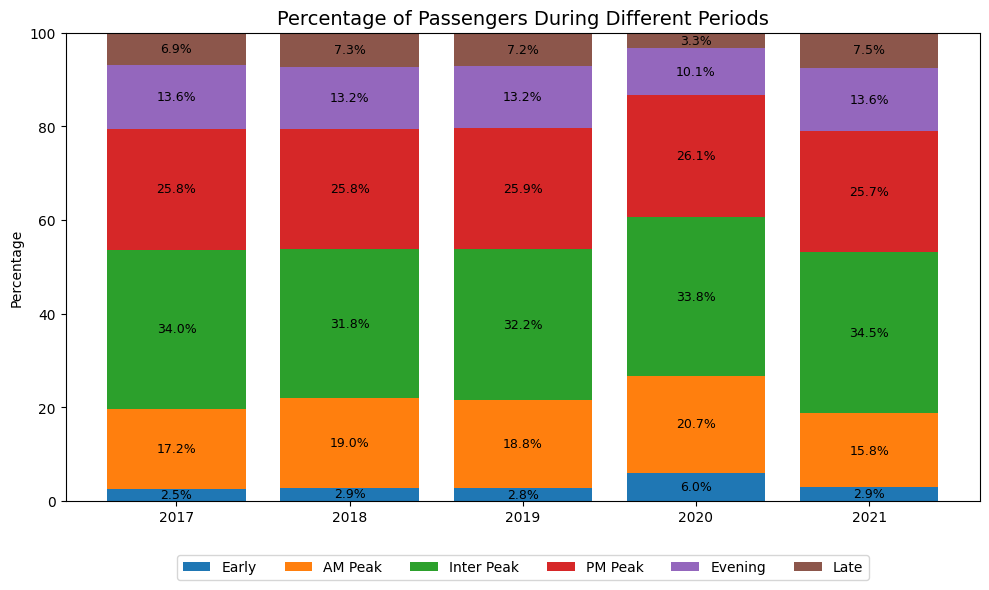

In [142]:
# Time periods of interest
years = [2017, 2018, 2019, 2020, 2021]

# Collect data dynamically and calculate percentages
values = np.array([globals()[f'ByQhr_{year}'][time_periods].sum().values for year in years])
percentages = values / values.sum(axis=1)[:, None] * 100  # Normalize to get percentages

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(years))

for i, period in enumerate(time_periods):
    p = ax.bar(years, percentages[:, i], label=period, bottom=bottom)
    bottom += percentages[:, i]

    # Add percentage labels inside bars
    for j, bar in enumerate(p):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                f'{percentages[j, i]:.1f}%', ha='center', va='center', fontsize=9)

ax.set_title("Percentage of Passengers During Different Periods", fontsize=14)
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

plt.tight_layout()

We can see a considerable decrease in the percentage of passenger count in the AM Peak period from an average of 17.2% in 2017 to 15.8% in 2021. This can be explained by the rise in hybrid/remote work schecules after the outbreak of the COVID-19 pandemic. Stable percentages are maintained throughout years during other other periods.

### **III. Tube Congestion Analysis**

#### **Webscraping Congestion Data**

In this section, I webscrape data from th following website: https://www.london.gov.uk/who-we-are/what-london-assembly-does/questions-mayor/find-an-answer/tube-overcrowding-0. The datapoints represent the number of incidents by tube station attributed to crowding/congestion, which have caused delays of two minutes or more between 2015/16 and 2018/19. 

In [143]:
# URL for the Tube Overcrowding data
overcrowding_link = "https://www.london.gov.uk/who-we-are/what-london-assembly-does/questions-mayor/find-an-answer/tube-overcrowding-0"

# Sending a request to the URL
web = requests.get(overcrowding_link)

# Parsing the HTML content
soup = BeautifulSoup(web.content, "lxml")

# Extracting the needed data
data_response = soup.find('tr').find_all_next('td')

# Replacing empty values with 0
data_list = []
for datapoint in data_response:
    data_list.append(datapoint.text.replace('\xa0', '0'))

data = data_list[15: -30]

In [144]:
# Reshaping Scraped Data

headers = data[:5]
rows = data[5:]

# Group the data into chunks corresponding to the number of columns
chunk = len(headers)
structured_data = [rows[i:i + chunk] for i in range(0, len(rows), chunk)]

# Create a DataFrame from the structured data
congestion_df = pd.DataFrame(structured_data, columns=headers)

# Convert all columns except 'Station' to numeric
for col in congestion_df.columns[1:]:
    congestion_df[col] = pd.to_numeric(congestion_df[col], errors='coerce')

# Rename the 'Station' column to '_Station' to match the column name in the merged DataFrame
congestion_df.rename(columns={'Station': '_Station'}, inplace=True)

display(congestion_df)

_Station  2015-16  2016-17  2017-18  2018-19
0            ACTON TOWN        2        4        4        0
1          ALDGATE EAST        0        0        0        1
2                 ANGEL        2        1        0        0
3               ARCHWAY        0        0        1        0
4           ARNOS GROVE        0        3        0        0
..                  ...      ...      ...      ...      ...
141         WHITECHAPEL        0        0        0        1
142  WILLESDEN JUNCTION        0        1        0        0
143      WIMBLEDON PARK        1        0        0        0
144          WOOD GREEN        0        1        0        1
145               Total      393      456      378      559

[146 rows x 5 columns]

### **Graph 27: Correlation Between Congestion Incidents and Passenger Demand**

In [145]:
# Unify the station names in both DataFrames
congestion_df['_Station'] = congestion_df['_Station'].str.upper().str.strip()
merged_df['_Station'] = merged_df['_Station'].str.upper().str.strip()

# Merge the DataFrames on the '_Station' column
cong_df_used = congestion_df[['_Station', '2017-18', '2018-19']].drop(congestion_df.index[-1])
merged_df_used = merged_df[['_Station', 'Annualised_en/ex_2017', 'Annualised_en/ex_2018']]
cong_merged_data = pd.merge(cong_df_used, merged_df_used, on='_Station', how='inner')   
display(cong_merged_data)

# Drop the '_Station' column and calculate the correlation matrix
cong_merged_data.drop(columns=['_Station'], inplace=True)
corrs = cong_merged_data.corr()

_Station  2017-18  2018-19 Annualised_en/ex_2017  \
0            ACTON TOWN        4        0            5731527.11   
1          ALDGATE EAST        0        1           13262408.27   
2                 ANGEL        0        0           18236122.52   
3               ARCHWAY        1        0            8806365.21   
4           ARNOS GROVE        0        0            4372042.29   
..                  ...      ...      ...                   ...   
114          WHITE CITY        1        0            8433511.13   
115         WHITECHAPEL        0        1           13137261.28   
116  WILLESDEN JUNCTION        0        0            4453456.16   
117      WIMBLEDON PARK        0        0            2074784.80   
118          WOOD GREEN        0        1           12202221.93   

    Annualised_en/ex_2018  
0              5794684.87  
1             13707738.23  
2             17661269.04  
3              8608964.46  
4              4263554.81  
..                    ...  
114            8389589.62  
115           13130308.87  
116            4984205.99  
117            2155333.62  
118           11447694.19  

[119 rows x 5 columns]

<Axes: >

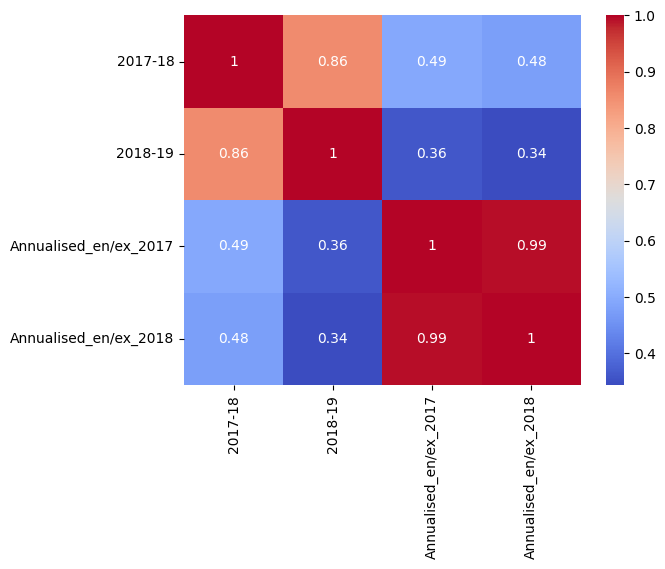

In [146]:
# Plot the correlation matrix
sns.heatmap(corrs,cmap='coolwarm',annot=True)

The heatmap reveals a moderate positive correlation between congestion incidents and annualized passenger entry/exit numbers for the same year (e.g., 0.49 between 2017-18 congestion and 2017 passenger numbers). This suggests that stations with higher congestion incidents also experience greater passenger volumes, indicating a direct relationship between passenger demand and station crowding. 

To assess whether congestion negatively affects future passenger numbers, a lagged analysis is considered. The correlation between 2017-18 congestion incidents and 2018 passenger numbers (0.48) is slightly lower than the correlation between 2017-18 congestion and 2017 passenger numbers (0.49). While the difference is negligible, this decline implies that sustained congestion might reduce passenger growth over time, though the effect appears insignificant in the short term. 

Additionally, the near-perfect correlation between annualized entry/exit figures for consecutive years (0.99 between 2017 and 2018) suggests that passenger travel patterns are highly consistent over time, regardless of congestion incidents, likely due to habitual commuting and limited alternative routes. 

A strong correlation (0.86) between congestion incidents in 2017-18 and 2018-19 highlights the persistence of congestion at specific stations. This consistency suggests that stations experiencing congestion in one year will continue to experience congestion across future years.

#### **Insights and Recommendations**


The positive correlation between congestion and passenger numbers, even with a lag, suggests that congestion does not significantly deter passengers. Instead, high passenger volumes are the primary drivers of congestion. Major stations likely maintain their attractiveness due to their critical role in the transport network, regardless of crowding or delays. In addition, we saw a fairly consistent pattern of passenger demand during weekends and weekdays and during different timeslots. This also suggests that congestion has little impact on passenger demand. Major events like the COVID-19 pandemic impacts the tube network.

While the correlation decrease over time is minimal, the slight decline (0.01 for lagged years) may indicate that persistent congestion could lead to a decline in passenger numbers over an extended period. Alternatively, it may reflect that congestion levels are within a tolerable range for commuters, or that alternative routes and stations are limited.

Stations consistently experiencing high congestion should be prioritized for capacity expansion, infrastructure improvements, or enhanced crowd management strategies. Addressing persistent congestion could prevent future deterrence and support sustained passenger growth and therefore reduce carbon emissions due to individual vehicle use. 

### **IV. Transport Network Analysis**

#### **Graph 28: Transport Networks of Each Transport Mode**
These network visualizations reveal the relationships between stations based on the similarity of their entry/exit values over the years that we looked at. 

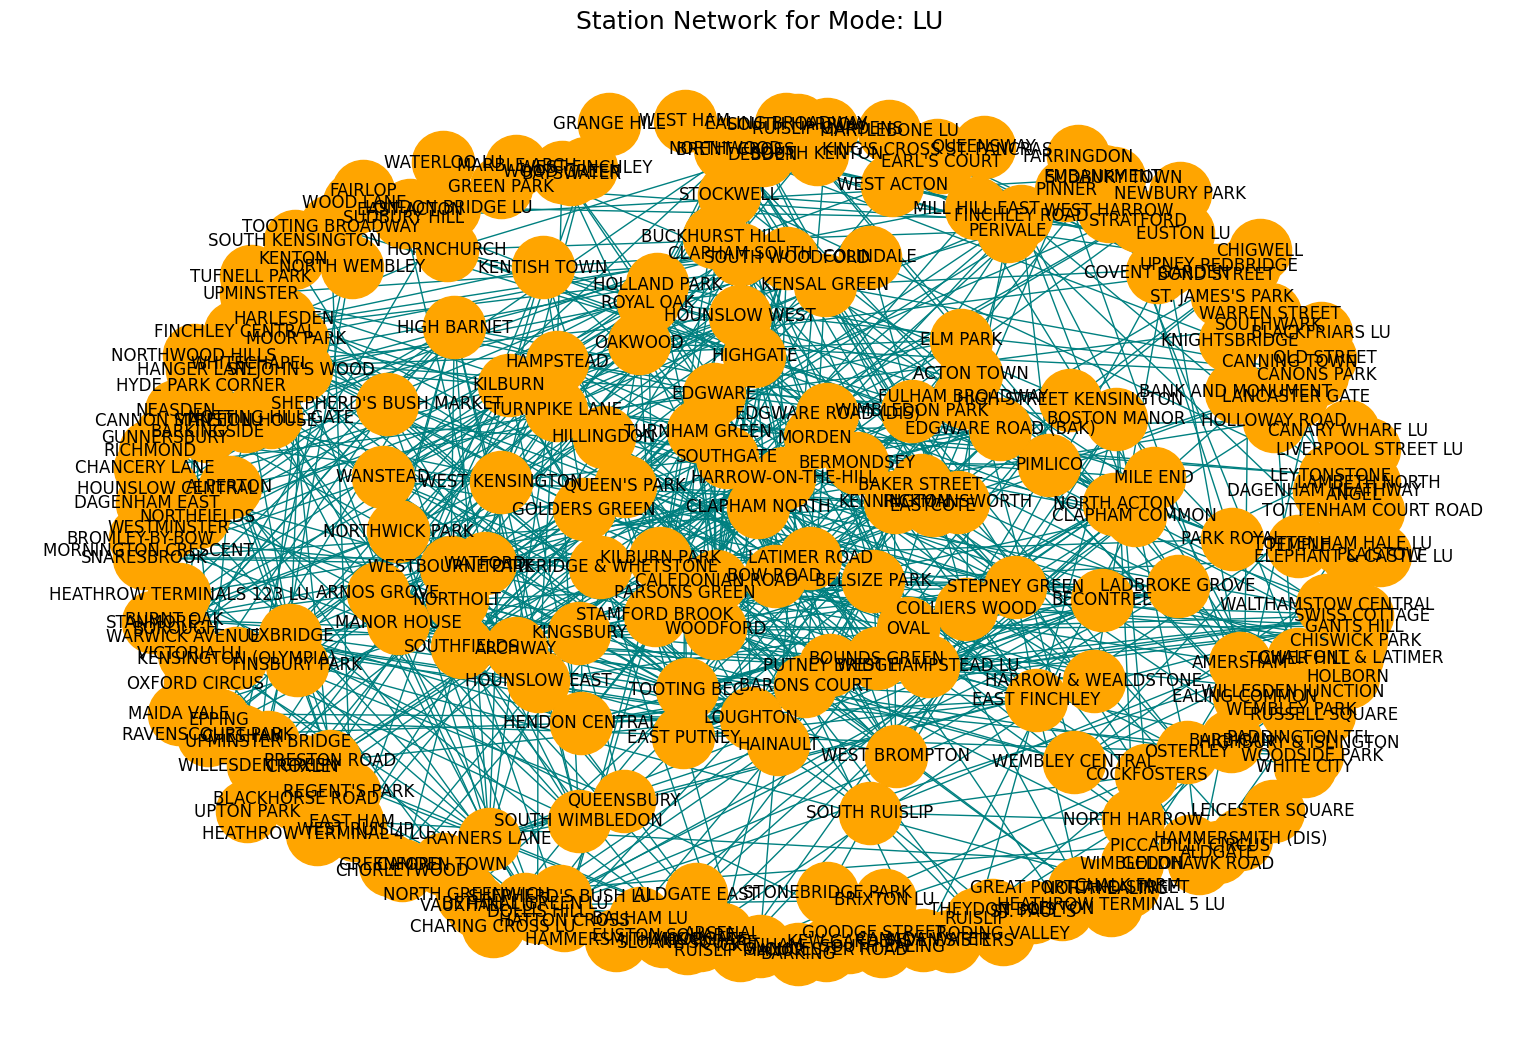

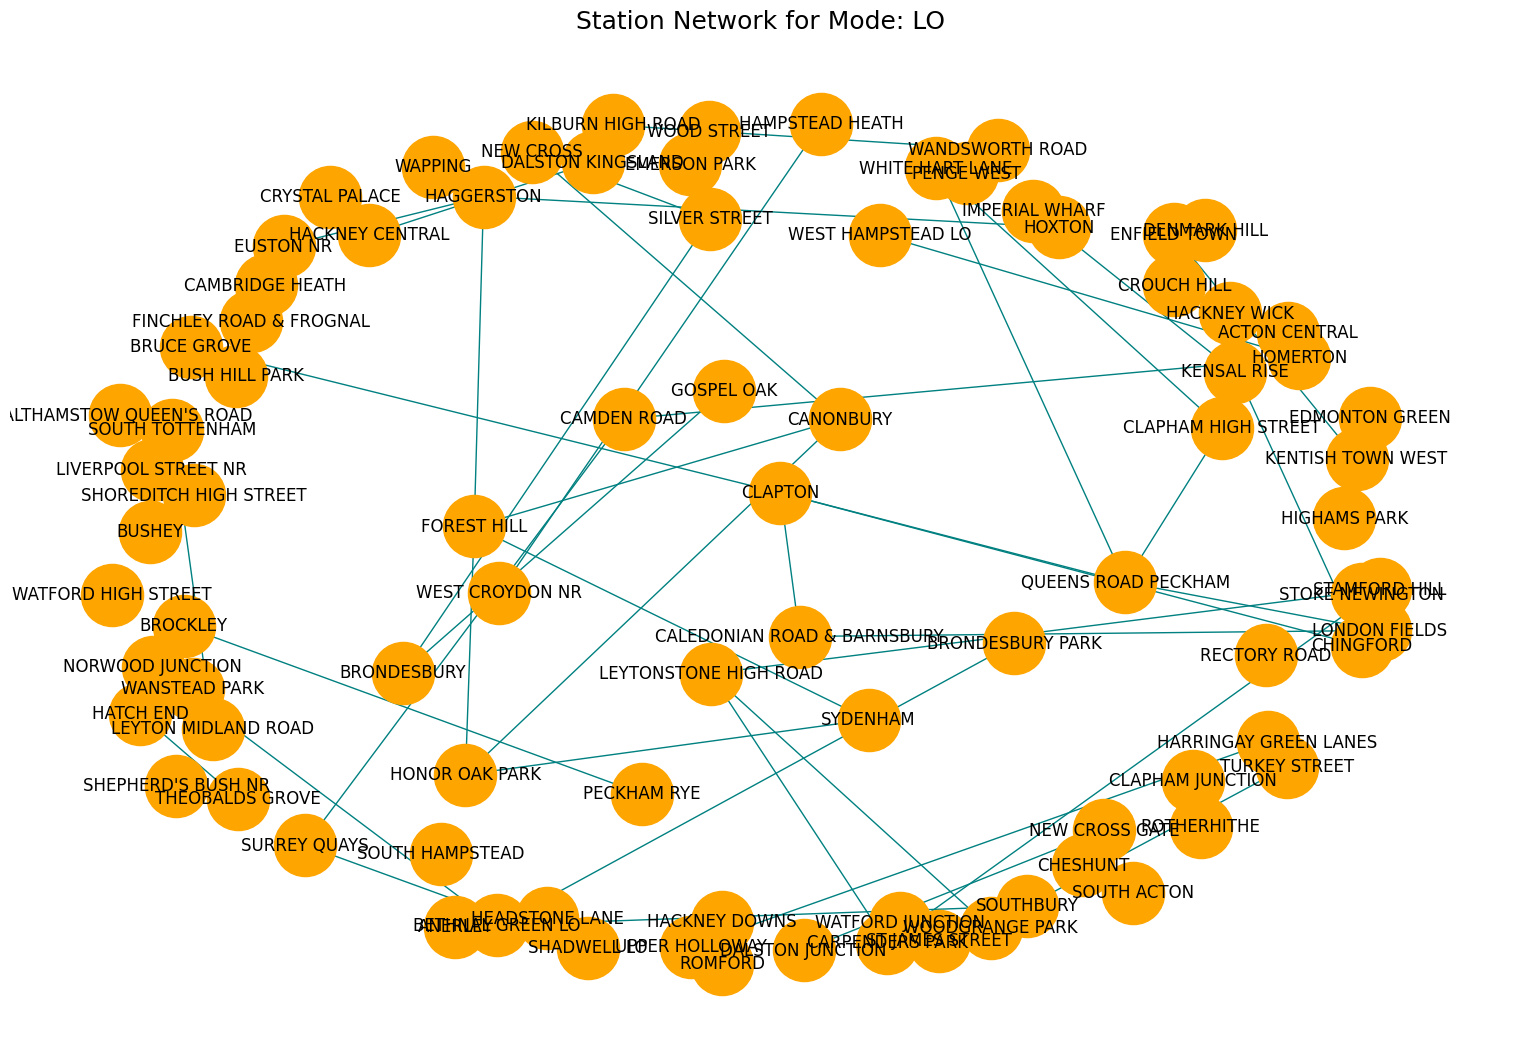

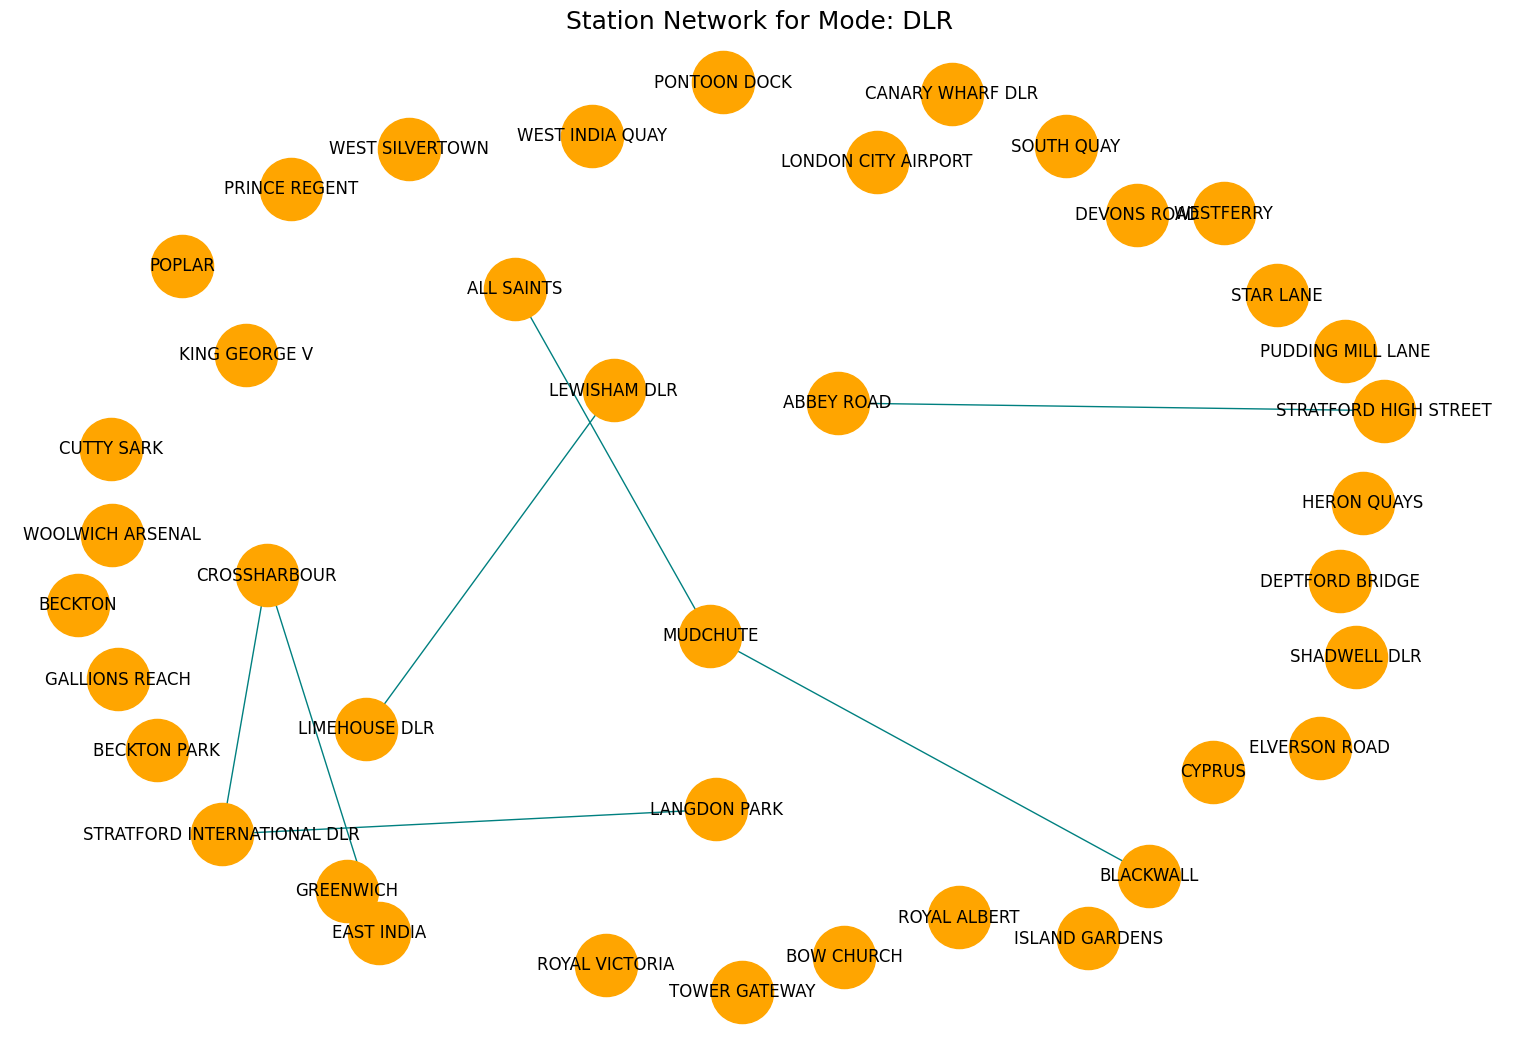

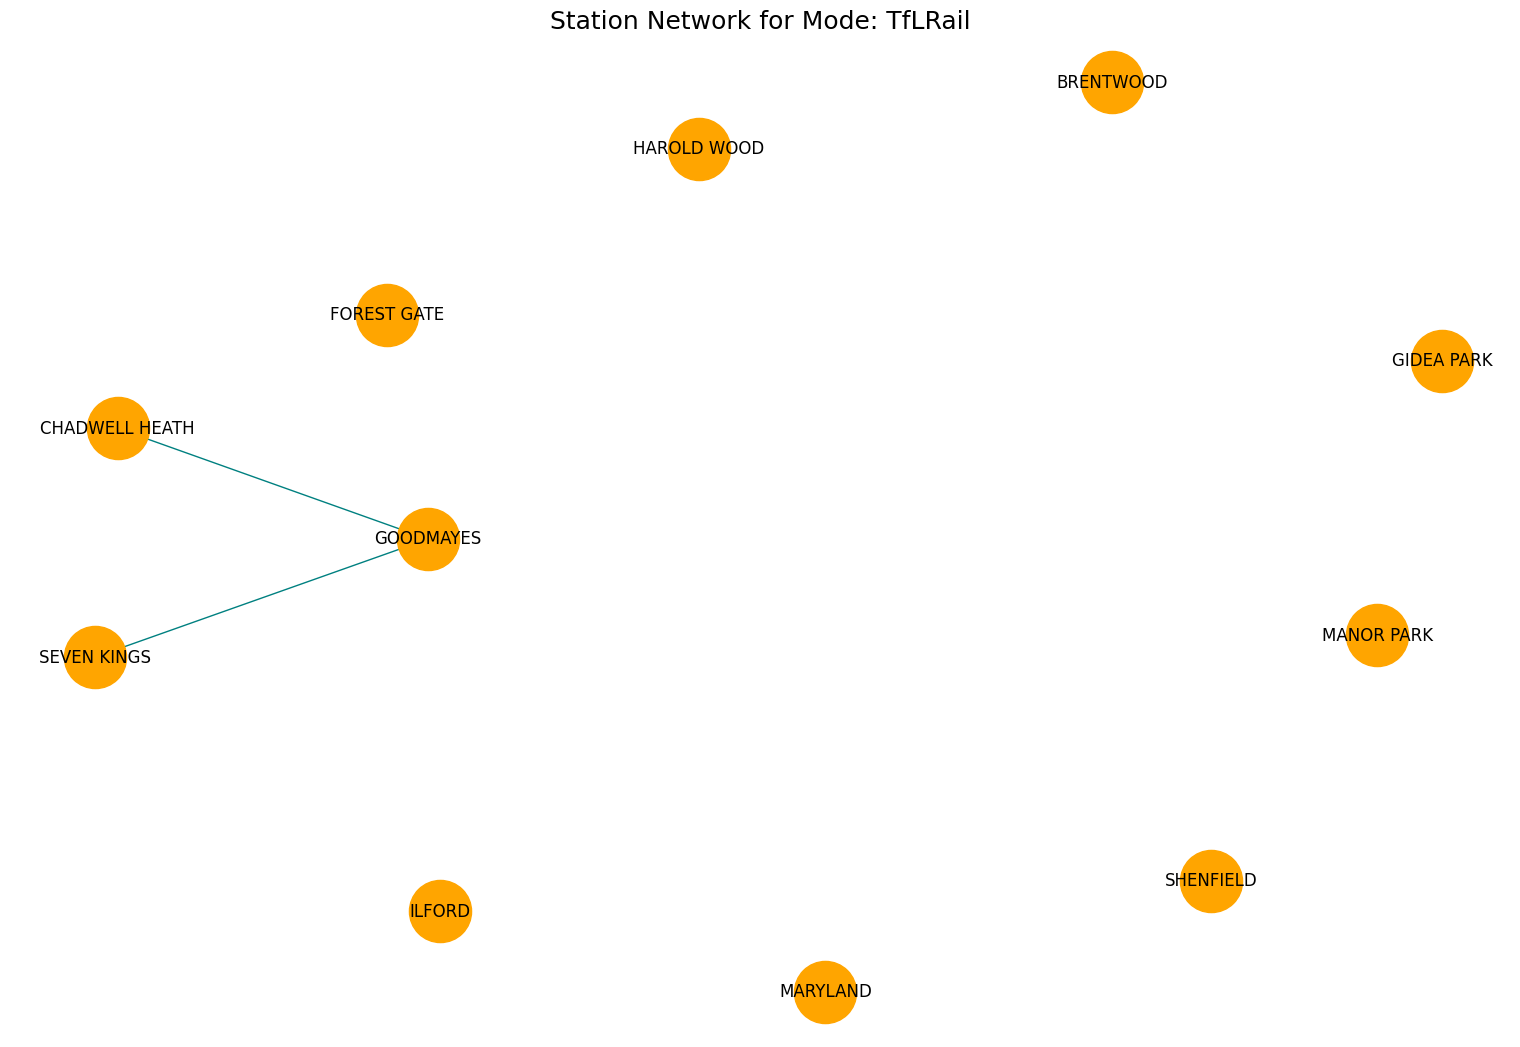

In [147]:
# Extract all columns with entry/exit counts
entry_exit_columns = [col for col in merged_df.columns if 'Annualised_en/ex' in col]

merged_df[entry_exit_columns] = merged_df[entry_exit_columns].replace('---', np.nan)

# Add to avoid warning
pd.set_option('future.no_silent_downcasting', True)

merged_df[entry_exit_columns] = merged_df[entry_exit_columns].apply(lambda x: x.fillna(x.mean()))


# Scale the data for clustering to normalize yearly counts
scaler = MinMaxScaler()
merged_df[entry_exit_columns] = scaler.fit_transform(merged_df[entry_exit_columns])


# Function to calculate similarity between two stations
# Uses percentage difference to determine if two stations are close enough in values
def is_similar(row1, row2, threshold=20):
    def percentage_diff(a, b):
        if a == 0 and b == 0:
            return 0  # If both are zero, treat them as 0% difference
        return abs(a - b) / ((a + b) / 2) * 100

    # Calculate similarity for each year and check if all years pass the threshold
    for col in entry_exit_columns:
        if percentage_diff(row1[col], row2[col]) > threshold:
            return False
    return True

# Visualize stations by mode
for mode in merged_df['_Mode'].unique():

    # Filter dataframe by mode (LU, LO, etc.)
    mode_df = merged_df[merged_df['_Mode'] == mode]
    
    G = nx.Graph()
    
    # Add stations as nodes
    for _, row in mode_df.iterrows():
        G.add_node(row['_Station'])
    
    # Add edges between stations with similar entry/exit values across all years
    for i, row1 in mode_df.iterrows():
        for j, row2 in mode_df.iterrows():
            if i != j and is_similar(row1, row2):
                G.add_edge(row1['_Station'], row2['_Station'])

    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=1)  # Position nodes using spring layout

    # Scale node sizes by degree
    node_sizes = [G.degree(node) * 300 for node in G.nodes()]

    nx.draw(G, pos, with_labels=True, node_color='orange',node_size=2000, edge_color='teal')
    plt.title(f'Station Network for Mode: {mode}', fontsize=18)

#### **Insights and Recommendations**

The LU network graph shows dense interconnectededness  between stations, suggesting similar demand patterns for many stations. Not only does the graph show similar demand patterns between stations but also infers consistency in demand throughout the years. It is clear that two clusters are formed, one positioned in the center and the other positioned around the edges.  The dense web of connections aligns with the LU's role as the backbone of London's transport, with consistent demand across many stations.

The LO  graph network is similar to the LU one but is not as densely interconnected. There are apparent clusters of interconnected stations. The Overground’s role in connecting suburban areas to central hubs is evident, with a less intricate but still cohesive structure compared to the underground.

The DLR network is linear and sparse, with distinct edges. This highlights the DLR’s design, which serves specific corridors like Canary Wharf and East London with limited overlap between edges. The less interconnected nature reflects the DLR's focused purpose of linking Docklands and East London to other parts of the city, emphasizing direct point-to-point travel rather than widespread interconnectivity, and hence lower passenger demand.

These insights can be useful for optimizing service planning, resource allocation, and infrastructure development to meet passenger demand effectively and efficiently. 

# **Conclusions and Policy Recommendations**

In order to promote net-zero aspirations, we looked at three main areas: general traffic modes and patterns, London cycling behavior, and the use of tube/rail stations. Our findings highlight the need for a comprehensive approach to lowering carbon emissions and provide some crucial information that can help shape sound policies.

According to traffic trends, cars and taxis remain the most popular modes of transportation in the UK and the largest sources of $CO_2$ emissions in every region. This emphasizes how urgent it is to move away from private motorized transportation in order to meet the country's net-zero goals. Among all regions, South East has the greatest emissions (5.0 × 10¹¹ kg $CO_2$). During the COVID-19 pandemic, traffic briefly declined, but it has since rebounded in most areas. Among its distinctive features, London is more likely than other areas to use public transportation and pedal bicycles. This implies that the integrated transit strategy in London may be a model for other urban areas.

Two primary obstacles to greater bicycle use were identified by our examination of London's cycling patterns. First, there is a noticeable decrease in bicycle activity throughout the winter. Second, commuting by bicycle is significantly less common on weekends than it is during the week. This pattern suggests that riding a bicycle is less of a recreational activity and more of a commuting option. These findings highlight the importance of developing policies to boost weekend and winter bicycle utilization.

The analysis of train and tube stations showed that congestion had little impact on passenger volume, suggesting that public transportation is still required even in highly congested situations. The network analysis also revealed strong interconnections in the London Underground system.

According to our study, urban and rural transportation trends are different. When it comes to traffic numbers and mode composition, London and the South East have different characteristics. Pedal cycles and public transport are used more frequently in London than in other places. In rural areas, private vehicles remain the main form of mobility. These regional variations highlight the need for tailored transportation strategies that take into account local needs and traits.


Several policy recommendations follow from these findings. First, targeted cycling operations should focus on addressing seasonal differences with weather-protected infrastructure and winter support programs. Second, expanding capacity at congested stations and utilizing dynamic pricing strategies to optimize passenger flow should be the main priorities of public transportation improvement. Third, regional transportation strategies should be influenced by local circumstances, with similar patterns being shown using common methodologies throughout regions. Cars and taxis should be the main focus of carbon reduction programs due to their high emissions. This means developing specific strategies for high-emission vehicle categories as well as incentives for the adoption of low-emission vehicles in urban areas. Infrastructure development should focus on enhancing modal integration to provide seamless transitions between different forms of transportation, particularly in areas with high carbon emissions.

To implement these ideas successfully, cooperation between governmental agencies, transportation companies, and other interested parties is required. Initiatives must be regularly reviewed and modified in light of their effectiveness if the desired outcomes are to be attained. To ensure the success of these measures, a robust monitoring system must be established. Key performance indicators should track a variety of variables, including fluctuations in ridership between peak and off-peak hours, carbon emission reductions, changes in riding behavior, and the implementation of tailored programs. The system may adapt to shifting user needs and travel trends by using this data to empirically enhance pricing and incentive schemes. By regularly assessing and adjusting these initiatives, the UK can develop a transport system that achieves three key objectives: social inclusivity through affordable and easily accessible services for all citizens, economic viability through effective resource use, and environmental sustainability through reduced emissions.

This transformation of the transport system represents a critical step toward achieving the UK's ambitious Net-Zero targets while building a more resilient and user-friendly transportation network for future generations.